# Dependencies and files

## Install dependencies

## Imports

In [540]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [541]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [542]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [543]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [544]:
conditions = ['human', 'chimp', 'macaque', 'spatial_libd_human']
cond_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']
color_dict = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'spatial_libd_human': 'tab:blue'}

# Load files

## Pseudobulks

In [545]:
dir_path = 'results/'

In [546]:
os.listdir(dir_path)

['adults_mammals.h5ad',
 'adults_mammals_zscore_norm.h5ad',
 'age_hs_groups.csv',
 'background_genes.txt',
 'hs_norm_splines_adults_mammals.csv',
 'human_clusters_edgeR_6.csv',
 'zscore_norm_expr_adults_mammals.csv']

In [547]:
adata_pb_merged_norm = sc.read_h5ad(dir_path + 'adults_mammals_zscore_norm.h5ad')
adata_pb_merged_norm

AnnData object with n_obs × n_vars = 170 × 14611
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p'
    layers: 'psbulk_props'

## Specie-specific genes

In [548]:
from statsmodels.stats.multitest import multipletests
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('../results/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('../results/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('../results/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

logFC.spline_1.human  logFC.spline_2.human  logFC.spline_3.human  \
A1BG               0.244038              0.286535              0.252427   
AACS              -0.388070             -0.241365             -0.039750   
AADAT             -0.399771             -0.369816             -0.361727   
AAGAB              0.086928              0.361438              0.044400   
AAK1               0.231119              0.421302              0.032839   

         logCPM         F    PValue  p_val_adj  
A1BG   8.937955  1.353039  0.266747   0.847434  
AACS   8.898749  1.925657  0.131096   0.624955  
AADAT  8.822620  0.269978  0.846744   1.000000  
AAGAB  8.837510  0.579746  0.630315   1.000000  
AAK1   8.977608  0.409947  0.746269   1.000000

In [549]:
sign_genes = lambda df: df[df.p_val_adj < 0.05].index
sign_genes_dict = {key:sign_genes(df) for key, df in res_dict.items()}
sign_genes_dict

{'human-chimp': Index(['ACTN2', 'ADGRB2', 'ADGRG1', 'ADGRL1', 'ALCAM', 'AMZ2', 'ANK3', 'AP2S1',
        'APBA1', 'APBA2',
        ...
        'UQCRB', 'UQCRH', 'VAT1L', 'WDR37', 'WLS', 'ZBTB18', 'ZBTB46',
        'ZCCHC17', 'ZMYND8', 'ZNF706'],
       dtype='object', length=224),
 'human-macaque': Index(['AACS', 'AARS1', 'AATK', 'ABAT', 'ABCA2', 'ABCC10', 'ABCC5', 'ABCD3',
        'ABCD4', 'ABHD10',
        ...
        'ZNF483', 'ZNF536', 'ZNF579', 'ZNF706', 'ZNF770', 'ZNF791', 'ZNHIT3',
        'ZRANB2', 'ZYG11B', 'ZYX'],
       dtype='object', length=2141),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9',
        'ACHE', 'ACOT7',
        ...
        'YPEL5', 'YWHAB', 'YWHAG', 'ZDHHC22', 'ZDHHC8', 'ZDHHC9', 'ZFAND5',
        'ZMPSTE24', 'ZNF536', 'ZNF655'],
       dtype='object', length=1057)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [550]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RBIS', 'RGS2', 'SCN3B', 'SEPTIN6',
        'ST3GAL5', 'SULF2', 'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1',
        'VAT1L', 'ZBTB18', 'ZBTB46', 'ZNF706'],
       dtype='object'),
 65)

In [551]:
background_genes = res_dict['human-chimp'].index.tolist()
len(background_genes)

7790

## Load expression

In [552]:
df_cont = pd.read_csv('results/zscore_norm_expr_adults_mammals.csv', index_col=0)
df_cont.head()

A1BG      A1CF     A2ML1    A4GALT      AAAS      AACS  \
human_759_L1 -1.349514  0.296344  1.619511  0.636888  2.135175 -1.239566   
human_j12_L1 -0.253823 -0.546910 -0.788673  1.503895  0.274673 -2.038361   
human_j3_L1  -1.798212 -0.377964 -0.749522 -0.727082 -1.695254 -0.151154   
human_j4_L1  -0.438630  1.075589 -0.992418 -1.501498  0.022243 -1.916469   
human_j6_L1  -1.363265 -0.535585 -0.405802  1.815469  0.908053 -0.033655   

              AADAC   AADACL3     AADAT     AAGAB  ...      ZW10    ZWILCH  \
human_759_L1    0.0  0.000000  0.837341 -1.828188  ...  0.009805 -1.900421   
human_j12_L1    0.0  0.000000 -0.818210 -0.051467  ... -1.328663 -1.785875   
human_j3_L1     0.0  0.000000  1.086933 -1.666962  ...  2.106568 -1.458733   
human_j4_L1     0.0  0.000000  0.824506 -1.072760  ... -1.942717 -1.128809   
human_j6_L1     0.0 -0.377964  0.328104  0.086677  ...  0.284179 -2.087581   

                 ZWINT      ZXDC    ZYG11A    ZYG11B       ZYX     ZZEF1  \
human_759_L1 -0.346789  1.701905 -0.632214 -1.423813  1.276544  0.316995   
human_j12_L1 -1.580698 -0.096356 -0.377964 -1.401303  0.640787 -1.280645   
human_j3_L1   2.152959  1.068892 -0.654488 -1.868051 -0.220212  1.973133   
human_j4_L1   1.605225  1.322369 -0.677695 -0.040136  0.596974 -1.082610   
human_j6_L1  -0.777034  1.395724 -0.377964 -2.205263  0.408286  1.143058   

              layer  condition  
human_759_L1      1      human  
human_j12_L1      1      human  
human_j3_L1       1      human  
human_j4_L1       1      human  
human_j6_L1       1      human  

[5 rows x 14613 columns]

In [553]:
df_spline = pd.read_csv('results/hs_norm_splines_adults_mammals.csv', index_col=0)

In [554]:
common_hs_genes = df_cont.columns.intersection(hs_genes)
common_hs_genes

Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
       'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
       'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
       'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
       'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
       'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
       'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RGS2', 'SCN3B', 'ST3GAL5', 'SULF2',
       'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1', 'VAT1L', 'ZBTB18',
       'ZBTB46', 'ZNF706'],
      dtype='object')

# Helpful functions

In [555]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [556]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [557]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        else:
            raise Exception('Error analyzing gene list')
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        else:
            raise Exception('Error analyzing gene list')
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        else:
            raise Exception('Error analyzing gene list')
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Correlation of profiles

## Calculate correlations

In [558]:
from scipy.stats import spearmanr, pearsonr

columns = ['sp_ha', 'sp_mca', 'pear_ha', 'pear_mca']
corr_list = []
for gene in df_spline.columns[:-1]:
    human_spl = df_spline.loc[df_spline.condition == 'human', gene].values
    adult_spl = df_spline.loc[df_spline.condition == 'spatial_libd_human', gene].values
    chimp_spl = df_spline.loc[df_spline.condition == 'chimp', gene].values
    macaque_spl = df_spline.loc[df_spline.condition == 'macaque', gene].values
    ch_m_spl = (chimp_spl + macaque_spl) / 2



    pear_ha = pearsonr(adult_spl, human_spl)
    pear_mca = pearsonr(adult_spl, ch_m_spl)
    sp_ha = spearmanr(adult_spl, human_spl)
    sp_mca = spearmanr(adult_spl, macaque_spl)
    corr_list.append([sp_ha[0], sp_mca[0], pear_ha[0], pear_mca[0]])

corr_df = pd.DataFrame(corr_list, columns=columns, index=df_spline.columns[:-1])
corr_df.head()

sp_ha    sp_mca   pear_ha  pear_mca
ALCAM  -0.369458 -0.563306 -0.151619 -0.350765
AMZ2    0.145803 -0.474602  0.335717 -0.554347
ASAH1   0.953312 -0.781685  0.955634 -0.812406
ASAP2  -0.306263  0.982126 -0.342722  0.940242
ATP1A3 -0.020166  0.506055 -0.092149  0.520105

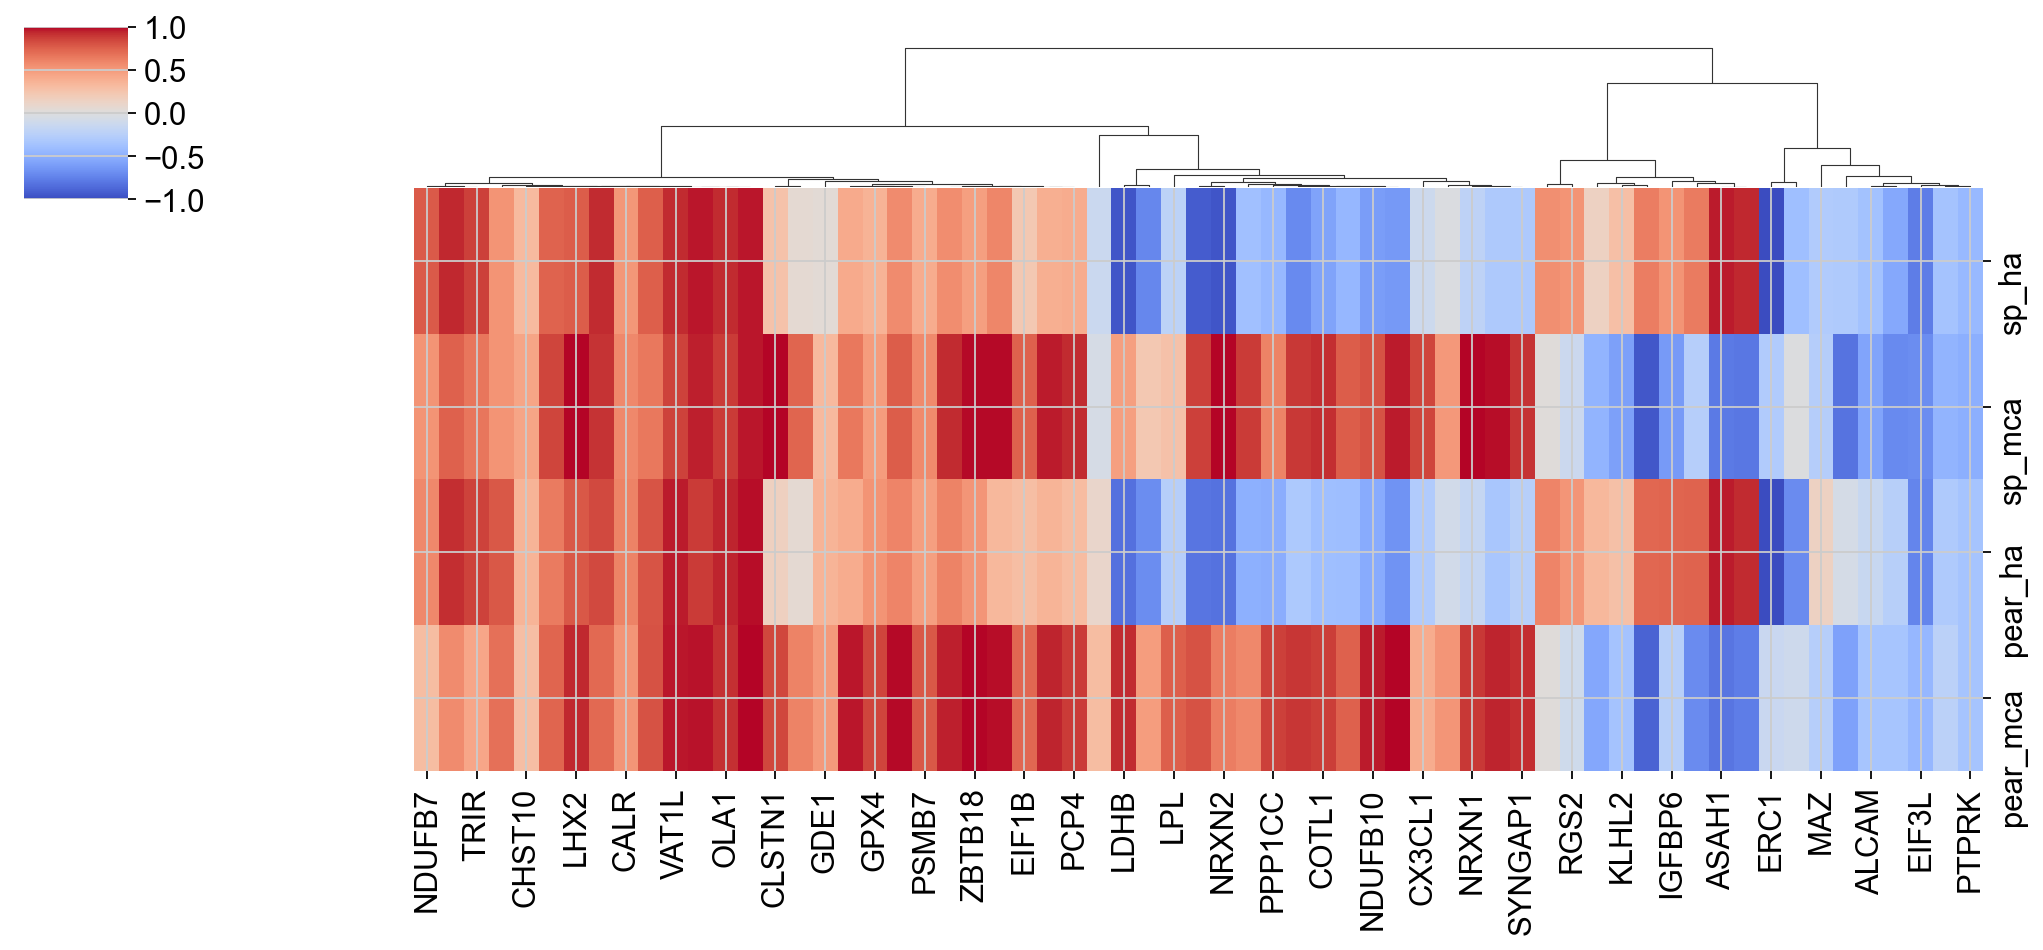

In [559]:
#fig = plt.figure(figsize=(10, 3), dpi=60)
clust = sns.clustermap(corr_df.T, cmap='coolwarm', figsize=(13, 6), row_cluster=False, metric='cosine')

In [560]:
corr_df['mean_ha'] = (corr_df['sp_ha'] + corr_df['pear_ha']) / 2
corr_df['mean_mca'] = (corr_df['sp_mca'] + corr_df['pear_mca']) / 2
corr_df['corr_diff'] = corr_df['mean_ha'] - corr_df['mean_mca']

corr_df['pear_diff'] = corr_df['pear_ha'] - corr_df['pear_mca']
corr_df['sp_diff'] = corr_df['sp_ha'] - corr_df['sp_mca']

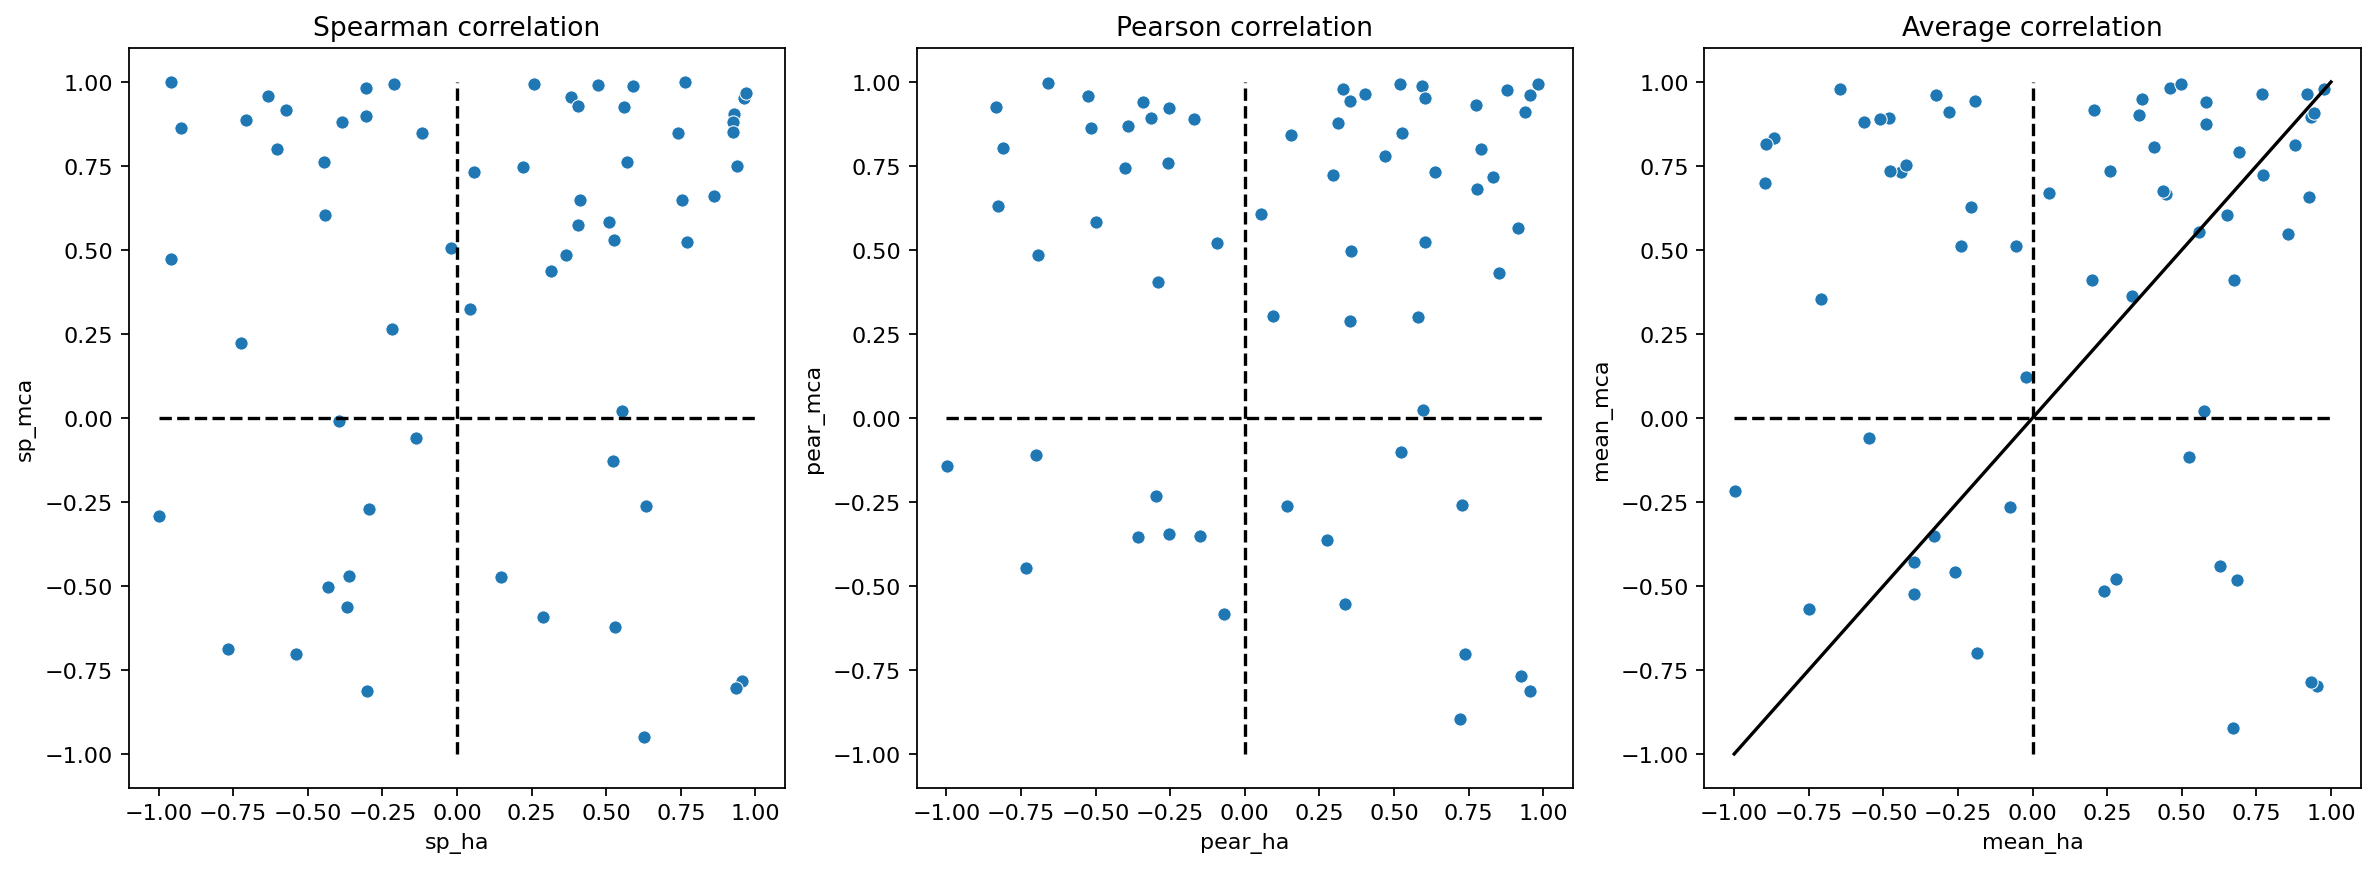

In [561]:
mpl.rcdefaults()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
sns.scatterplot(corr_df, x='sp_ha', y='sp_mca', ax=ax[0])
ax[0].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[0].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[0].set_title('Spearman correlation')
ax[0].grid(False)

sns.scatterplot(corr_df, x='pear_ha', y='pear_mca', ax=ax[1])
ax[1].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[1].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[1].set_title('Pearson correlation')
ax[1].grid(False)

sns.scatterplot(corr_df, x='mean_ha', y='mean_mca', ax=ax[2])
ax[2].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[2].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[2].plot([-1, 1], [-1, 1], '-', color='black')
ax[2].set_title('Average correlation')
ax[2].grid(False)

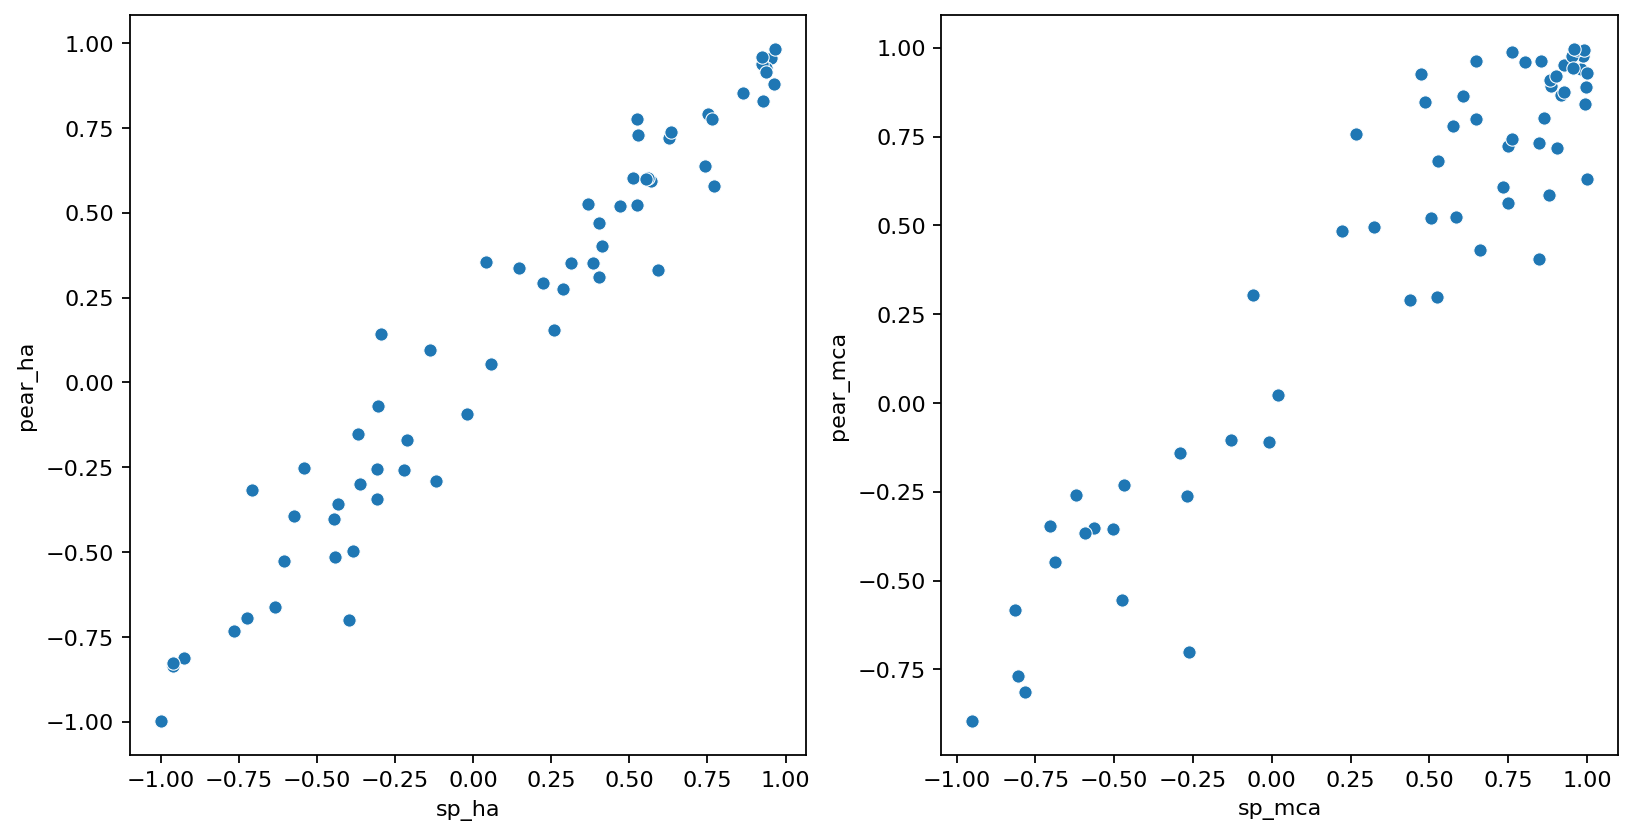

In [562]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
sns.scatterplot(x=corr_df['sp_ha'], y=corr_df['pear_ha'], ax=ax[0])
ax[0].grid(False)

sns.scatterplot(corr_df, x=corr_df['sp_mca'], y=corr_df['pear_mca'], ax=ax[1])
ax[1].grid(False)

## Select a threashold

In [563]:
corr_df['label'] = 'Zero'
# corr_df.loc[corr_df['mean_mca'] < 0, 'label'] = 'human-specific'
# corr_df.loc[(corr_df['corr_diff'] > 0) & ~(corr_df['mean_mca'] < 0), 'label'] = 'maybe human-specific'
# corr_df.loc[(corr_df['corr_diff'] < 0) & (corr_df['corr_diff'] >= -0.5) & ~(corr_df['mean_mca'] < 0), 'label'] = 'maybe age-specific'
# corr_df.loc[(corr_df['corr_diff'] < -0.5) & ~(corr_df['mean_mca'] < 0), 'label'] = 'age-specific'

corr_df.loc[corr_df['pear_diff'] > 0.5, 'label'] = 'human-specific'
corr_df.loc[(corr_df['pear_diff'] > 0) & (corr_df['pear_diff'] <= 0.5), 'label'] = 'maybe human-specific'
corr_df.loc[(corr_df['pear_diff'] < 0) & (corr_df['pear_diff'] >= -0.5), 'label'] = 'maybe age-specific'
corr_df.loc[corr_df['pear_diff'] < -0.5, 'label'] = 'age-specific'

corr_df.label.value_counts()

label
age-specific            25
maybe age-specific      17
maybe human-specific    11
human-specific          10
Name: count, dtype: int64

In [564]:
gene_sets = dict()
for label in corr_df_real.label.unique():
  gene_sets[label] = corr_df_real[corr_df_real.label == label].index.to_list()

for group, genes in gene_sets.items():
  print(f'{group}: {genes}')

age-specific: ['LDHB', 'PPP1CC', 'NRXN2', 'FBXO9', 'COTL1', 'NDUFB10', 'ST3GAL5', 'ASAP2', 'SYNGAP1', 'NRXN1', 'ERC1', 'CX3CL1', 'LPL', 'ATP1A3', 'GAD1', 'CLSTN1', 'PCP4', 'ZNF706', 'GNAI1', 'EIF1B', 'ZBTB18', 'SCN3B', 'PSMB7']
maybe age-specific: ['ZBTB46', 'ETFB', 'DLGAP4', 'MAP1LC3B', 'GPX4', 'ID2', 'LHX2', 'EIF3L', 'IGSF21', 'CD47', 'SULF2', 'NUAK1', 'PDE1A', 'MACF1', 'NDUFB7', 'CHST10', 'CAMLG', 'ALCAM']
maybe human-specific: ['PPA1', 'OLA1', 'ECSIT', 'GDE1', 'KIF21B', 'VAT1L', 'MAZ', 'CALR', 'EEF1G', 'PTPRK', 'TRIR', 'PES1', 'UBE2V1']
human-specific: ['MRPL51', 'IGFBP6', 'RGS2', 'TMED3', 'IGFBP2', 'KLHL2', 'TCEAL4', 'AMZ2', 'ASAH1']


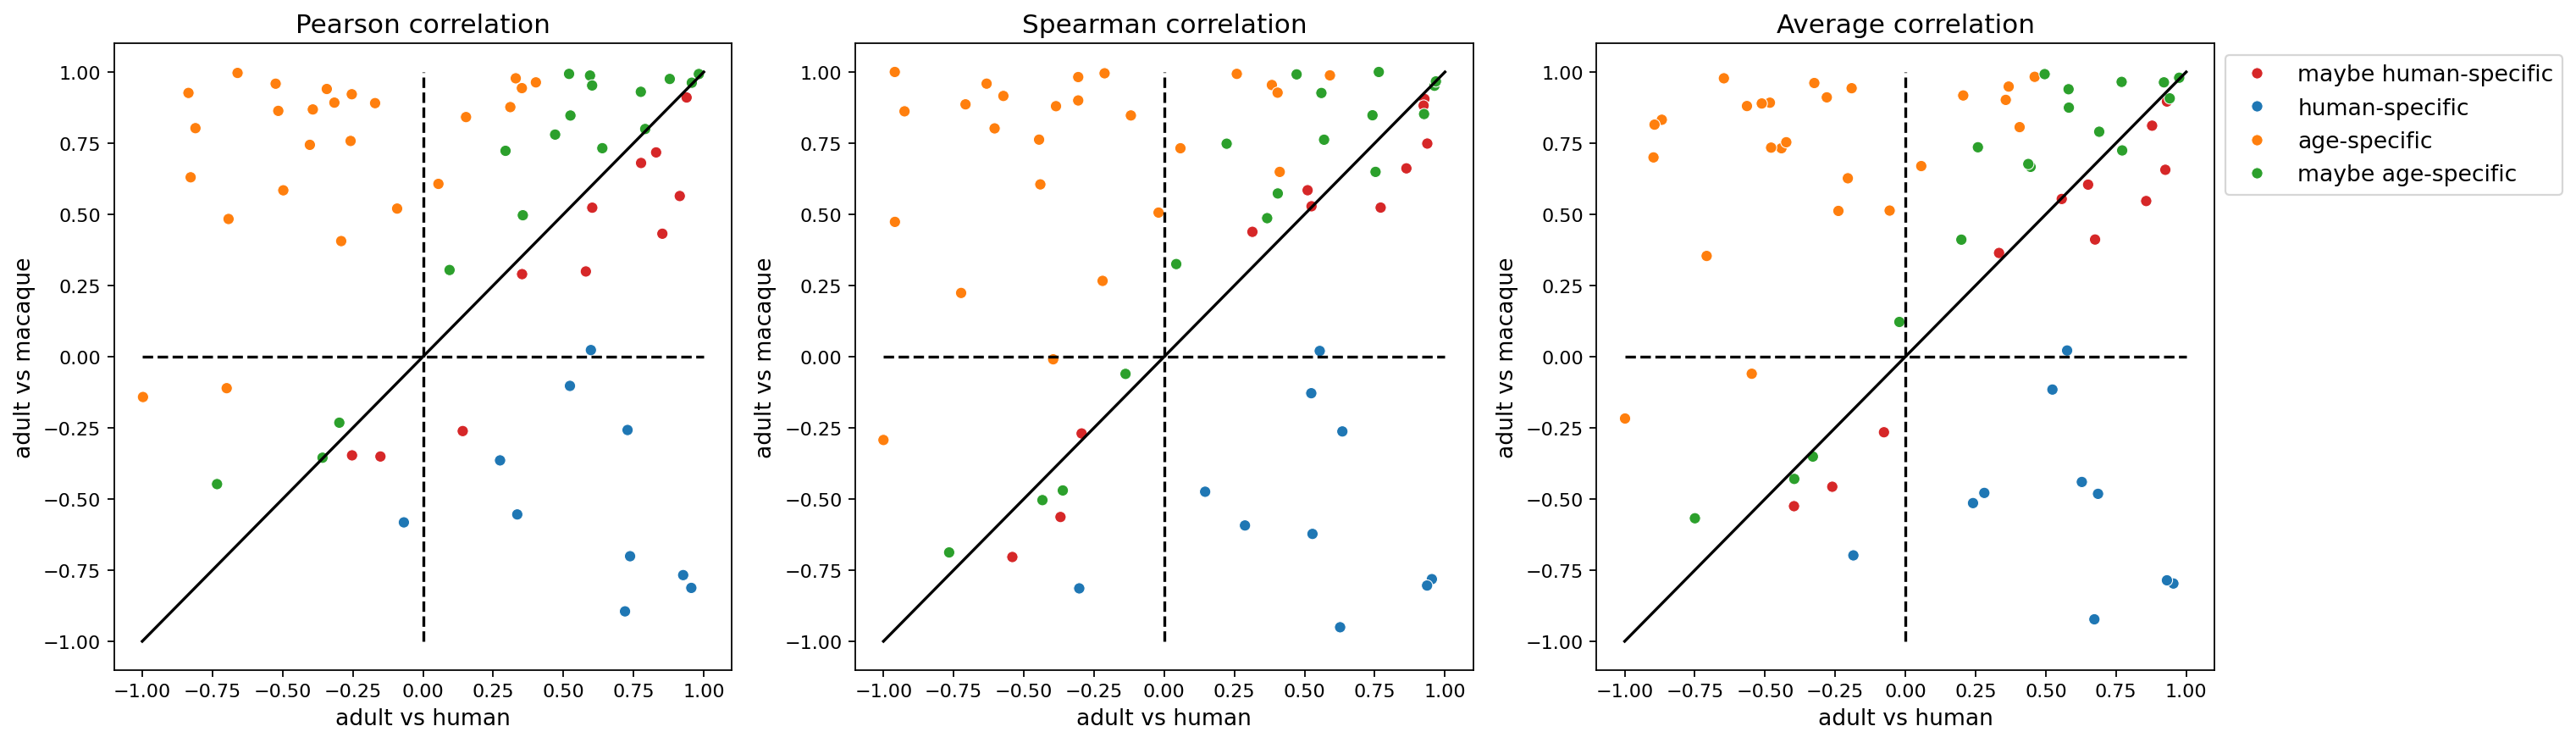

In [565]:
mpl.rcdefaults()

fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=80)
color_dict_labels = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

sns.scatterplot(corr_df, x='pear_ha', y='pear_mca', ax=ax[0], hue='label', palette=color_dict_labels)
ax[0].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[0].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[0].plot([-1, 1], [-1, 1], '-', color='black')
ax[0].set_title('Pearson correlation', fontsize=14)
ax[0].set_ylabel('adult vs macaque', fontsize=12)
ax[0].set_xlabel('adult vs human', fontsize=12)
ax[0].grid(False)
ax[0].get_legend().remove()

sns.scatterplot(corr_df, x='sp_ha', y='sp_mca', ax=ax[1], hue='label', palette=color_dict_labels)
ax[1].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[1].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[1].plot([-1, 1], [-1, 1], '-', color='black')
ax[1].set_title('Spearman correlation', fontsize=14)
ax[1].set_ylabel('adult vs macaque', fontsize=12)
ax[1].set_xlabel('adult vs human', fontsize=12)
ax[1].grid(False)
ax[1].get_legend().remove()

sns.scatterplot(corr_df, x='mean_ha', y='mean_mca', ax=ax[2], hue='label', palette=color_dict_labels)
ax[2].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[2].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[2].plot([-1, 1], [-1, 1], '-', color='black')
ax[2].set_title('Average correlation', fontsize=14)
ax[2].set_ylabel('adult vs macaque', fontsize=12)
ax[2].set_xlabel('adult vs human', fontsize=12)
ax[2].grid(False)
ax[2].legend(fontsize=8, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
plt.show()

Text(0, 0.5, 'corr(adult vs newborn human) - corr(adult vs newborn macaque)')

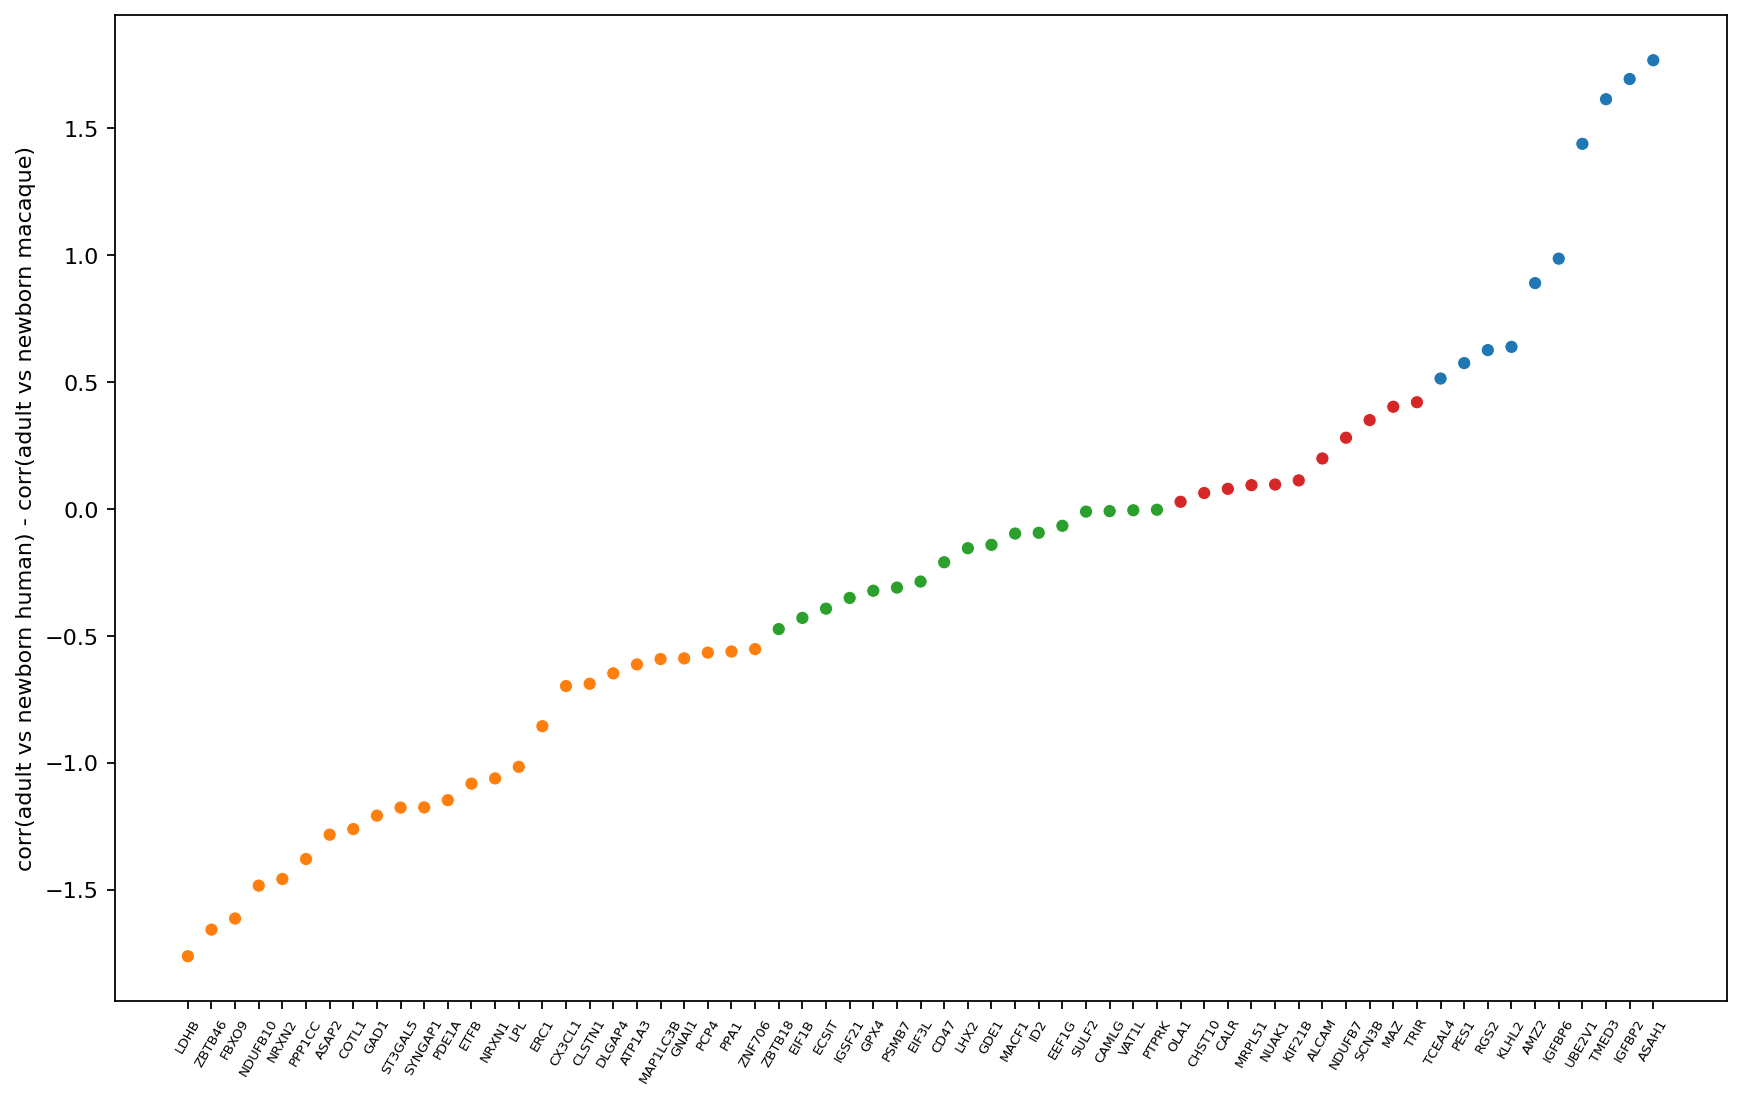

In [566]:
fig = plt.figure(figsize=(13, 8), dpi=80)
corr_df = corr_df.sort_values(by='pear_diff')
color_dict_labels = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}
sns.scatterplot(corr_df['pear_diff'], color=corr_df.label.map(color_dict_labels))
plt.xticks(rotation=60, fontsize=6);
plt.ylabel("corr(adult vs newborn human) - corr(adult vs newborn macaque)", fontsize=10)

In [567]:
corr_df.label.to_csv('results/age_hs_groups.csv')

In [568]:
clust_labels = pd.read_csv('results/human_clusters_edgeR_6.csv', index_col=0)['0']
clust_labels.head()

PPA1        0
AMZ2        0
GNAI1       0
MAP1LC3B    0
FBXO9       0
Name: 0, dtype: int64

In [569]:
import plotly
merge_df = corr_df.label.to_frame().merge(clust_labels, left_index=True, right_index=True)
merge_df.columns = ['age_hs', 'cluster']
merge_df.head()

age_hs  cluster
LDHB     age-specific        5
ZBTB46   age-specific        4
FBXO9    age-specific        0
NDUFB10  age-specific        5
NRXN2    age-specific        4

In [570]:
sankey_df = merge_df.groupby('cluster').value_counts()
sankey_df.head(5)

cluster  age_hs              
0        age-specific            6
         human-specific          2
         maybe human-specific    1
1        maybe age-specific      4
         maybe human-specific    2
Name: count, dtype: int64

In [571]:
from matplotlib.colors import to_hex

source_label = list(range(len(clust_labels.unique())))
target_label = ['human-specific', 'age-specific', 'maybe human-specific', 'maybe age-specific']
sankey_label = source_label + target_label

cmap = plt.get_cmap('Set3')
hex_colors = list(map(to_hex, cmap.colors))
source_color = hex_colors[:len(source_label)]
target_color = [to_hex(color_dict_labels[key]) for key in target_label]

source_list = []
target_list = []
value_list = []
link_color_sc = []
link_color_tar = []

for sc_lab, tg_lab in sankey_df.index.to_list():
    source_list.append(sankey_label.index(sc_lab))
    target_list.append(sankey_label.index(tg_lab))
    value_list.append(sankey_df.loc[sc_lab, tg_lab])
    link_color_sc.append(hex_colors[sc_lab])
    link_color_tar.append(to_hex(color_dict_labels[tg_lab]))

source_label = list(map(lambda x: f'clust{x}', source_label))
sankey_label = source_label + target_label

In [572]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = sankey_label,
      color = source_color + target_color
    ),
    link = dict(
      source = source_list, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target_list,
      value = value_list,
      color=link_color_sc
  ))])

fig.update_layout(title_text="Sankey Diagram", font_size=10)
fig.show()

## Functional analysis

In [573]:
common_hs_genes, len(common_hs_genes)

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RGS2', 'SCN3B', 'ST3GAL5', 'SULF2',
        'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1', 'VAT1L', 'ZBTB18',
        'ZBTB46', 'ZNF706'],
       dtype='object'),
 63)

In [574]:
gene_clust = list()
enrich_results = list()
geneset_dict = dict()

for group in ['age-specific', 'maybe age-specific', 'maybe human-specific', 'human-specific']:
    gene_set = corr_df[corr_df.label == group].index.to_list()
    gene_clust.append(GeneCluster(gene_set, group, group, background_genes))
    geneset_dict[group] = gene_set
    time.sleep(1)

In [575]:
print(geneset_dict)

{'age-specific': ['LDHB', 'ZBTB46', 'FBXO9', 'NDUFB10', 'NRXN2', 'PPP1CC', 'ASAP2', 'COTL1', 'GAD1', 'ST3GAL5', 'SYNGAP1', 'PDE1A', 'ETFB', 'NRXN1', 'LPL', 'ERC1', 'CX3CL1', 'CLSTN1', 'DLGAP4', 'ATP1A3', 'MAP1LC3B', 'GNAI1', 'PCP4', 'PPA1', 'ZNF706'], 'maybe age-specific': ['ZBTB18', 'EIF1B', 'ECSIT', 'IGSF21', 'GPX4', 'PSMB7', 'EIF3L', 'CD47', 'LHX2', 'GDE1', 'MACF1', 'ID2', 'EEF1G', 'SULF2', 'CAMLG', 'VAT1L', 'PTPRK'], 'maybe human-specific': ['OLA1', 'CHST10', 'CALR', 'MRPL51', 'NUAK1', 'KIF21B', 'ALCAM', 'NDUFB7', 'SCN3B', 'MAZ', 'TRIR'], 'human-specific': ['TCEAL4', 'PES1', 'RGS2', 'KLHL2', 'AMZ2', 'IGFBP6', 'UBE2V1', 'TMED3', 'IGFBP2', 'ASAH1']}


## GO_Biological_Process_2023

In [576]:
db_name = 'GO_Biological_Process_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [577]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Vocal Learning (GO:0042297)                            1  0.000059   
Imitative Learning (GO:0098596)                        2  0.000059   
Auditory Behavior (GO:0031223)                         3  0.000059   
Learned Vocalization Behavior Or Vocal Learning...     4  0.000059   
Postsynaptic Density Assembly (GO:0097107)             5  0.000059   

                                                       Z-score  \
Term                                                             
Vocal Learning (GO:0042297)                         337.521739   
Imitative Learning (GO:0098596)                     337.521739   
Auditory Behavior (GO:0031223)                      337.521739   
Learned Vocalization Behavior Or Vocal Learning...  337.521739   
Postsynaptic Density Assembly (GO:0097107)          337.521739   

                                                    Combined score  \
Term                                                                 
Vocal Learning (GO:0042297)                            3286.233637   
Imitative Learning (GO:0098596)                        3286.233637   
Auditory Behavior (GO:0031223)                         3286.233637   
Learned Vocalization Behavior Or Vocal Learning...     3286.233637   
Postsynaptic Density Assembly (GO:0097107)             3286.233637   

                                                   Overlapping genes  \
Term                                                                   
Vocal Learning (GO:0042297)                           [NRXN1, NRXN2]   
Imitative Learning (GO:0098596)                       [NRXN1, NRXN2]   
Auditory Behavior (GO:0031223)                        [NRXN1, NRXN2]   
Learned Vocalization Behavior Or Vocal Learning...    [NRXN1, NRXN2]   
Postsynaptic Density Assembly (GO:0097107)            [NRXN1, NRXN2]   

                                                    Adjusted P-value  \
Term                                                                   
Vocal Learning (GO:0042297)                                  0.00351   
Imitative Learning (GO:0098596)                              0.00351   
Auditory Behavior (GO:0031223)                               0.00351   
Learned Vocalization Behavior Or Vocal Learning...           0.00351   
Postsynaptic Density Assembly (GO:0097107)                   0.00351   

                                                    Old p-value  \
Term                                                              
Vocal Learning (GO:0042297)                                   0   
Imitative Learning (GO:0098596)                               0   
Auditory Behavior (GO:0031223)                                0   
Learned Vocalization Behavior Or Vocal Learning...            0   
Postsynaptic Density Assembly (GO:0097107)                    0   

                                                    Old adjusted p-value  \
Term                                                                       
Vocal Learning (GO:0042297)                                            0   
Imitative Learning (GO:0098596)                                        0   
Auditory Behavior (GO:0031223)                                         0   
Learned Vocalization Behavior Or Vocal Learning...                     0   
Postsynaptic Density Assembly (GO:0097107)                             0   

                                                    num_overlap_genes  \
Term                                                                    
Vocal Learning (GO:0042297)                                         2   
Imitative Learning (GO:0098596)                                     2   
Auditory Behavior (GO:0031223)                                      2   
Learned Vocalization Behavior Or Vocal Learning...                  2   
Postsynaptic Density Assembly (GO:0097107)                          2   

                                                    neg_log10(p_adj)  \
Term      

In [578]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

33

In [579]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

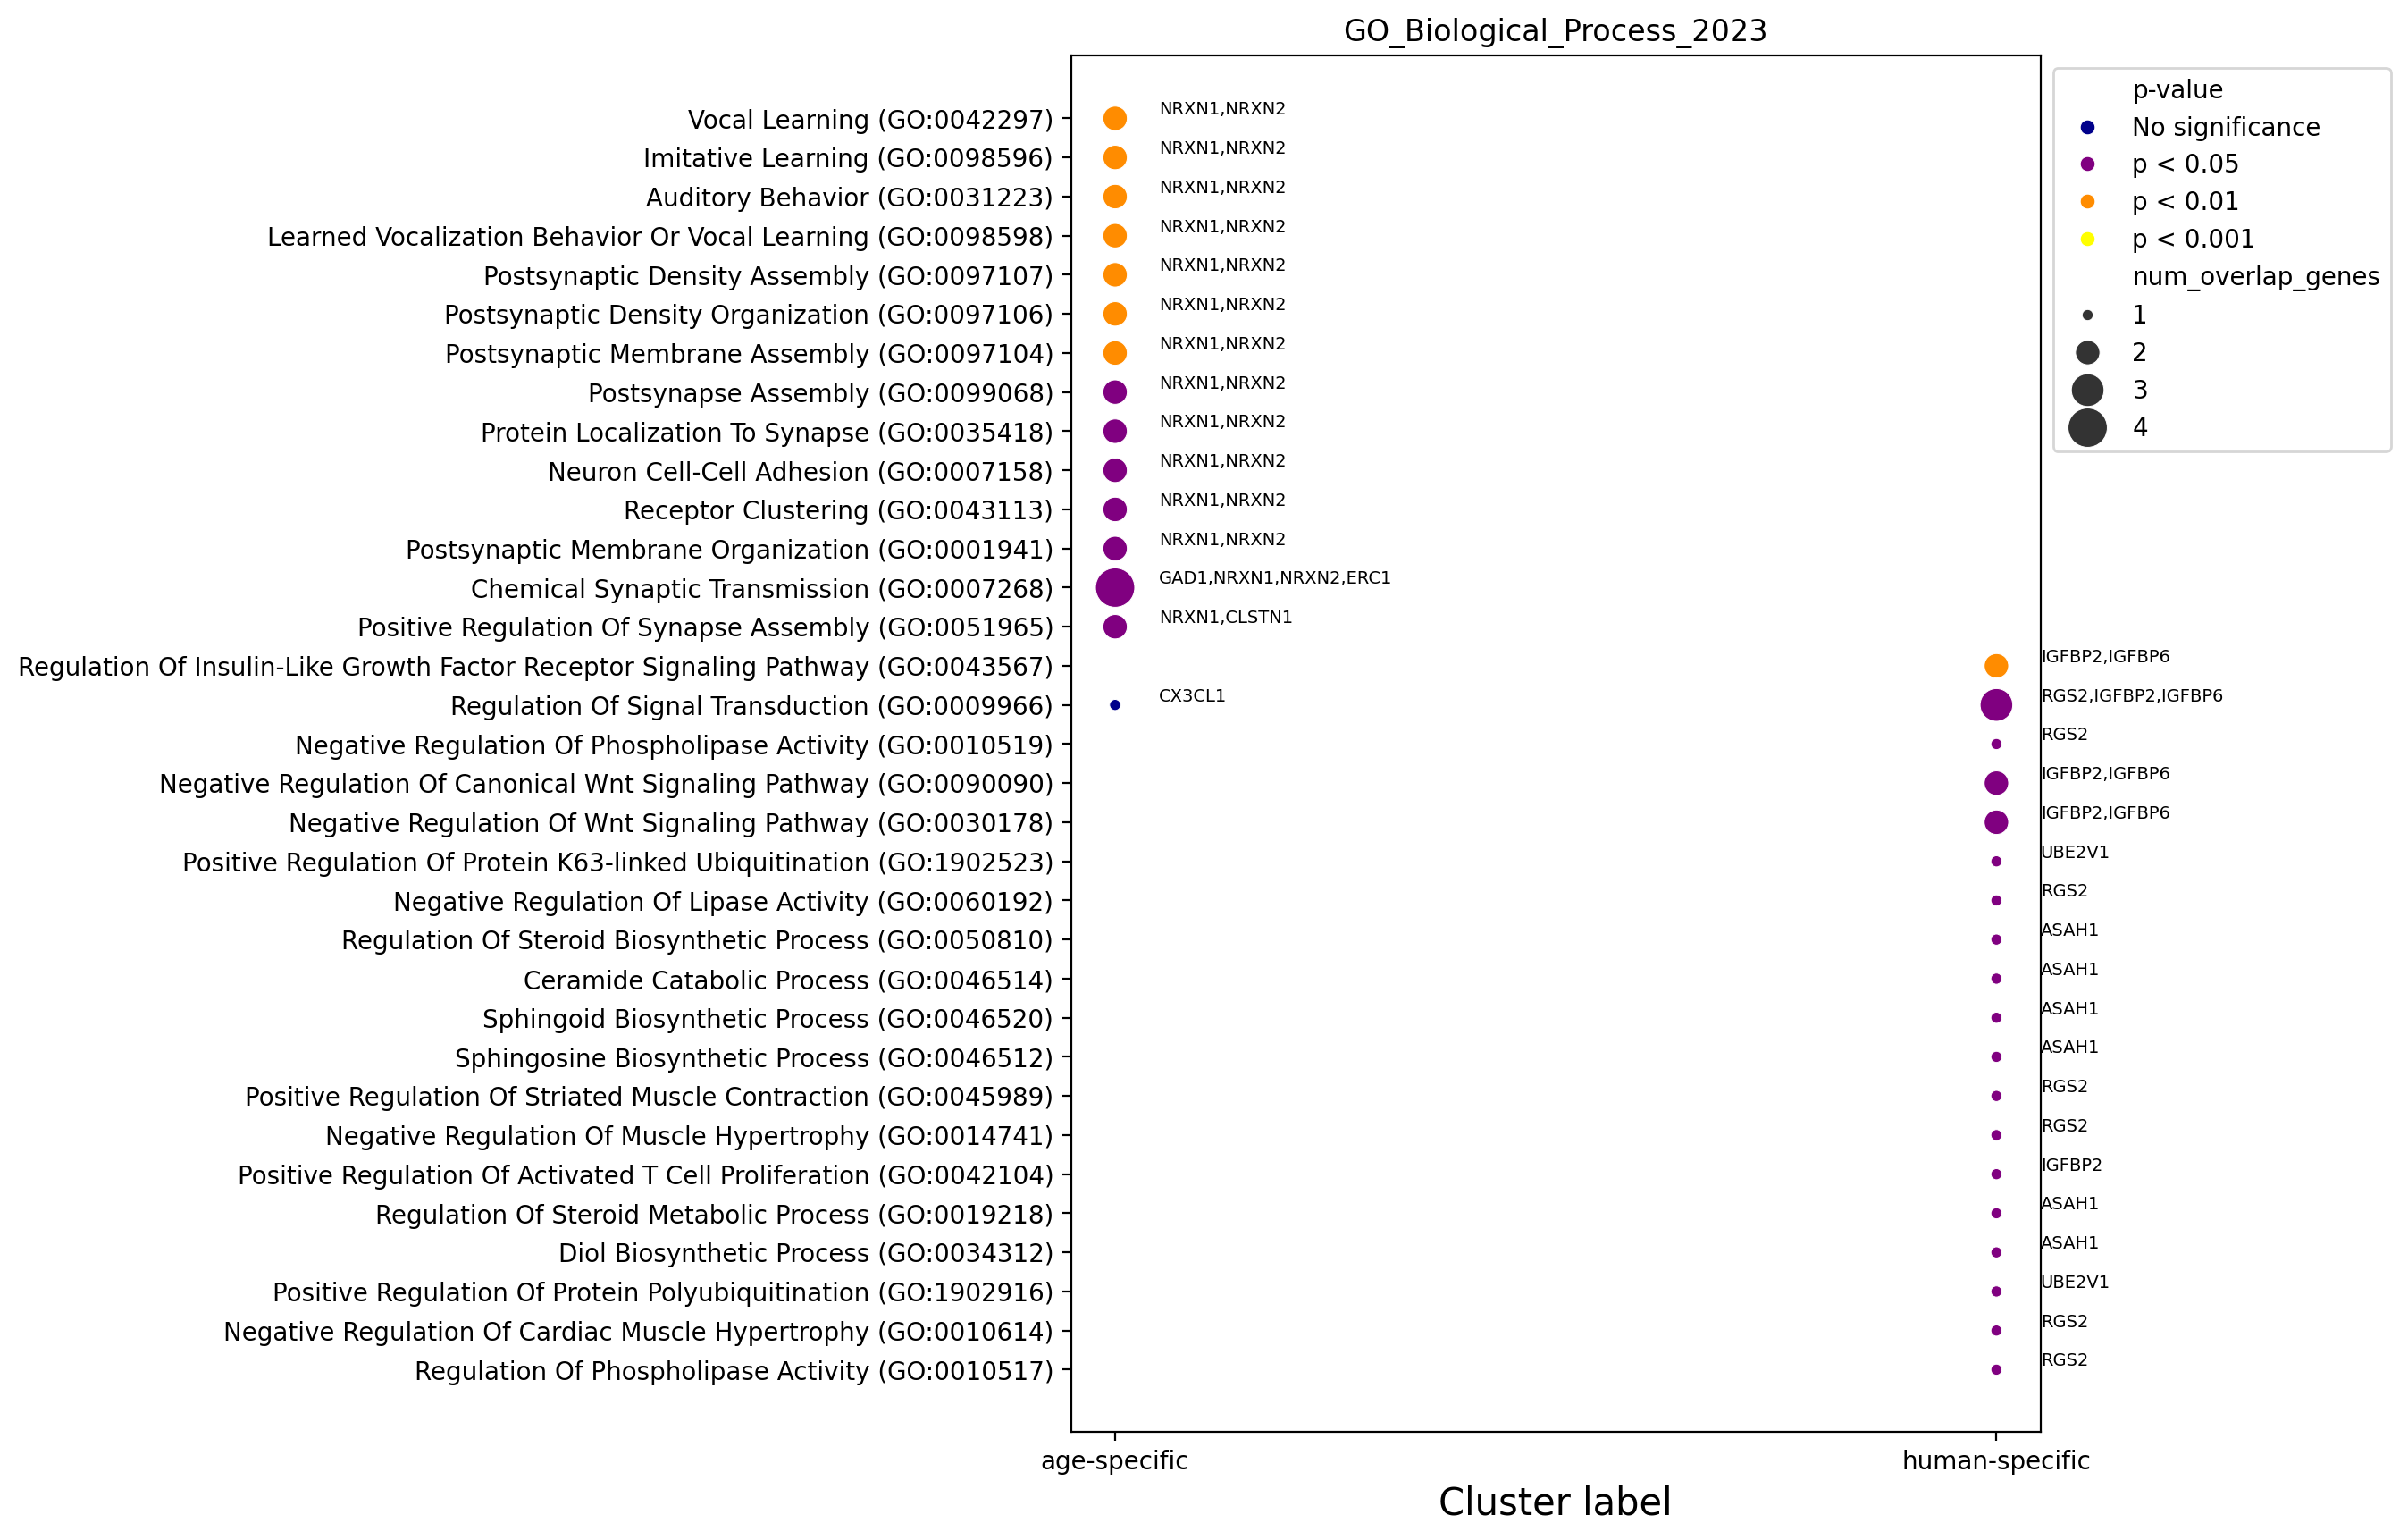

In [580]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

x_ticks = ax.get_xticklabels()
x_ticks_pos = {text_obj.get_text():text_obj.get_position()[0] for text_obj in x_ticks}

y_ticks = ax.get_yticklabels()
y_ticks_pos = {text_obj.get_text():text_obj.get_position()[1] for text_obj in y_ticks}

text_df = enrich_res_plot.reset_index().copy()
for i in range(text_df.shape[0]):
    text_df_sub = text_df.iloc[i, :].to_dict()
    x=x_ticks_pos[text_df_sub['cluster_label']]
    y=y_ticks_pos[text_df_sub['Term']]
    text = ','.join(text_df_sub['Overlapping genes'])
    #ax.annotate(text, (x, y), xycoords='data', xytext=(x + 0.1, y - 0.1), textcoords='data', arrowprops={'arrowstyle': '-'})
    ax.text(x + 0.05, y - 0.1, text, fontsize=7)

## GO_Molecular_Function_2023

In [581]:
db_name = 'GO_Molecular_Function_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [582]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Calcium Channel Regulator Activity (GO:0005246)        1  0.001466   
Lactate Dehydrogenase Activity (GO:0004457)            2  0.003209   
Amyloid-Beta Binding (GO:0001540)                      3  0.008614   
Chemokine Activity (GO:0008009)                        4  0.009598   
P-type Potassium Transmembrane Transporter Acti...     5  0.009598   

                                                       Z-score  \
Term                                                             
Calcium Channel Regulator Activity (GO:0005246)      42.114130   
Lactate Dehydrogenase Activity (GO:0004457)                inf   
Amyloid-Beta Binding (GO:0001540)                    15.989648   
Chemokine Activity (GO:0008009)                     161.729167   
P-type Potassium Transmembrane Transporter Acti...  161.729167   

                                                    Combined score  \
Term                                                                 
Calcium Channel Regulator Activity (GO:0005246)         274.803712   
Lactate Dehydrogenase Activity (GO:0004457)                    inf   
Amyloid-Beta Binding (GO:0001540)                        76.021447   
Chemokine Activity (GO:0008009)                         751.426288   
P-type Potassium Transmembrane Transporter Acti...      751.426288   

                                                   Overlapping genes  \
Term                                                                   
Calcium Channel Regulator Activity (GO:0005246)       [NRXN1, NRXN2]   
Lactate Dehydrogenase Activity (GO:0004457)                   [LDHB]   
Amyloid-Beta Binding (GO:0001540)                   [CLSTN1, ATP1A3]   
Chemokine Activity (GO:0008009)                             [CX3CL1]   
P-type Potassium Transmembrane Transporter Acti...          [ATP1A3]   

                                                    Adjusted P-value  \
Term                                                                   
Calcium Channel Regulator Activity (GO:0005246)             0.069585   
Lactate Dehydrogenase Activity (GO:0004457)                 0.069585   
Amyloid-Beta Binding (GO:0001540)                           0.069585   
Chemokine Activity (GO:0008009)                             0.069585   
P-type Potassium Transmembrane Transporter Acti...          0.069585   

                                                    Old p-value  \
Term                                                              
Calcium Channel Regulator Activity (GO:0005246)               0   
Lactate Dehydrogenase Activity (GO:0004457)                   0   
Amyloid-Beta Binding (GO:0001540)                             0   
Chemokine Activity (GO:0008009)                               0   
P-type Potassium Transmembrane Transporter Acti...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Calcium Channel Regulator Activity (GO:0005246)                        0   
Lactate Dehydrogenase Activity (GO:0004457)                            0   
Amyloid-Beta Binding (GO:0001540)                                      0   
Chemokine Activity (GO:0008009)                                        0   
P-type Potassium Transmembrane Transporter Acti...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Calcium Channel Regulator Activity (GO:0005246)                     2   
Lactate Dehydrogenase Activity (GO:0004457)                         1   
Amyloid-Beta Binding (GO:0001540)                                   2   
Chemokine Activity (GO:0008009)                                     1   
P-type Potassium Transmembrane Transporter Acti...                  1   

                                                    neg_log10(p_adj)  \
Term      

In [583]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

4

In [584]:
enrich_res[enrich_res.cluster_label == 5]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [585]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

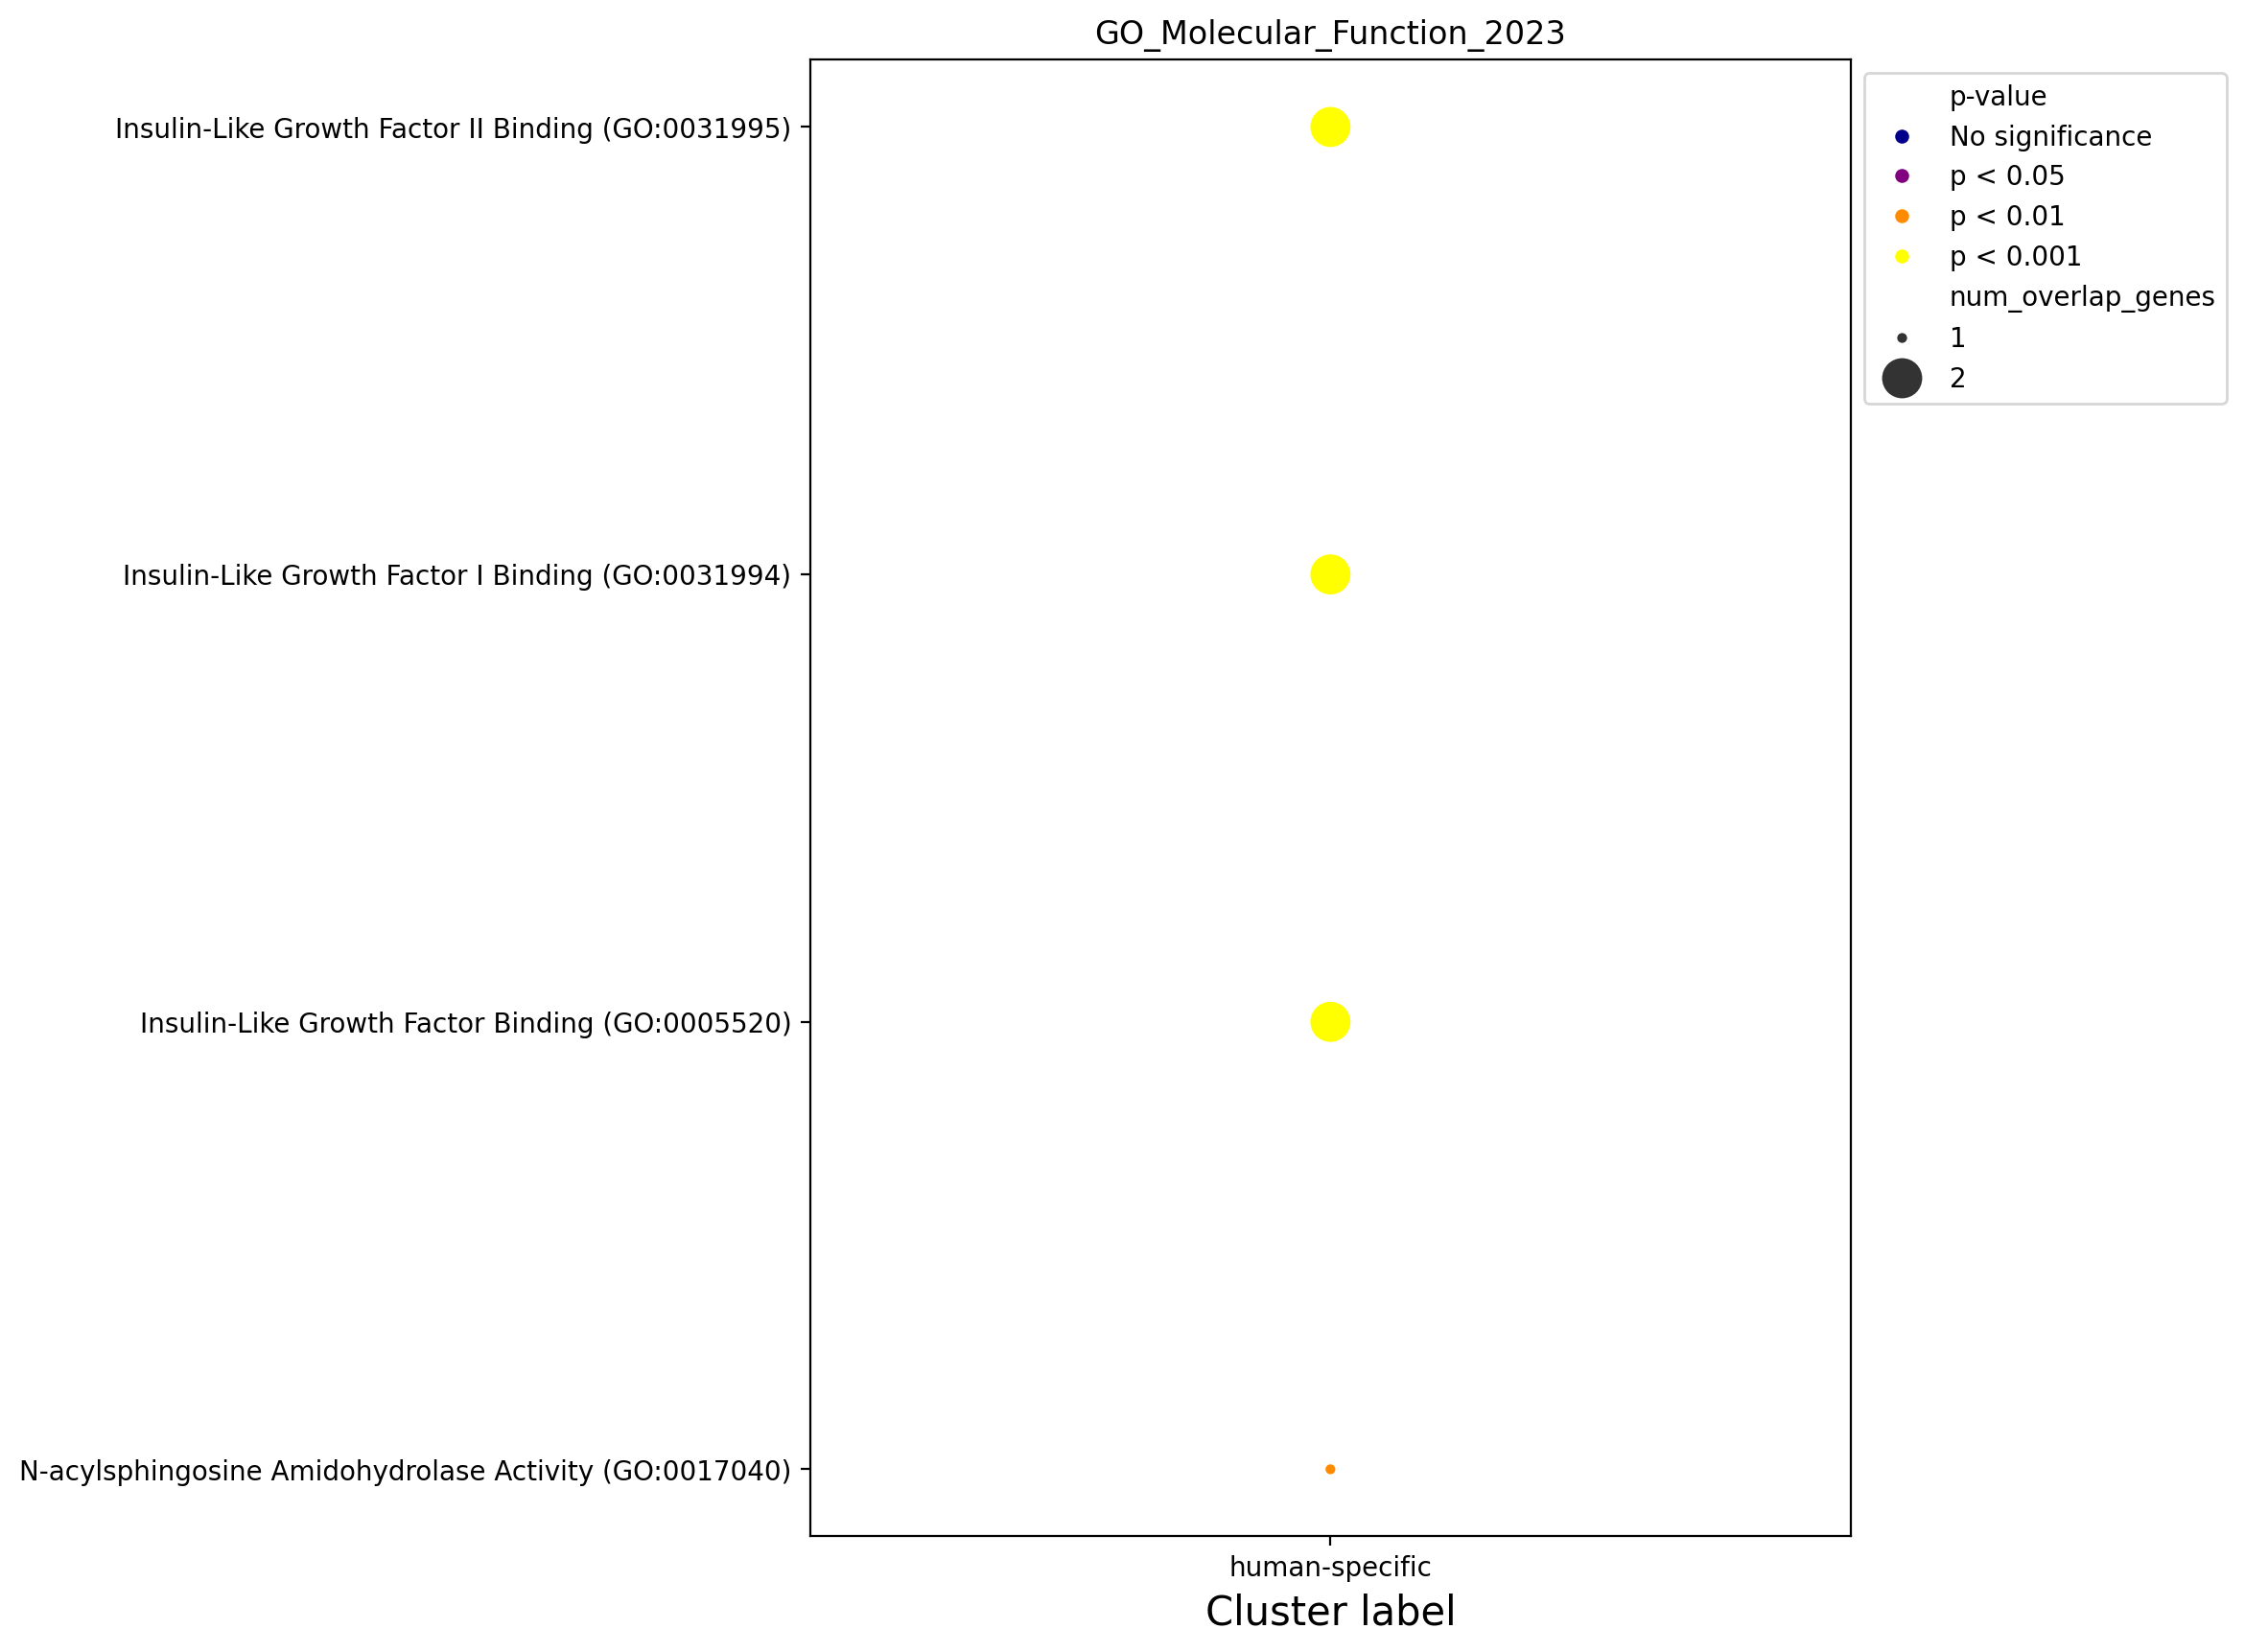

In [586]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## GO_Cellular_Component_2023

In [587]:
db_name = 'GO_Cellular_Component_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [588]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Vesicle (GO:0031982)                                   1  0.006403   8.913753   
Cortical Cytoskeleton (GO:0030863)                     2  0.006477  18.669082   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...     3  0.015947  80.843750   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...     4  0.015947  80.843750   
Sodium:Potassium-Exchanging ATPase Complex (GO:...     5  0.019108  64.666667   

                                                    Combined score  \
Term                                                                 
Vesicle (GO:0031982)                                     45.023388   
Cortical Cytoskeleton (GO:0030863)                       94.083754   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...      334.568150   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...      334.568150   
Sodium:Potassium-Exchanging ATPase Complex (GO:...      255.929395   

                                                        Overlapping genes  \
Term                                                                        
Vesicle (GO:0031982)                                [GAD1, NRXN1, ATP1A3]   
Cortical Cytoskeleton (GO:0030863)                          [COTL1, ERC1]   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                 [GAD1]   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                 [GAD1]   
Sodium:Potassium-Exchanging ATPase Complex (GO:...               [ATP1A3]   

                                                    Adjusted P-value  \
Term                                                                   
Vesicle (GO:0031982)                                        0.144676   
Cortical Cytoskeleton (GO:0030863)                          0.144676   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          0.144676   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          0.144676   
Sodium:Potassium-Exchanging ATPase Complex (GO:...          0.144676   

                                                    Old p-value  \
Term                                                              
Vesicle (GO:0031982)                                          0   
Cortical Cytoskeleton (GO:0030863)                            0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...            0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...            0   
Sodium:Potassium-Exchanging ATPase Complex (GO:...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Vesicle (GO:0031982)                                                   0   
Cortical Cytoskeleton (GO:0030863)                                     0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                     0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                     0   
Sodium:Potassium-Exchanging ATPase Complex (GO:...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Vesicle (GO:0031982)                                                3   
Cortical Cytoskeleton (GO:0030863)                                  2   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                  1   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                  1   
Sodium:Potassium-Exchanging ATPase Complex (GO:...                  1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Vesicle (GO:0031982)                                        0.839602   
Cortical Cytoskeleton (GO:0030863)                          0.839602   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          0.839602   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          0.839602   
S

In [589]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

0

In [590]:
enrich_res[enrich_res.cluster_label == 5]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [591]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_28700\1472615517.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


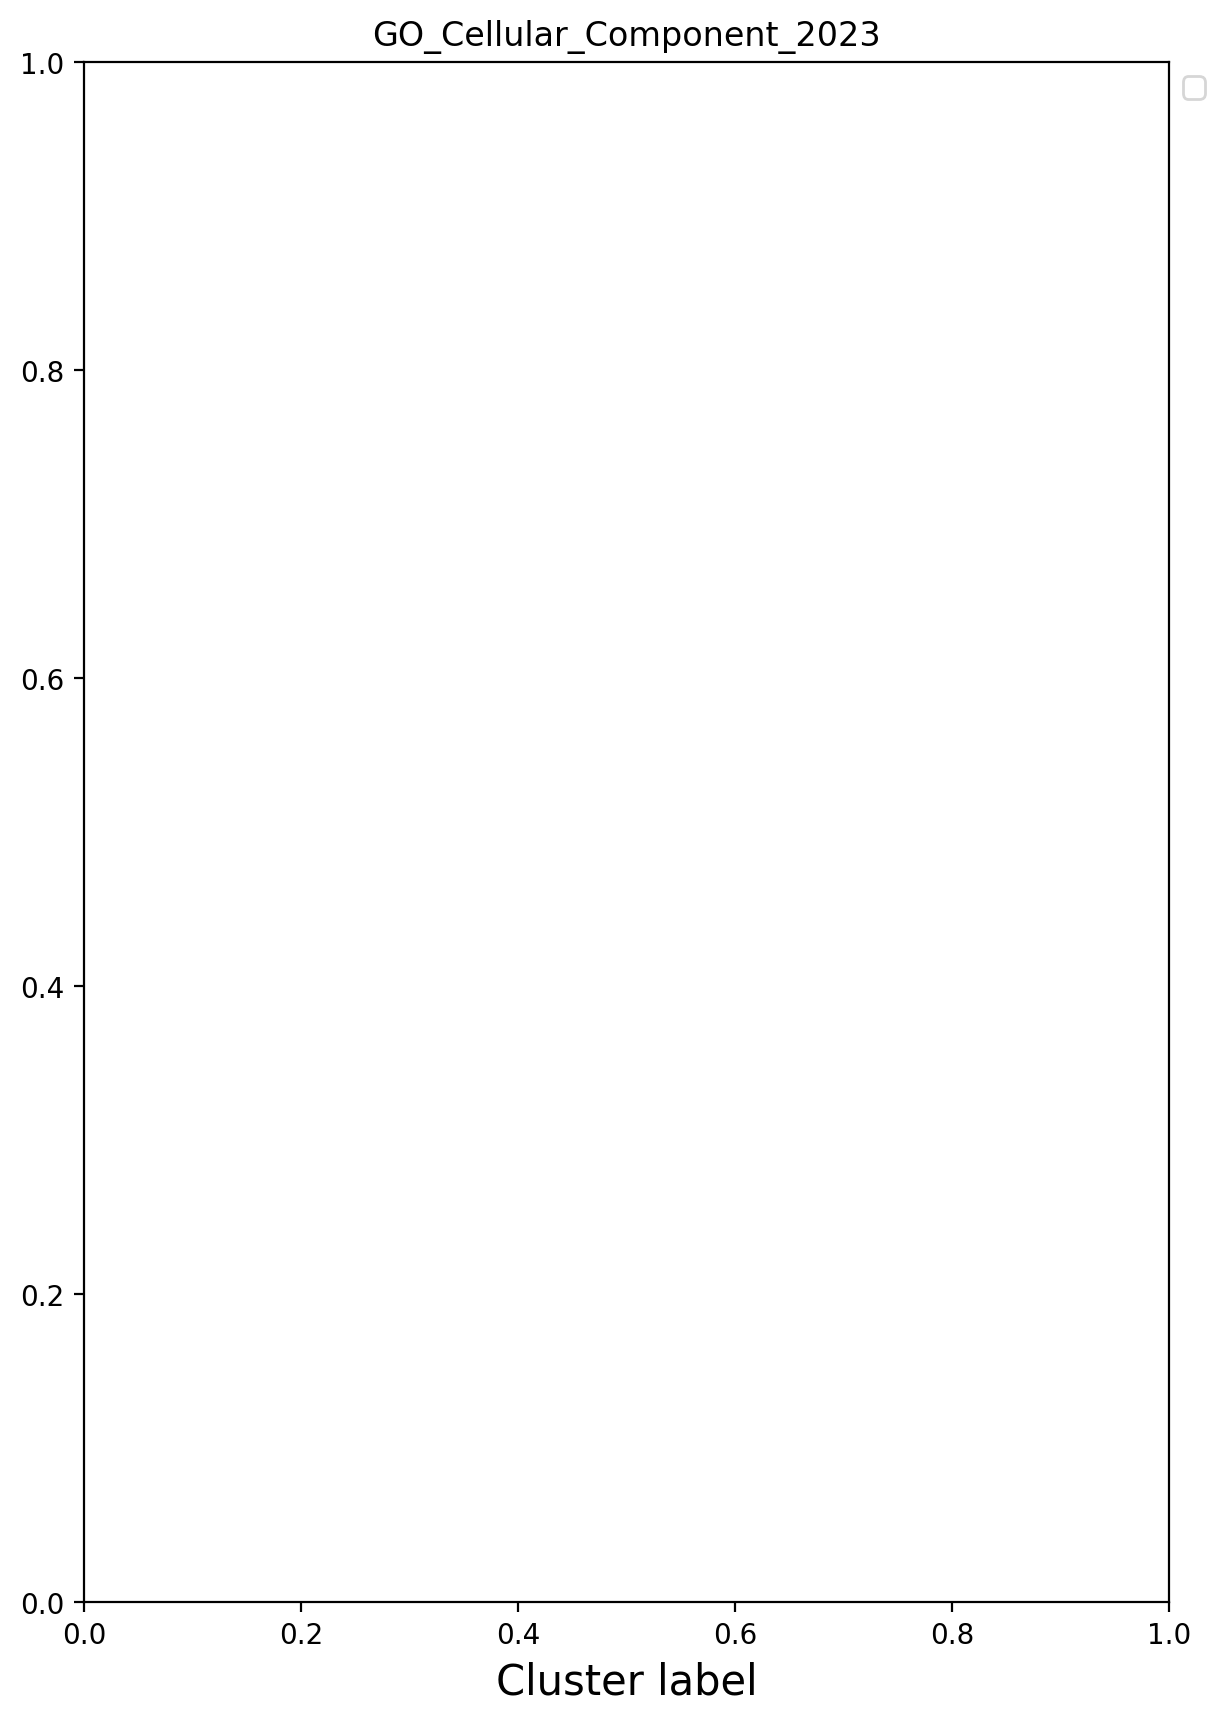

In [592]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## WikiPathway_2023_Human

In [593]:
db_name = 'WikiPathway_2023_Human'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [594]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Disruption Of Postsynaptic Signaling By CNV WP4875     1  0.000091   
Fragile X Syndrome WP4549                              2  0.004179   
Common Pathways Underlying Drug Addiction WP2636       3  0.004624   
Lipid Particles Composition WP3601                     4  0.006409   
Familial Hyperlipidemia Type 2 WP5109                  5  0.009598   

                                                       Z-score  \
Term                                                             
Disruption Of Postsynaptic Signaling By CNV WP4875   42.218182   
Fragile X Syndrome WP4549                            10.452273   
Common Pathways Underlying Drug Addiction WP2636     22.420290   
Lipid Particles Composition WP3601                  323.500000   
Familial Hyperlipidemia Type 2 WP5109               161.729167   

                                                    Combined score  \
Term                                                                 
Disruption Of Postsynaptic Signaling By CNV WP4875      392.951932   
Fragile X Syndrome WP4549                                57.253360   
Common Pathways Underlying Drug Addiction WP2636        120.544165   
Lipid Particles Composition WP3601                     1633.716150   
Familial Hyperlipidemia Type 2 WP5109                   751.426288   

                                                            Overlapping genes  \
Term                                                                            
Disruption Of Postsynaptic Signaling By CNV WP4875    [SYNGAP1, NRXN1, NRXN2]   
Fragile X Syndrome WP4549                           [MAP1LC3B, SYNGAP1, GAD1]   
Common Pathways Underlying Drug Addiction WP2636              [PPP1CC, GNAI1]   
Lipid Particles Composition WP3601                                      [LPL]   
Familial Hyperlipidemia Type 2 WP5109                                   [LPL]   

                                                    Adjusted P-value  \
Term                                                                   
Disruption Of Postsynaptic Signaling By CNV WP4875          0.007621   
Fragile X Syndrome WP4549                                   0.104869   
Common Pathways Underlying Drug Addiction WP2636            0.104869   
Lipid Particles Composition WP3601                          0.104869   
Familial Hyperlipidemia Type 2 WP5109                       0.104869   

                                                    Old p-value  \
Term                                                              
Disruption Of Postsynaptic Signaling By CNV WP4875            0   
Fragile X Syndrome WP4549                                     0   
Common Pathways Underlying Drug Addiction WP2636              0   
Lipid Particles Composition WP3601                            0   
Familial Hyperlipidemia Type 2 WP5109                         0   

                                                    Old adjusted p-value  \
Term                                                                       
Disruption Of Postsynaptic Signaling By CNV WP4875                     0   
Fragile X Syndrome WP4549                                              0   
Common Pathways Underlying Drug Addiction WP2636                       0   
Lipid Particles Composition WP3601                                     0   
Familial Hyperlipidemia Type 2 WP5109                                  0   

                                                    num_overlap_genes  \
Term                                                                    
Disruption Of Postsynaptic Signaling By CNV WP4875                  3   
Fragile X Syndrome WP4549                                           3   
Common Pathways Underlying Drug Addiction WP2636                    2   
Lipid Particles Composition WP3601                                  1   
Familial Hyperlipidemia Type 2 WP5109                               1   

                   

In [595]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

13

In [596]:
enrich_res[enrich_res.cluster_label == 5]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [597]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

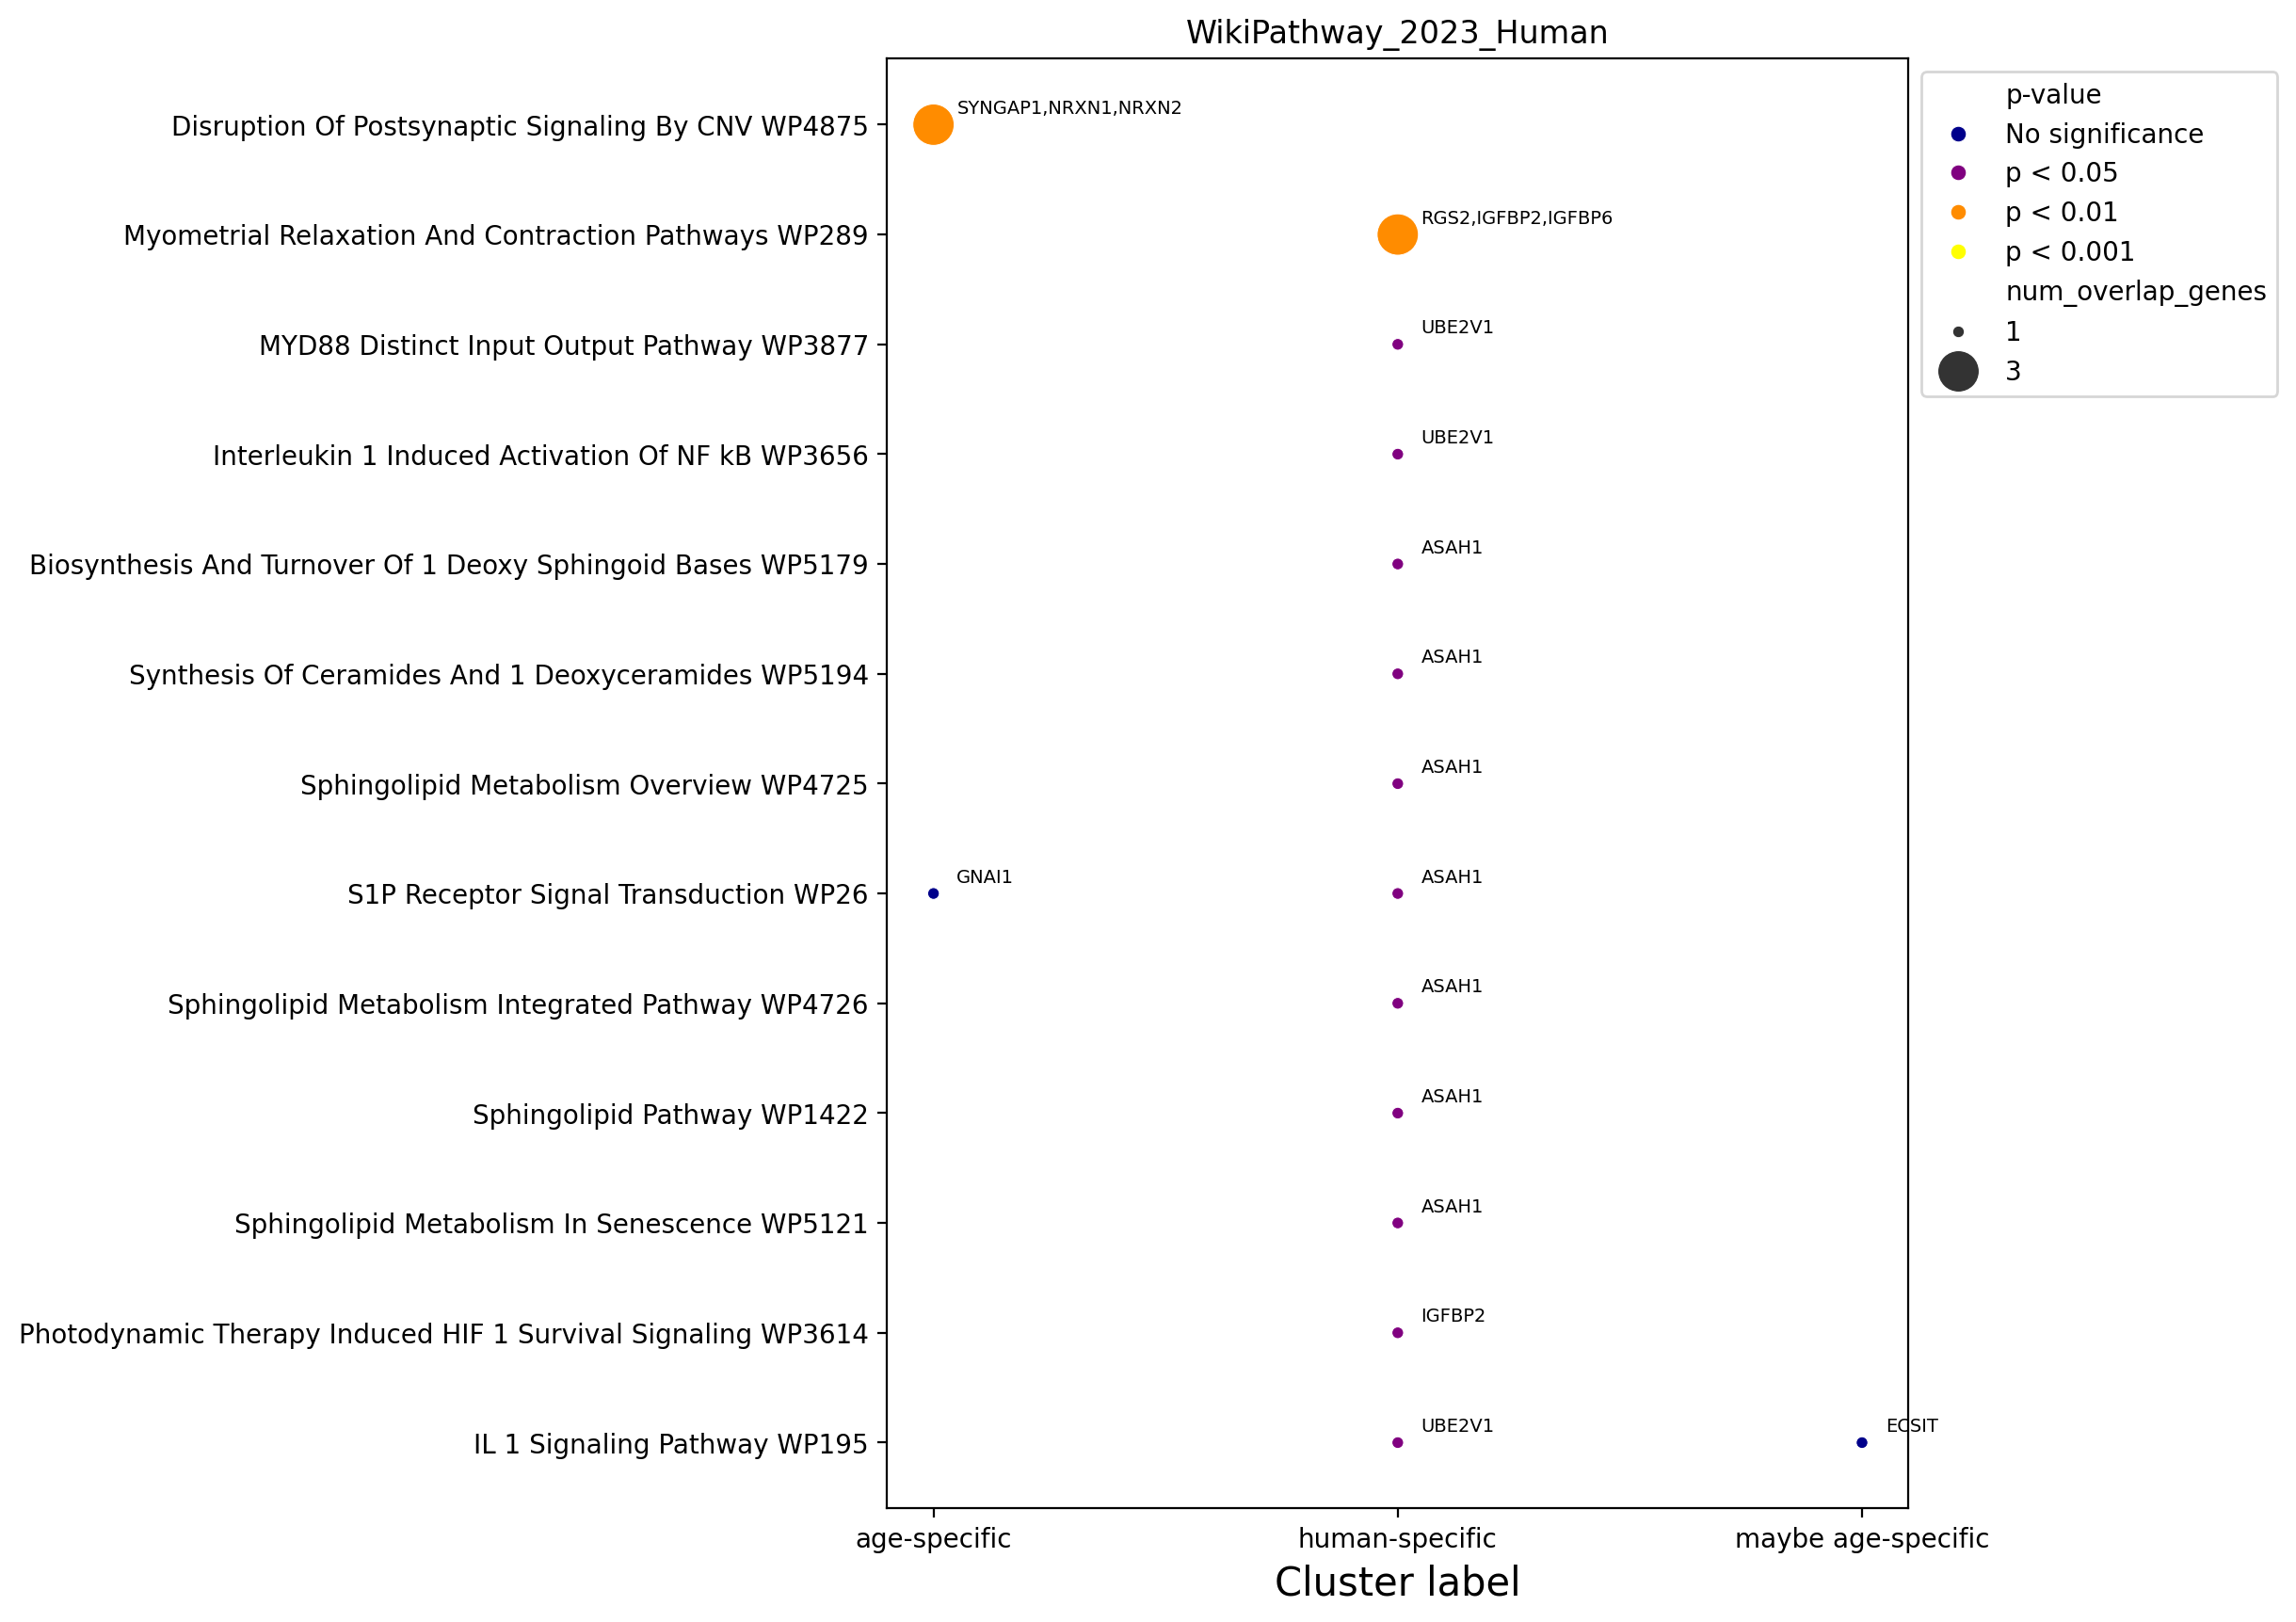

In [598]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

x_ticks = ax.get_xticklabels()
x_ticks_pos = {text_obj.get_text():text_obj.get_position()[0] for text_obj in x_ticks}

y_ticks = ax.get_yticklabels()
y_ticks_pos = {text_obj.get_text():text_obj.get_position()[1] for text_obj in y_ticks}

text_df = enrich_res_plot.reset_index().copy()
for i in range(text_df.shape[0]):
    text_df_sub = text_df.iloc[i, :].to_dict()
    x=x_ticks_pos[text_df_sub['cluster_label']]
    y=y_ticks_pos[text_df_sub['Term']]
    text = ','.join(text_df_sub['Overlapping genes'])
    #ax.annotate(text, (x, y), xycoords='data', xytext=(x + 0.1, y - 0.1), textcoords='data', arrowprops={'arrowstyle': '-'})
    ax.text(x + 0.05, y - 0.1, text, fontsize=7)

## Azimuth_Cell_Types_2021


In [599]:
db_name = 'Azimuth_Cell_Types_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [600]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  Combined score  \
Term                                                                          
Double-negative T 1 CL0000935       1  0.006409  323.500000     1633.716150   
CD8+ Central Memory T CL0000909     2  0.006409  323.500000     1633.716150   
Naive Regulatory T CL0000815        3  0.006409  323.500000     1633.716150   
CD4+ Central Memory T CL0000897     4  0.009598  161.729167      751.426288   
Nonclassical Monocyte CL0000875     5  0.009598  161.729167      751.426288   

                                Overlapping genes  Adjusted P-value  \
Term                                                                  
Double-negative T 1 CL0000935              [LDHB]          0.016317   
CD8+ Central Memory T CL0000909            [LDHB]          0.016317   
Naive Regulatory T CL0000815               [LDHB]          0.016317   
CD4+ Central Memory T CL0000897            [LDHB]          0.016317   
Nonclassical Monocyte CL0000875           [COTL1]          0.016317   

                                 Old p-value  Old adjusted p-value  \
Term                                                                 
Double-negative T 1 CL0000935              0                     0   
CD8+ Central Memory T CL0000909            0                     0   
Naive Regulatory T CL0000815               0                     0   
CD4+ Central Memory T CL0000897            0                     0   
Nonclassical Monocyte CL0000875            0                     0   

                                 num_overlap_genes  neg_log10(p_adj)  \
Term                                                                   
Double-negative T 1 CL0000935                    1          1.787371   
CD8+ Central Memory T CL0000909                  1          1.787371   
Naive Regulatory T CL0000815                     1          1.787371   
CD4+ Central Memory T CL0000897                  1          1.787371   
Nonclassical Monocyte CL0000875                  1          1.787371   

                                cluster_label  
Term                                           
Double-negative T 1 CL0000935    age-specific  
CD8+ Central Memory T CL0000909  age-specific  
Naive Regulatory T CL0000815     age-specific  
CD4+ Central Memory T CL0000897  age-specific  
Nonclassical Monocyte CL0000875  age-specific

In [601]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms = terms[terms.str.contains('Cortex')]
terms.size

0

In [602]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_28700\2386874616.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


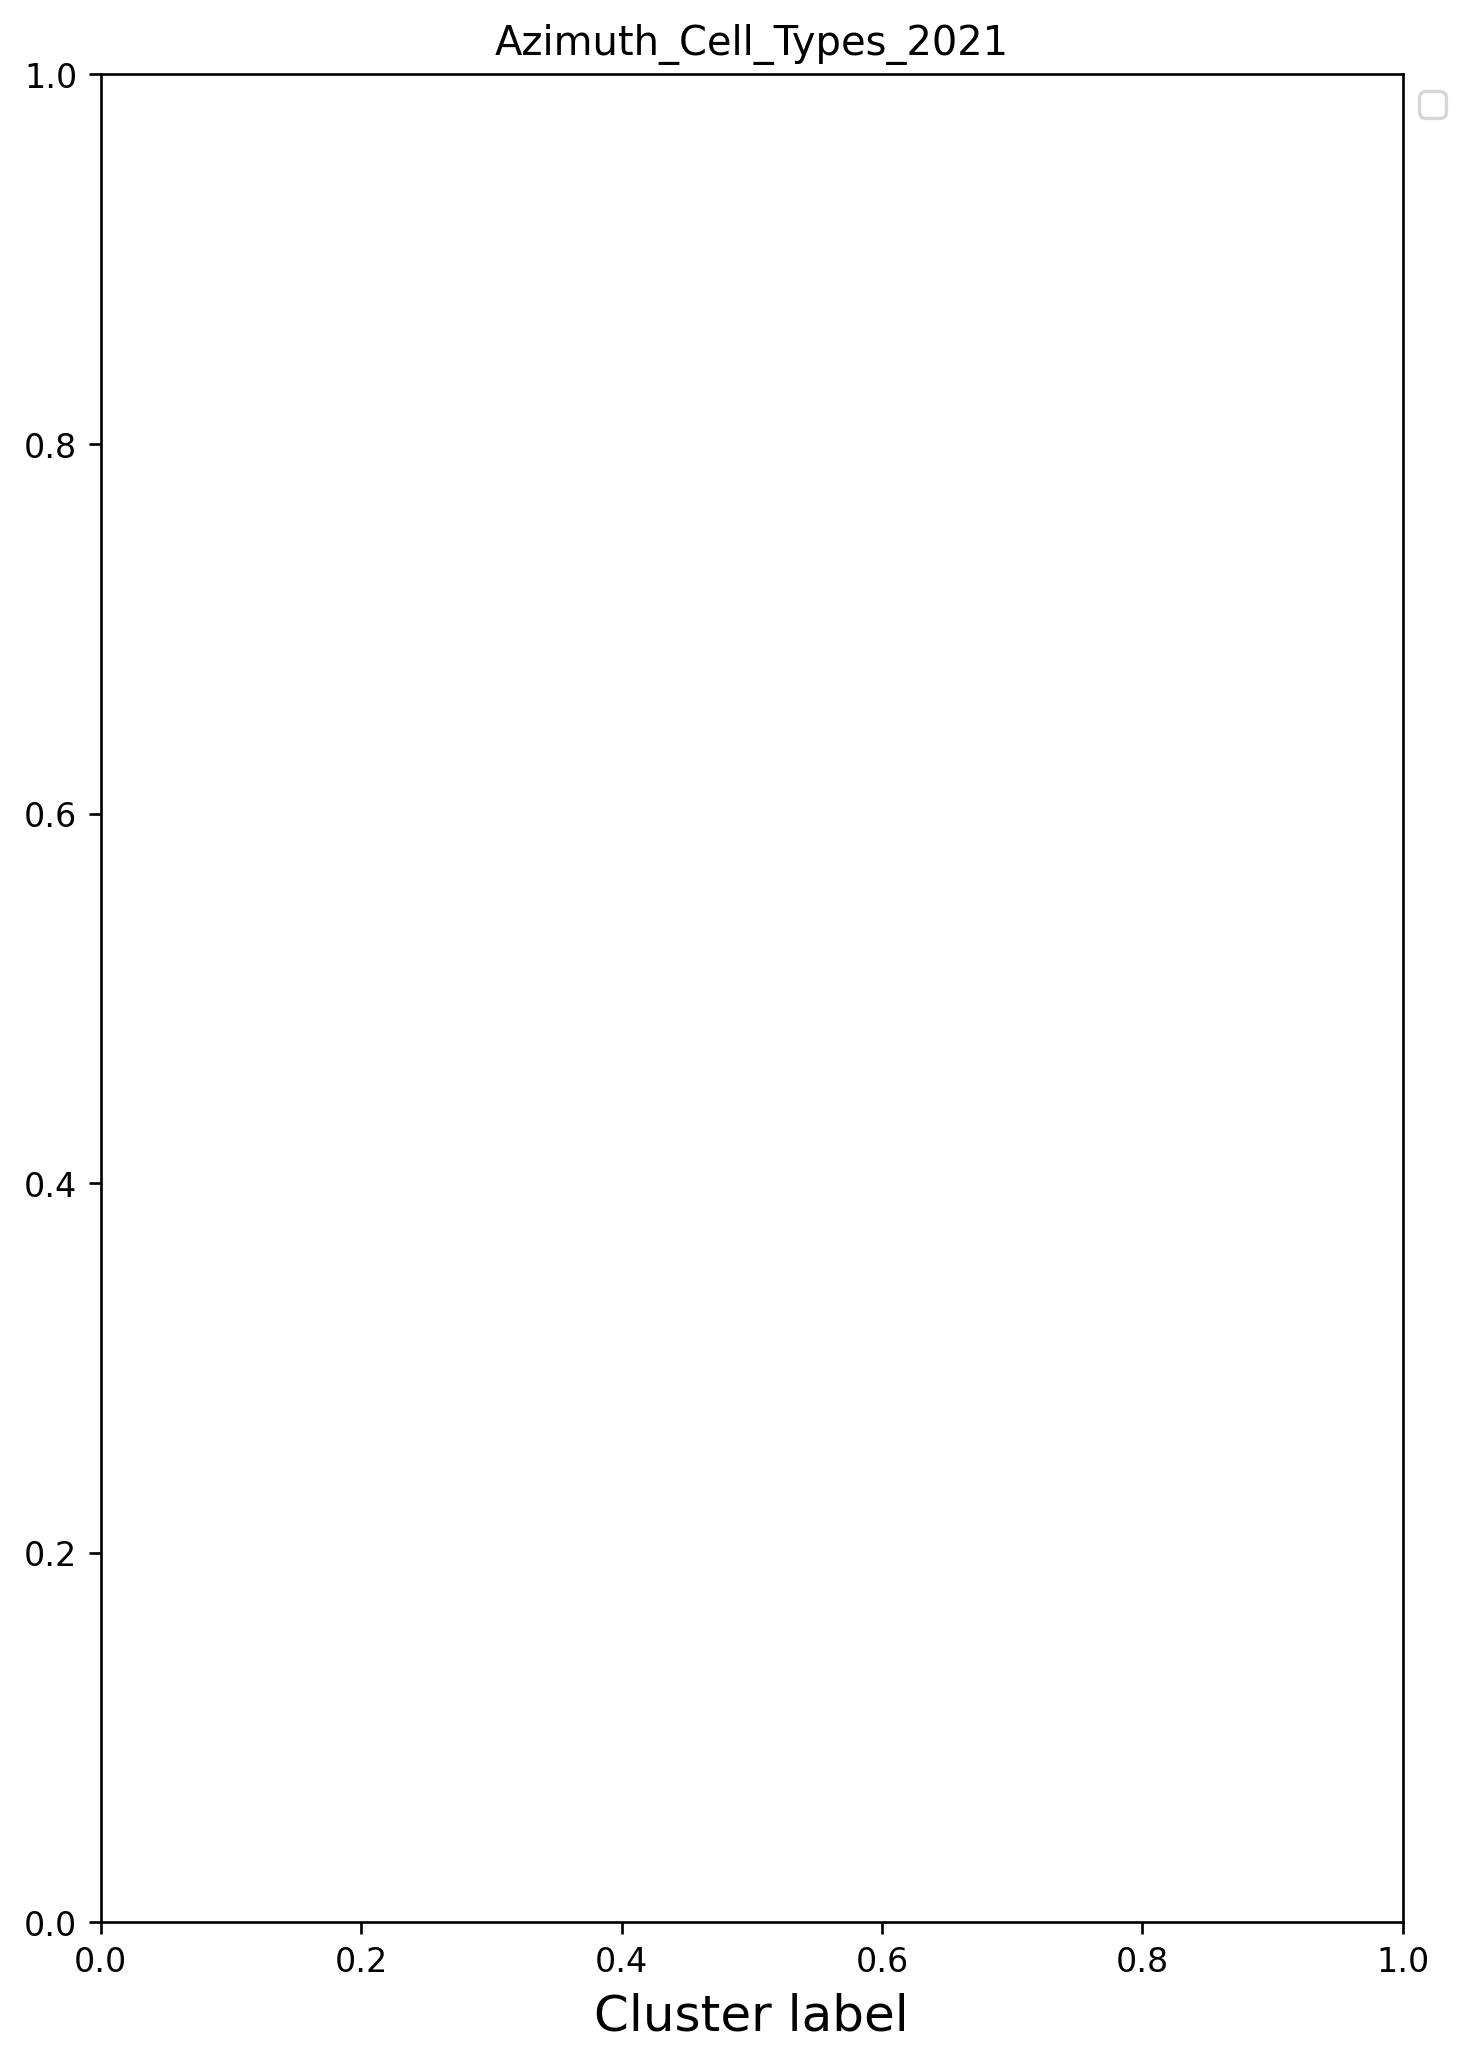

In [603]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

x_ticks = ax.get_xticklabels()
x_ticks_pos = {text_obj.get_text():text_obj.get_position()[0] for text_obj in x_ticks}

y_ticks = ax.get_yticklabels()
y_ticks_pos = {text_obj.get_text():text_obj.get_position()[1] for text_obj in y_ticks}

text_df = enrich_res_plot.reset_index().copy()
for i in range(text_df.shape[0]):
    text_df_sub = text_df.iloc[i, :].to_dict()
    x=x_ticks_pos[text_df_sub['cluster_label']]
    y=y_ticks_pos[text_df_sub['Term']]
    text = ','.join(text_df_sub['Overlapping genes'])
    #ax.annotate(text, (x, y), xycoords='data', xytext=(x + 0.1, y - 0.1), textcoords='data', arrowprops={'arrowstyle': '-'})
    ax.text(x + 0.05, y - 0.1, text, fontsize=7)

## Azimuth_2023


In [604]:
db_name = 'Azimuth_2023'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [605]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  Z-score  \
Term                                                             
Tonsil-L2-aDC2                            1  0.003209      inf   
Adipose-L1-Monocyte                       2  0.003209      inf   
Lung V2 (HLCA)-ann Level 4-Suprabasal     3  0.006409    323.5   
PBMC-L2-CD8+ Central Memory T             4  0.006409    323.5   
Lung v1-L2-Lipofibroblast                 5  0.006409    323.5   

                                       Combined score Overlapping genes  \
Term                                                                      
Tonsil-L2-aDC2                                    inf           [NRXN2]   
Adipose-L1-Monocyte                               inf           [COTL1]   
Lung V2 (HLCA)-ann Level 4-Suprabasal      1633.71615            [LDHB]   
PBMC-L2-CD8+ Central Memory T              1633.71615            [LDHB]   
Lung v1-L2-Lipofibroblast                  1633.71615            [PPA1]   

                                       Adjusted P-value  Old p-value  \
Term                                                                   
Tonsil-L2-aDC2                                 0.020732            0   
Adipose-L1-Monocyte                            0.020732            0   
Lung V2 (HLCA)-ann Level 4-Suprabasal          0.020732            0   
PBMC-L2-CD8+ Central Memory T                  0.020732            0   
Lung v1-L2-Lipofibroblast                      0.020732            0   

                                       Old adjusted p-value  \
Term                                                          
Tonsil-L2-aDC2                                            0   
Adipose-L1-Monocyte                                       0   
Lung V2 (HLCA)-ann Level 4-Suprabasal                     0   
PBMC-L2-CD8+ Central Memory T                             0   
Lung v1-L2-Lipofibroblast                                 0   

                                       num_overlap_genes  neg_log10(p_adj)  \
Term                                                                         
Tonsil-L2-aDC2                                         1          1.683364   
Adipose-L1-Monocyte                                    1          1.683364   
Lung V2 (HLCA)-ann Level 4-Suprabasal                  1          1.683364   
PBMC-L2-CD8+ Central Memory T                          1          1.683364   
Lung v1-L2-Lipofibroblast                              1          1.683364   

                                      cluster_label  
Term                                                 
Tonsil-L2-aDC2                         age-specific  
Adipose-L1-Monocyte                    age-specific  
Lung V2 (HLCA)-ann Level 4-Suprabasal  age-specific  
PBMC-L2-CD8+ Central Memory T          age-specific  
Lung v1-L2-Lipofibroblast              age-specific

In [606]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms = terms[terms.str.contains('Cortex')]
terms.size

12

In [607]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

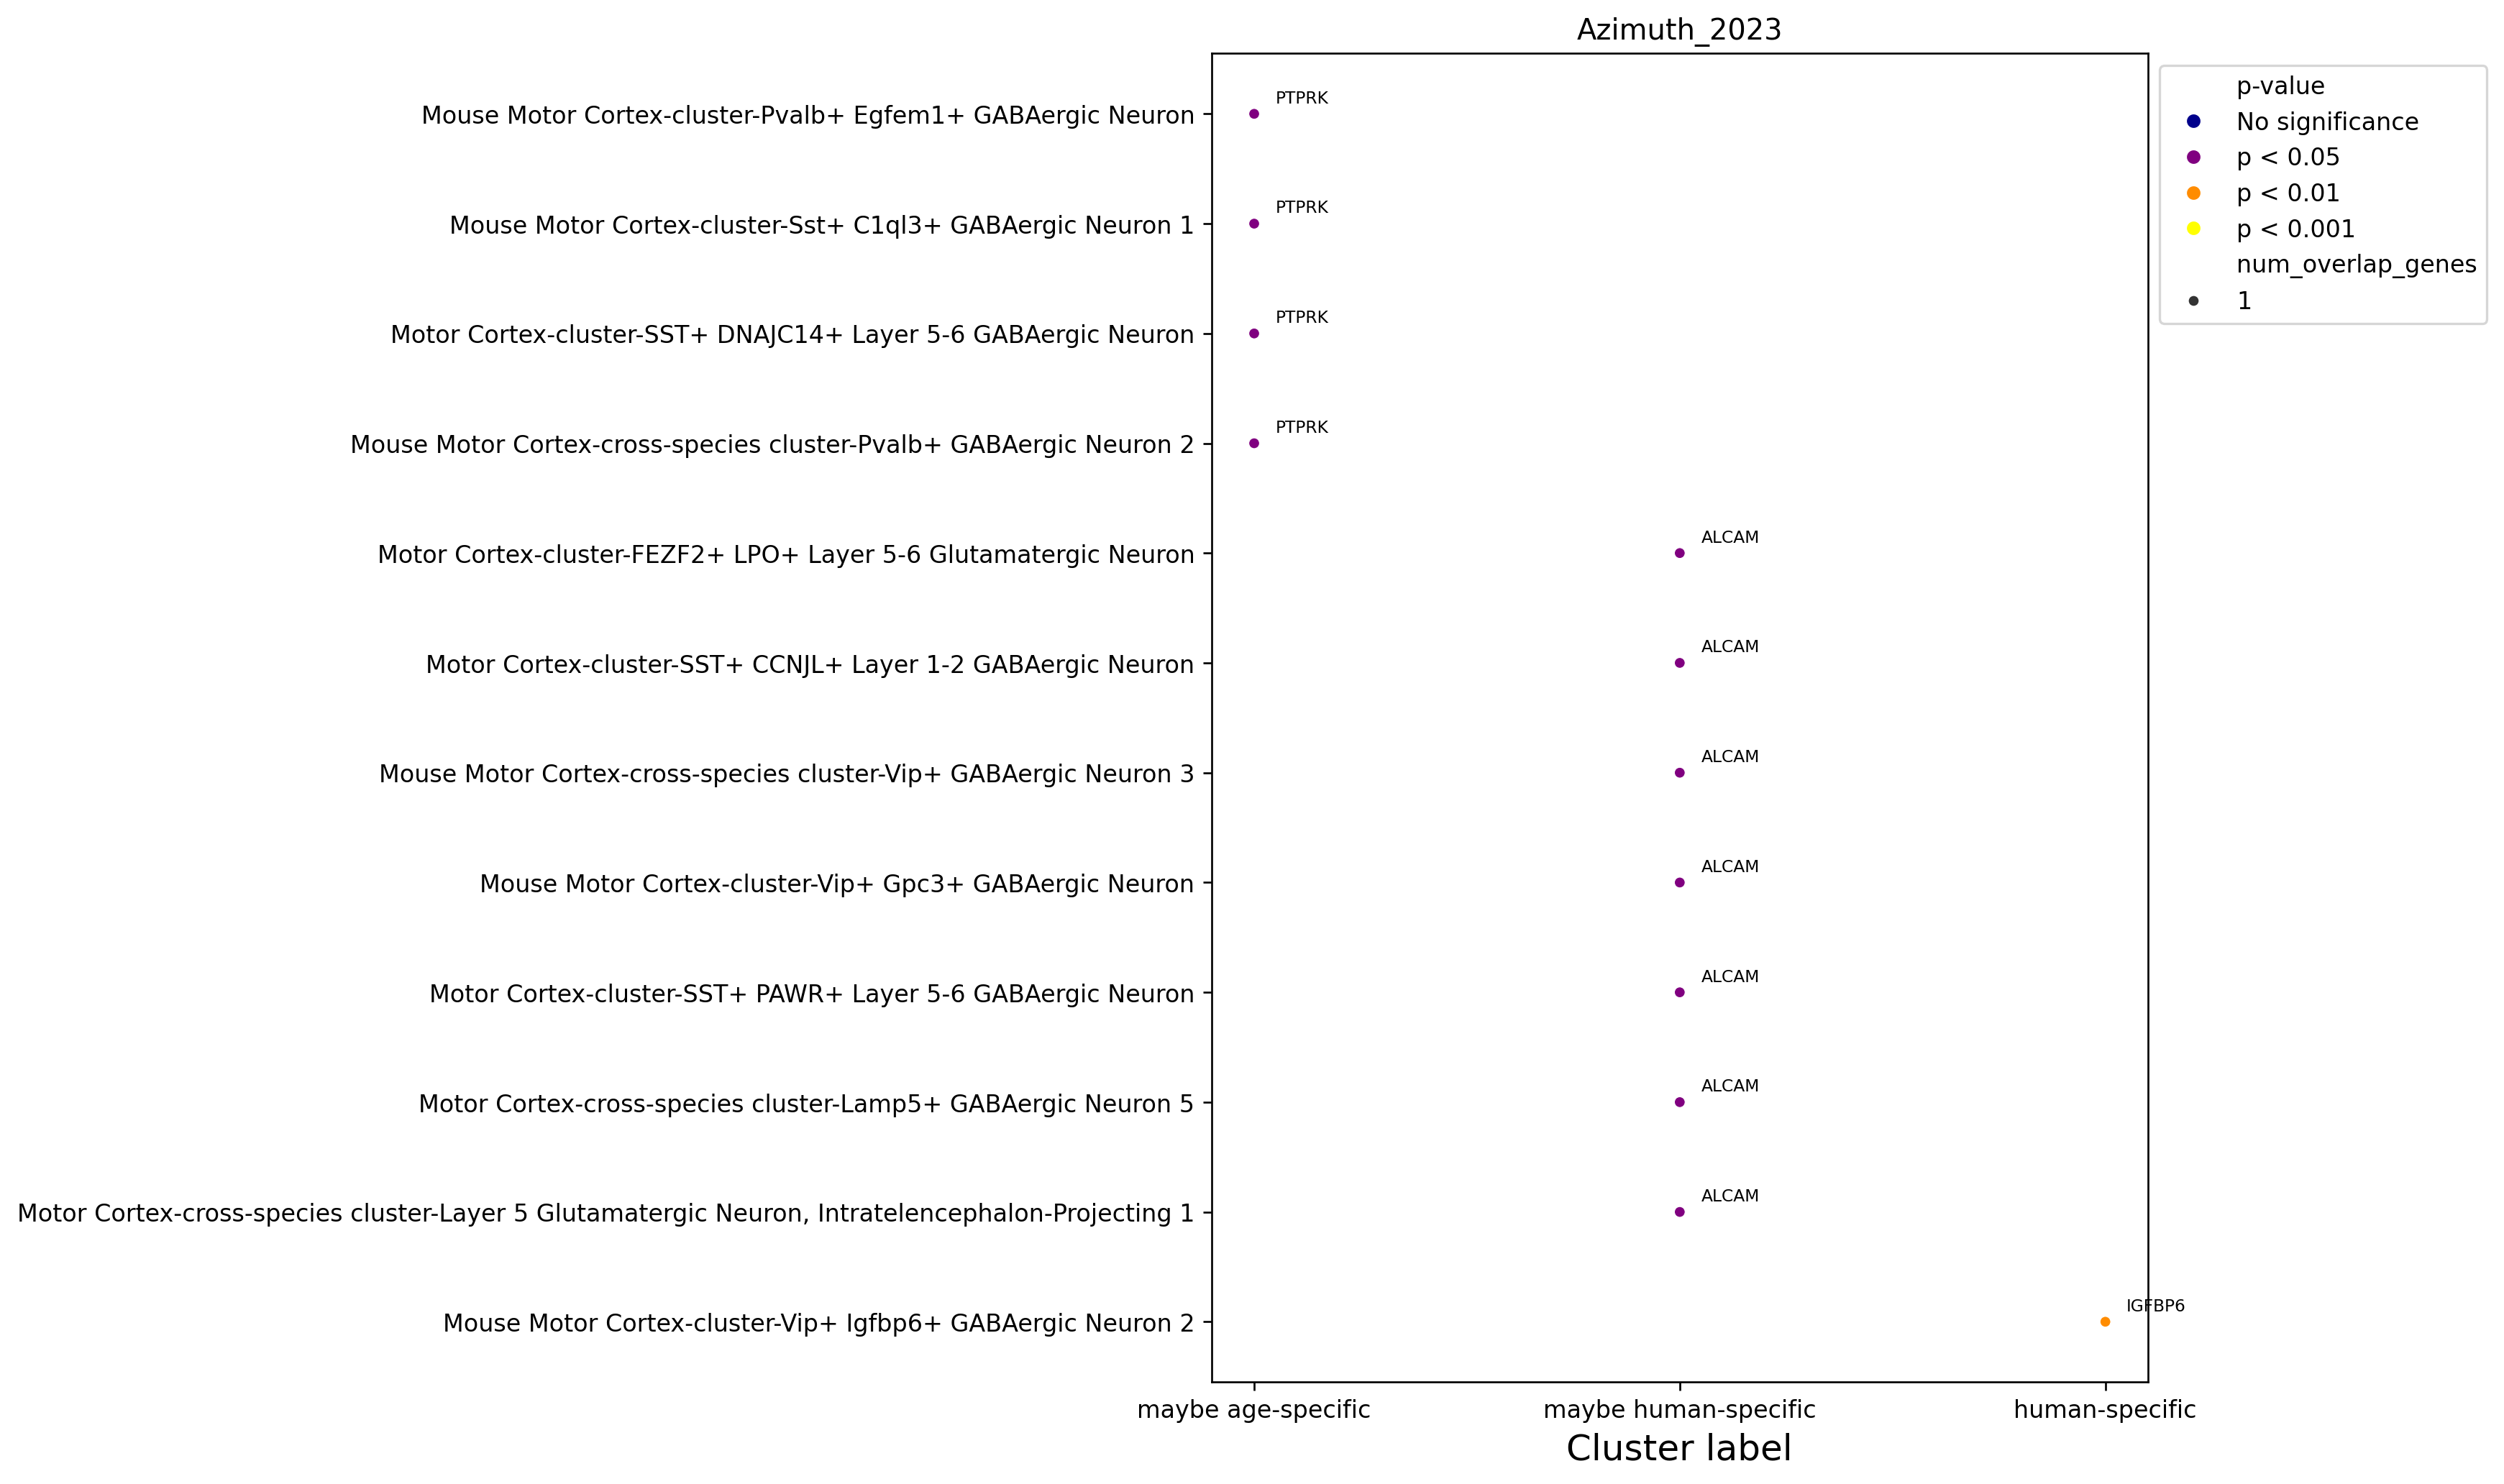

In [608]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

x_ticks = ax.get_xticklabels()
x_ticks_pos = {text_obj.get_text():text_obj.get_position()[0] for text_obj in x_ticks}

y_ticks = ax.get_yticklabels()
y_ticks_pos = {text_obj.get_text():text_obj.get_position()[1] for text_obj in y_ticks}

text_df = enrich_res_plot.reset_index().copy()
for i in range(text_df.shape[0]):
    text_df_sub = text_df.iloc[i, :].to_dict()
    x=x_ticks_pos[text_df_sub['cluster_label']]
    y=y_ticks_pos[text_df_sub['Term']]
    text = ','.join(text_df_sub['Overlapping genes'])
    #ax.annotate(text, (x, y), xycoords='data', xytext=(x + 0.1, y - 0.1), textcoords='data', arrowprops={'arrowstyle': '-'})
    ax.text(x + 0.05, y - 0.1, text, fontsize=7)

## Allen_Brain_Atlas_10x_scRNA_2021


In [609]:
db_name = 'Allen_Brain_Atlas_10x_scRNA_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [610]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  Combined score  \
Term                                                                         
Mouse 125 DG down                   1  0.000069   8.679346       83.163200   
Mouse 364 Oligo down                2  0.000883   5.567171       39.148346   
Mouse 116 Pvalb up                  3  0.001306  44.927536      298.365180   
Mouse 115 Pvalb up                  4  0.002196  33.673913      206.121186   
Human Inh L5-6 PVALB FAM150B up     5  0.002400  32.066253      193.426408   

                                                                 Overlapping genes  \
Term                                                                                 
Mouse 125 DG down                [GAD1, CLSTN1, NRXN2, CX3CL1, GNAI1, FBXO9, DL...   
Mouse 364 Oligo down             [NDUFB10, NRXN1, CLSTN1, CX3CL1, GNAI1, FBXO9,...   
Mouse 116 Pvalb up                                                  [LDHB, PPP1CC]   
Mouse 115 Pvalb up                                                  [LDHB, PPP1CC]   
Human Inh L5-6 PVALB FAM150B up                                    [LDHB, ST3GAL5]   

                                 Adjusted P-value  Old p-value  \
Term                                                             
Mouse 125 DG down                        0.011933            0   
Mouse 364 Oligo down                     0.075294            0   
Mouse 116 Pvalb up                       0.075294            0   
Mouse 115 Pvalb up                       0.081750            0   
Human Inh L5-6 PVALB FAM150B up          0.081750            0   

                                 Old adjusted p-value  num_overlap_genes  \
Term                                                                       
Mouse 125 DG down                                   0                  7   
Mouse 364 Oligo down                                0                  7   
Mouse 116 Pvalb up                                  0                  2   
Mouse 115 Pvalb up                                  0                  2   
Human Inh L5-6 PVALB FAM150B up                     0                  2   

                                 neg_log10(p_adj) cluster_label  
Term                                                             
Mouse 125 DG down                        1.923249  age-specific  
Mouse 364 Oligo down                     1.123238  age-specific  
Mouse 116 Pvalb up                       1.123238  age-specific  
Mouse 115 Pvalb up                       1.087512  age-specific  
Human Inh L5-6 PVALB FAM150B up          1.087512  age-specific

In [611]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

5

In [612]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

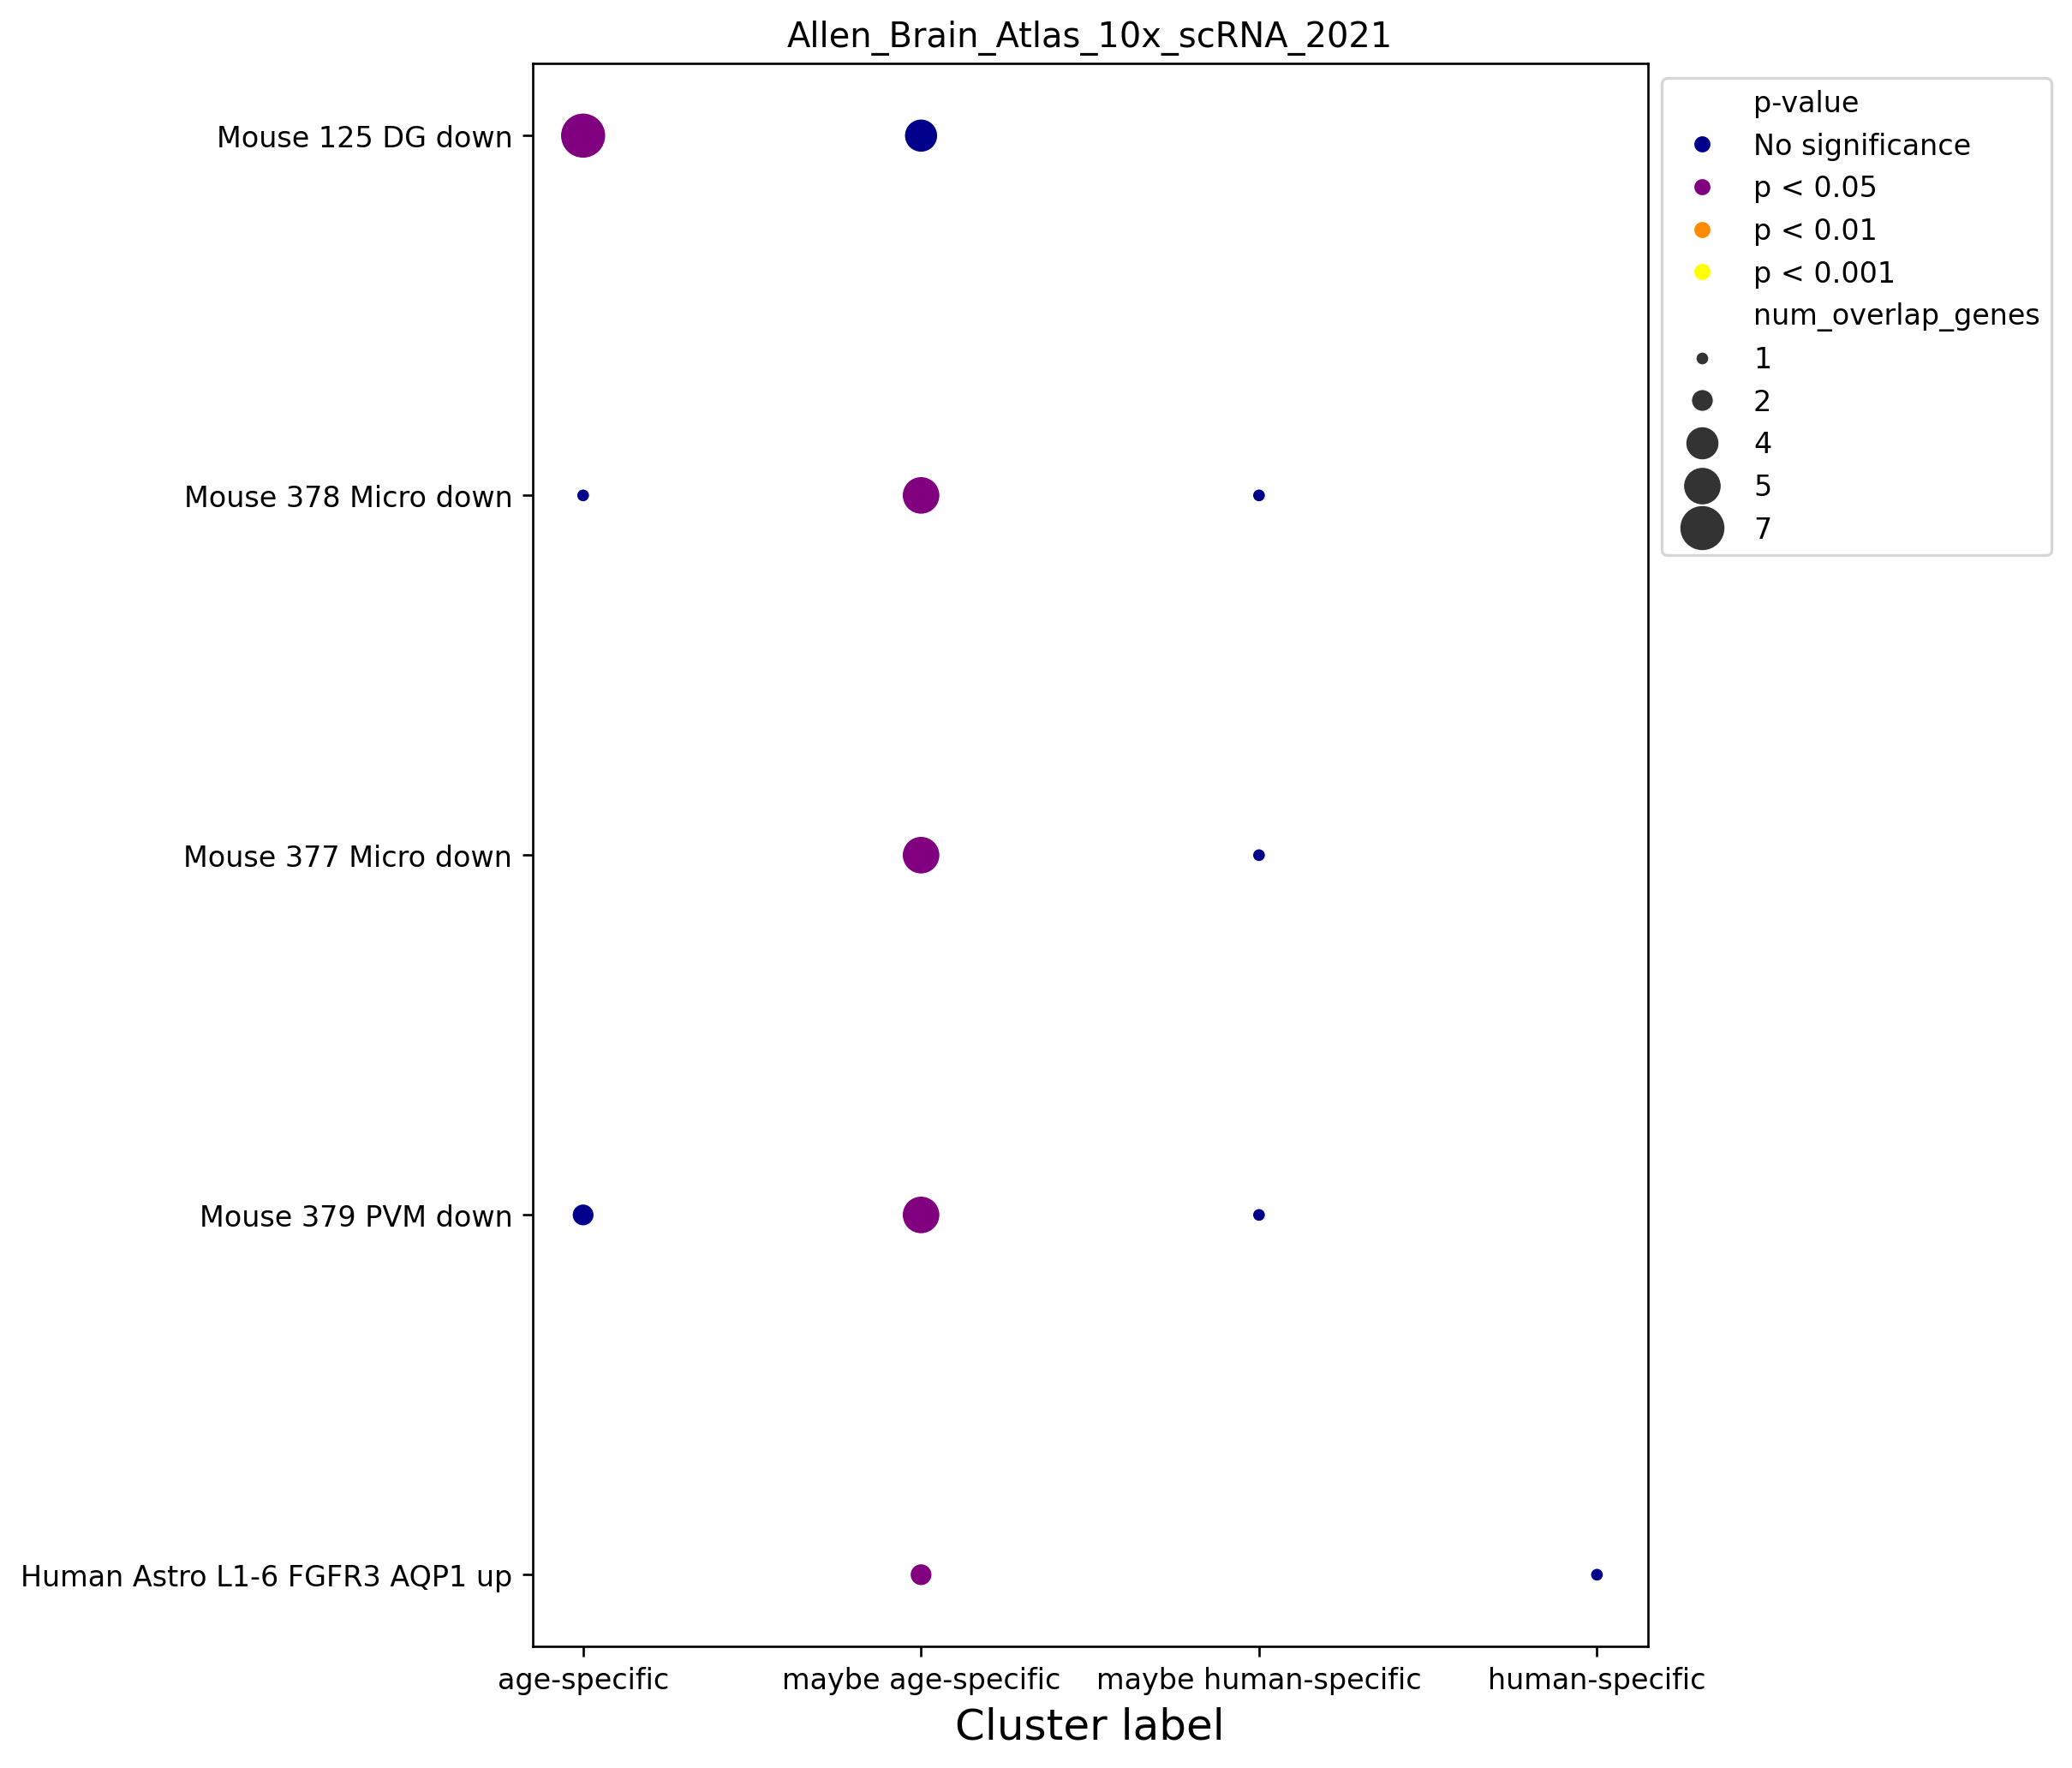

In [613]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


## SynGO_2022

In [614]:
db_name = 'SynGO_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [615]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                            
Regulation Of Synaptic Vesicle Fusion To Presyn...    1  0.012778  107.805556   
Maintenance Of Postsynaptic Specialization Stru...    2  0.015947   80.843750   
Regulation Of Postsynaptic Specialization Assem...    3  0.019108   64.666667   
Integral Component Of Presynaptic Membrane (GO:...    4  0.020342    9.990915   
Regulation Of Calcium-Dependent Activation Of S...    5  0.022258   53.881944   

                                                    Combined score  \
Term                                                                 
Regulation Of Synaptic Vesicle Fusion To Presyn...      470.038549   
Maintenance Of Postsynaptic Specialization Stru...      334.568150   
Regulation Of Postsynaptic Specialization Assem...      255.929395   
Integral Component Of Presynaptic Membrane (GO:...       38.915054   
Regulation Of Calcium-Dependent Activation Of S...      205.023943   

                                                   Overlapping genes  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...            [ERC1]   
Maintenance Of Postsynaptic Specialization Stru...         [SYNGAP1]   
Regulation Of Postsynaptic Specialization Assem...           [NRXN1]   
Integral Component Of Presynaptic Membrane (GO:...   [NRXN1, ATP1A3]   
Regulation Of Calcium-Dependent Activation Of S...            [ERC1]   

                                                    Adjusted P-value  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...          0.065939   
Maintenance Of Postsynaptic Specialization Stru...          0.065939   
Regulation Of Postsynaptic Specialization Assem...          0.065939   
Integral Component Of Presynaptic Membrane (GO:...          0.065939   
Regulation Of Calcium-Dependent Activation Of S...          0.065939   

                                                   Old p-value  \
Term                                                             
Regulation Of Synaptic Vesicle Fusion To Presyn...           0   
Maintenance Of Postsynaptic Specialization Stru...           0   
Regulation Of Postsynaptic Specialization Assem...           0   
Integral Component Of Presynaptic Membrane (GO:...           0   
Regulation Of Calcium-Dependent Activation Of S...           0   

                                                   Old adjusted p-value  \
Term                                                                      
Regulation Of Synaptic Vesicle Fusion To Presyn...                    0   
Maintenance Of Postsynaptic Specialization Stru...                    0   
Regulation Of Postsynaptic Specialization Assem...                    0   
Integral Component Of Presynaptic Membrane (GO:...                    0   
Regulation Of Calcium-Dependent Activation Of S...                    0   

                                                   num_overlap_genes  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...                 1   
Maintenance Of Postsynaptic Specialization Stru...                 1   
Regulation Of Postsynaptic Specialization Assem...                 1   
Integral Component Of Presynaptic Membrane (GO:...                 2   
Regulation Of Calcium-Dependent Activation Of S...                 1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...          1.180857   
Maintenance Of Postsynaptic Specialization Stru...          1.180857   
Regulation Of Postsynaptic Specialization Assem...          1.180857   
Integral Component Of Presynaptic Membrane (GO:...          1.180857   
Regulation Of Calcium-Dependent Activation Of S...      

In [616]:
enrich_res[enrich_res['Adjusted P-value'] < 0.05].head()

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [617]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

0

In [618]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_28700\320292492.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


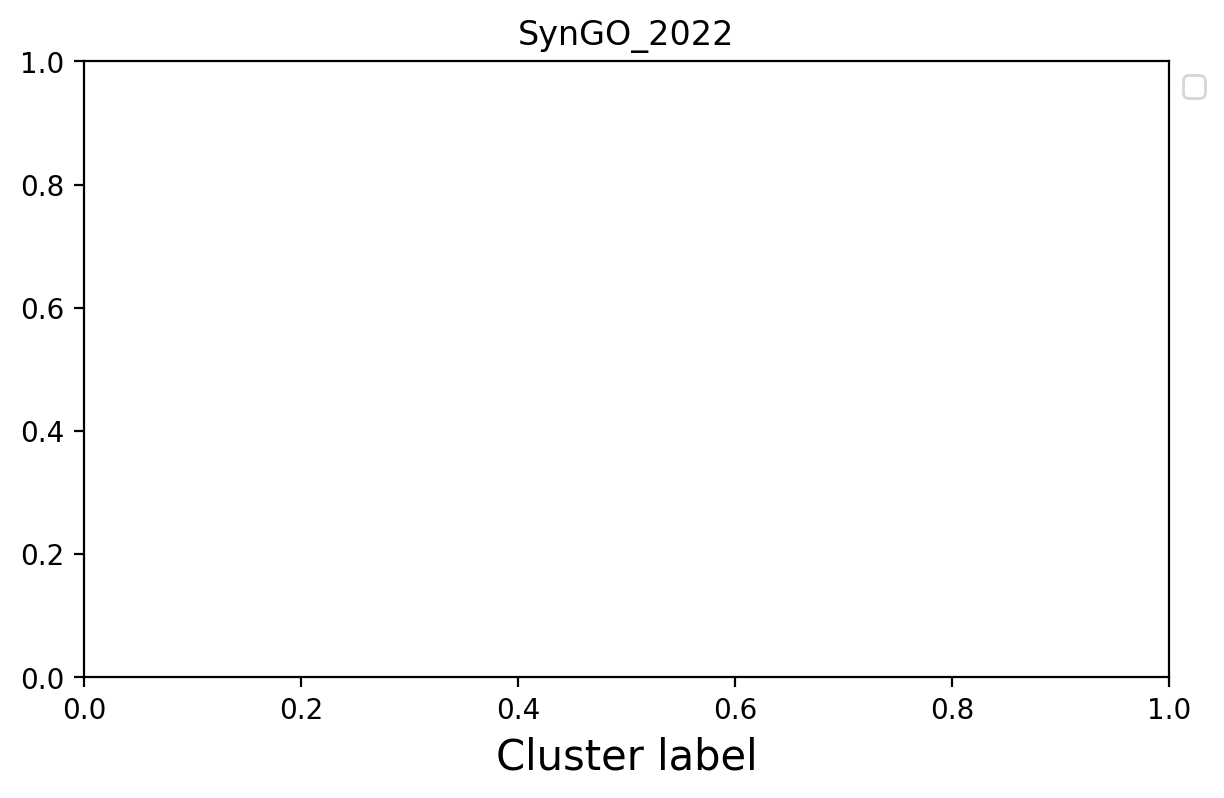

In [619]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 4), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [620]:
db_name = 'MGI_Mammalian_Phenotype_Level_4_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [621]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
abnormal habituation to a new environment MP:00...     1  0.000351  96.372671   
abnormal excitatory postsynaptic currents MP:00...     2  0.001069  17.222057   
decreased circulating HDL cholesterol level MP:...     3  0.002188  13.266974   
abnormal long term object recognition memory MP...     4  0.002835  29.270321   
abnormal dendritic cell physiology MP:0002376          5  0.003066  28.047101   

                                                    Combined score  \
Term                                                                 
abnormal habituation to a new environment MP:00...      766.590156   
abnormal excitatory postsynaptic currents MP:00...      117.813355   
decreased circulating HDL cholesterol level MP:...       81.258367   
abnormal long term object recognition memory MP...      171.688618   
abnormal dendritic cell physiology MP:0002376           162.323776   

                                                          Overlapping genes  \
Term                                                                          
abnormal habituation to a new environment MP:00...         [ATP1A3, DLGAP4]   
abnormal excitatory postsynaptic currents MP:00...  [NRXN1, CLSTN1, DLGAP4]   
decreased circulating HDL cholesterol level MP:...       [LDHB, NRXN1, LPL]   
abnormal long term object recognition memory MP...          [ATP1A3, GNAI1]   
abnormal dendritic cell physiology MP:0002376              [ZBTB46, CX3CL1]   

                                                    Adjusted P-value  \
Term                                                                   
abnormal habituation to a new environment MP:00...          0.075136   
abnormal excitatory postsynaptic currents MP:00...          0.104625   
decreased circulating HDL cholesterol level MP:...          0.104625   
abnormal long term object recognition memory MP...          0.104625   
abnormal dendritic cell physiology MP:0002376               0.104625   

                                                    Old p-value  \
Term                                                              
abnormal habituation to a new environment MP:00...            0   
abnormal excitatory postsynaptic currents MP:00...            0   
decreased circulating HDL cholesterol level MP:...            0   
abnormal long term object recognition memory MP...            0   
abnormal dendritic cell physiology MP:0002376                 0   

                                                    Old adjusted p-value  \
Term                                                                       
abnormal habituation to a new environment MP:00...                     0   
abnormal excitatory postsynaptic currents MP:00...                     0   
decreased circulating HDL cholesterol level MP:...                     0   
abnormal long term object recognition memory MP...                     0   
abnormal dendritic cell physiology MP:0002376                          0   

                                                    num_overlap_genes  \
Term                                                                    
abnormal habituation to a new environment MP:00...                  2   
abnormal excitatory postsynaptic currents MP:00...                  3   
decreased circulating HDL cholesterol level MP:...                  3   
abnormal long term object recognition memory MP...                  2   
abnormal dendritic cell physiology MP:0002376                       2   

                                                    neg_log10(p_adj)  \
Term                                                                   
abnormal habituation to a new environment MP:00...          1.124153   
abnormal excitatory postsynaptic currents MP:00...          0.980366   
decreased circulating HDL cholesterol level MP:...          0.980366   
abnormal long term object recognition memory MP...         

In [622]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

0

In [623]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_28700\916715644.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


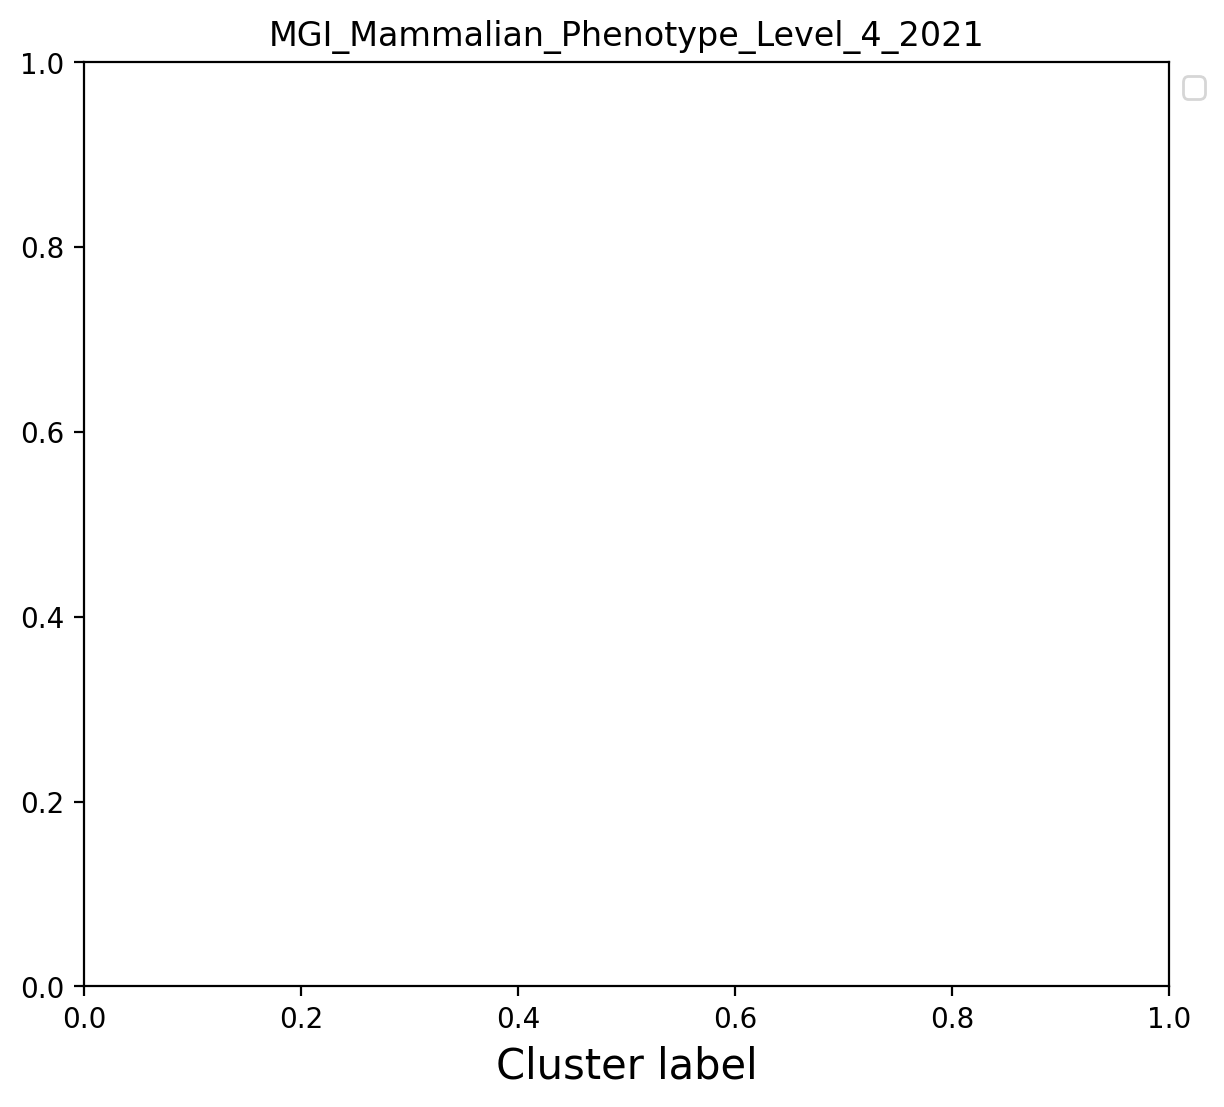

In [624]:
fig = plt.figure(figsize=(7, 6), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Correlation of real profiles

## Categorize

In [625]:
layer_mean = df_cont.groupby(['condition', 'layer']).mean()

In [626]:
from scipy.stats import spearmanr, pearsonr, kendalltau

columns = ['pear_ha', 'pear_mca', 'sp_ha', 'sp_mca', 'kend_ha', 'kend_mca']
corr_list = []
for gene in df_spline.columns[:-1]:
    human_spl = layer_mean.loc['human', gene].values
    adult_spl = layer_mean.loc['spatial_libd_human', gene].values
    chimp_spl = layer_mean.loc['chimp', gene].values
    macaque_spl = layer_mean.loc['macaque', gene].values
    ch_m_spl = (chimp_spl + macaque_spl) / 2



    pear_ha = pearsonr(adult_spl, human_spl)
    pear_mca = pearsonr(adult_spl, ch_m_spl)
    sp_ha = spearmanr(adult_spl, human_spl)
    sp_mca = spearmanr(adult_spl, macaque_spl)
    kl_ha = kendalltau(adult_spl, human_spl)
    kl_mca = kendalltau(adult_spl, macaque_spl)
    corr_list.append([pear_ha[0], pear_mca[0], sp_ha[0], sp_mca[0], kl_ha[0], kl_mca[0]])

corr_df_real = pd.DataFrame(corr_list, columns=columns, index=df_spline.columns[:-1])
corr_df_real.head()

pear_ha  pear_mca     sp_ha    sp_mca   kend_ha  kend_mca
ALCAM  -0.040401 -0.385612 -0.607143 -0.392857 -0.523810 -0.428571
AMZ2    0.284865 -0.719588  0.107143 -0.321429  0.142857 -0.142857
ASAH1   0.869352 -0.318858  0.750000 -0.142857  0.619048 -0.047619
ASAP2  -0.031382  0.843507  0.000000  0.785714  0.047619  0.714286
ATP1A3 -0.117213  0.592002 -0.214286  0.321429 -0.047619  0.238095

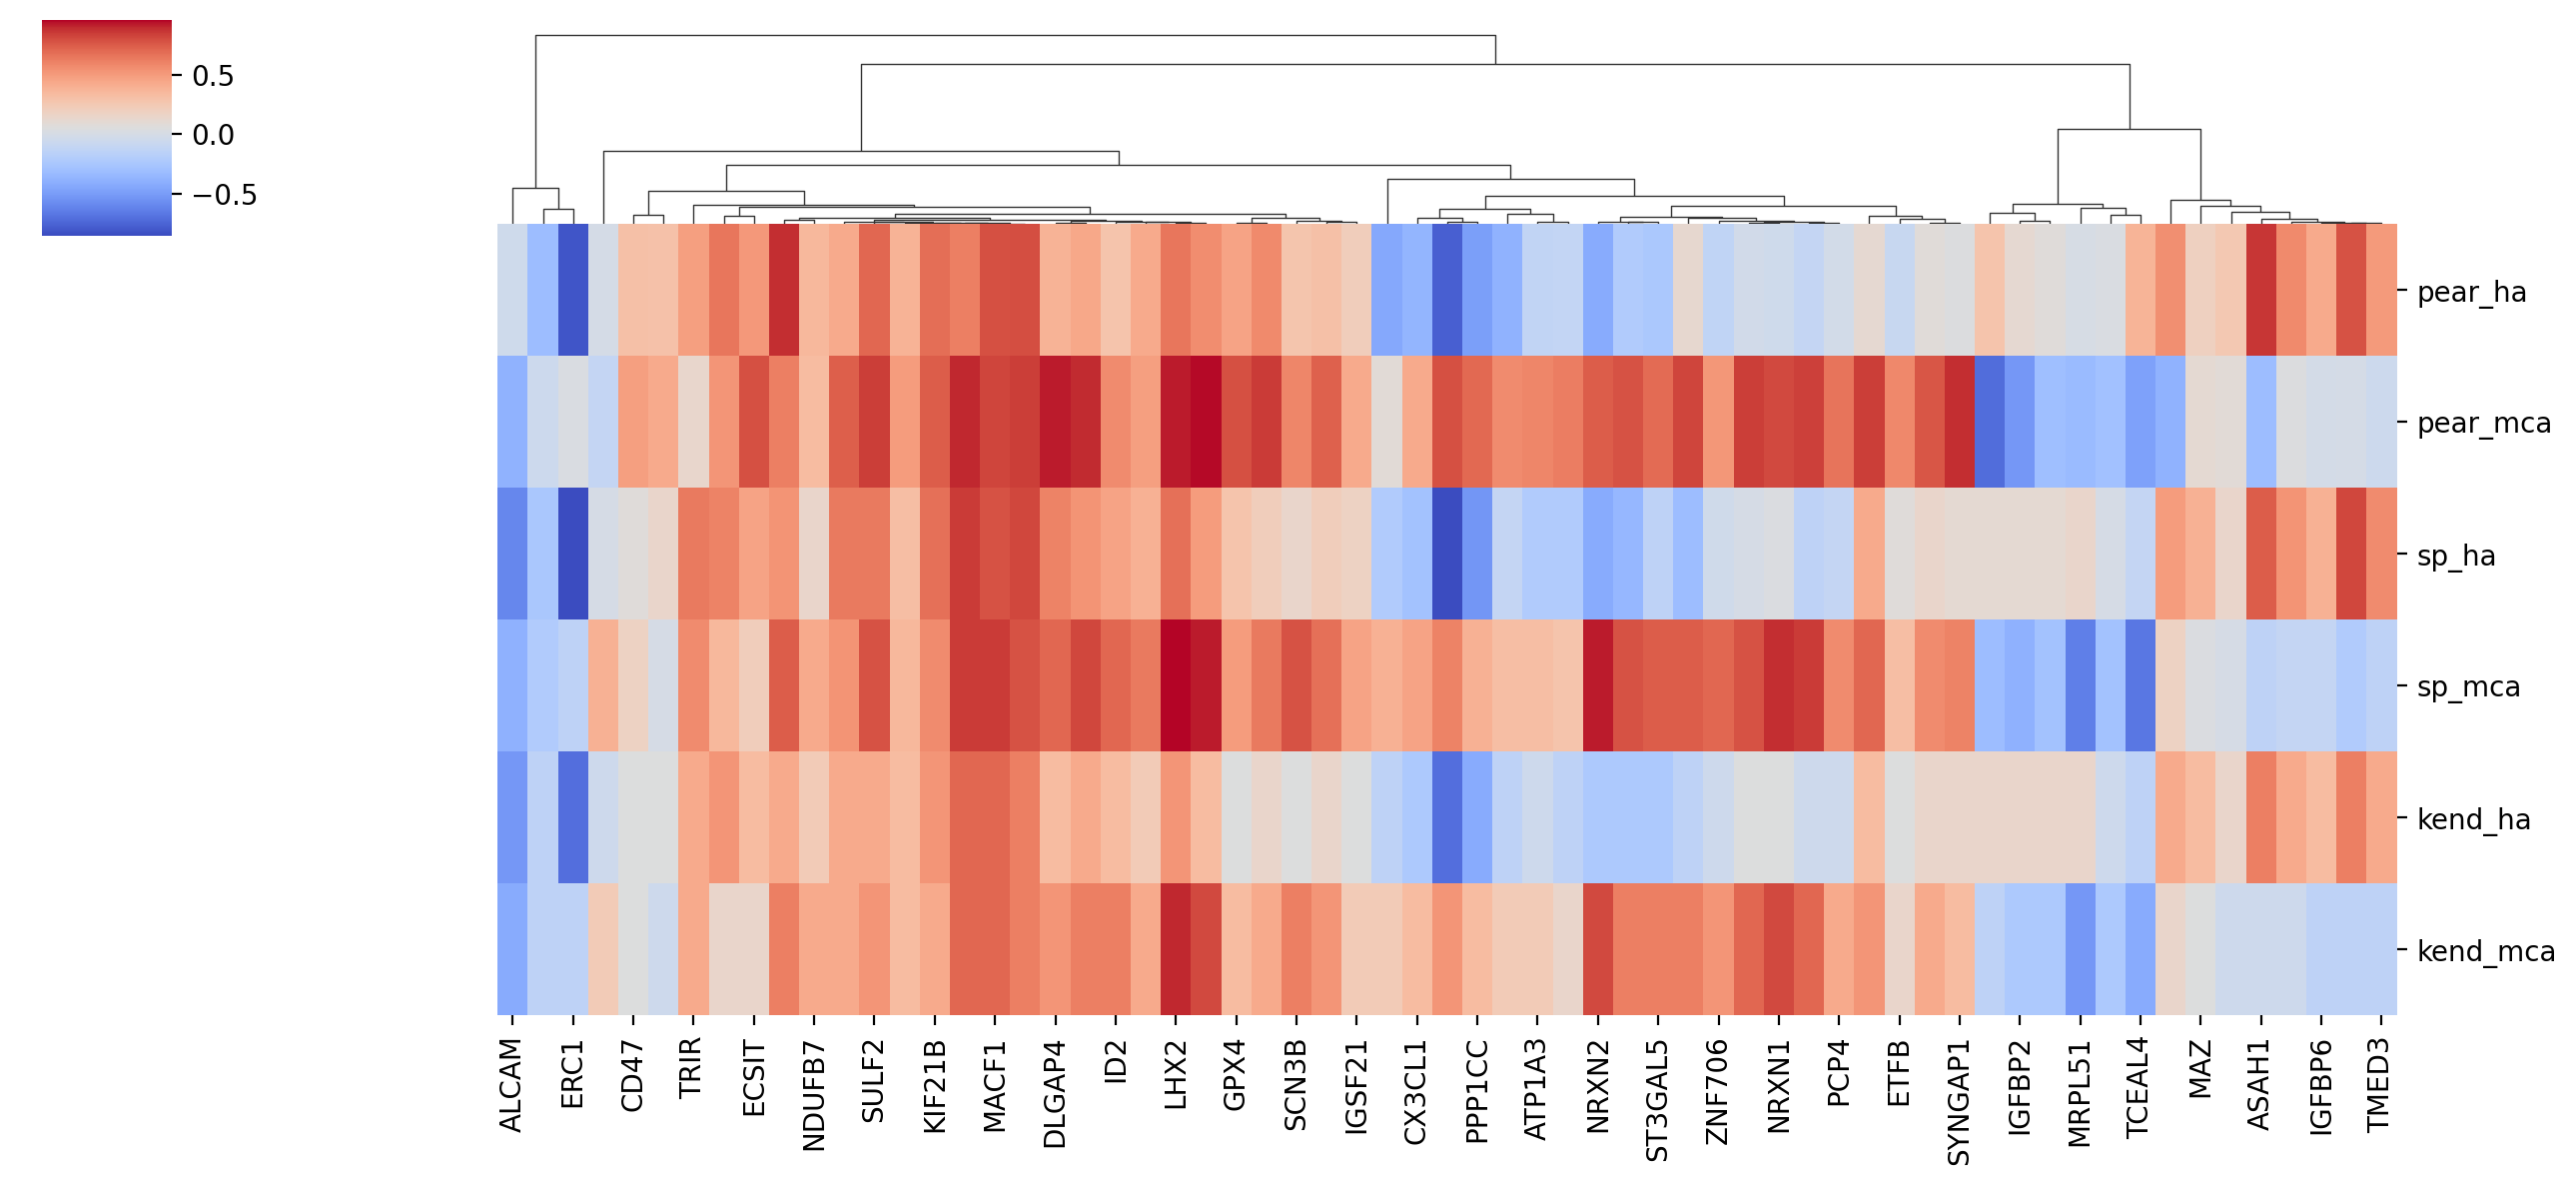

In [627]:
#fig = plt.figure(figsize=(10, 3), dpi=60)
clust = sns.clustermap(corr_df_real.T, cmap='coolwarm', figsize=(13, 6), row_cluster=False, metric='cosine')

In [628]:
corr_df_real['mean_ha'] = (corr_df_real['sp_ha'] + corr_df_real['pear_ha']) / 2
corr_df_real['mean_mca'] = (corr_df_real['sp_mca'] + corr_df_real['pear_mca']) / 2
corr_df_real['corr_diff'] = corr_df_real['mean_ha'] - corr_df_real['mean_mca']
corr_df_real['pear_diff'] = corr_df_real['pear_ha'] - corr_df_real['pear_mca']
corr_df_real['sp_diff'] = corr_df_real['sp_ha'] - corr_df_real['sp_mca']
corr_df_real['kend_diff'] = corr_df_real['kend_ha'] - corr_df_real['kend_mca']

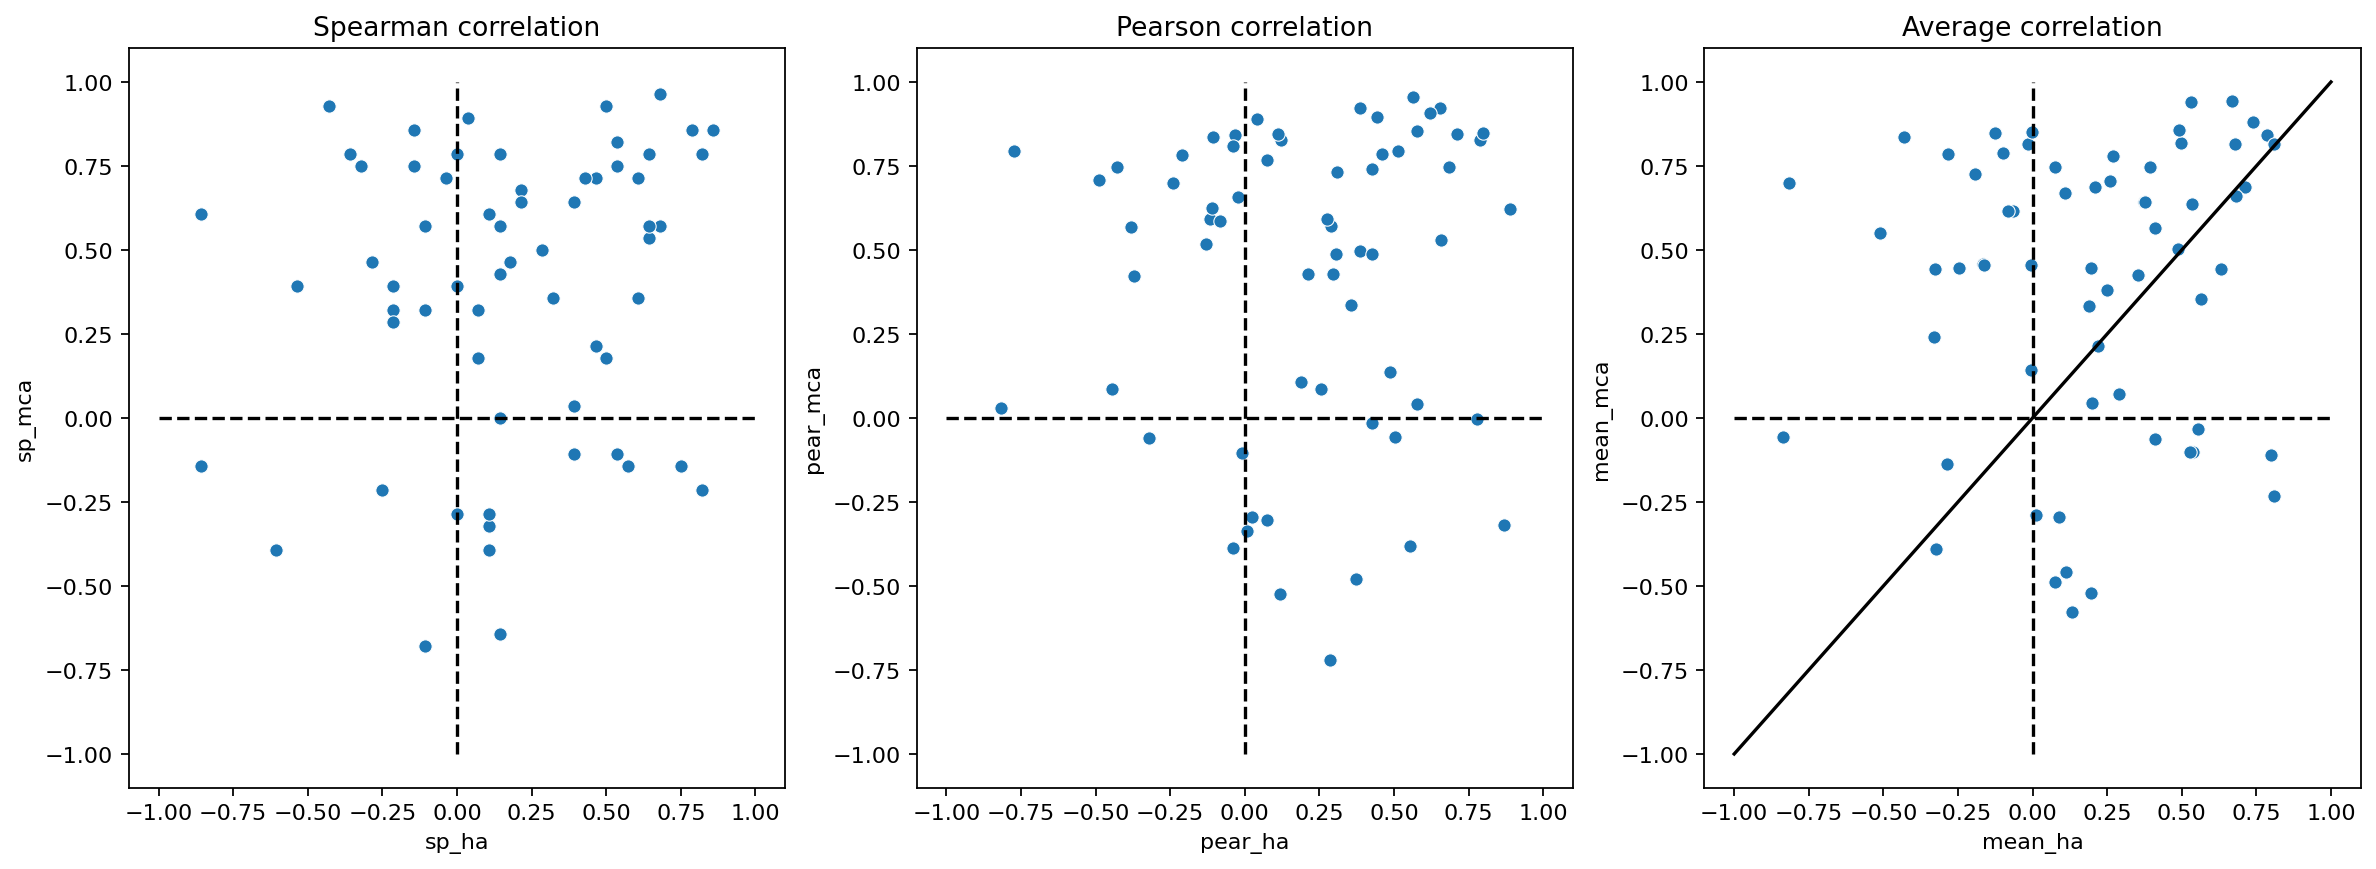

In [629]:
mpl.rcdefaults()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
sns.scatterplot(corr_df_real, x='sp_ha', y='sp_mca', ax=ax[0])
ax[0].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[0].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[0].set_title('Spearman correlation')
ax[0].grid(False)

sns.scatterplot(corr_df_real, x='pear_ha', y='pear_mca', ax=ax[1])
ax[1].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[1].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[1].set_title('Pearson correlation')
ax[1].grid(False)

sns.scatterplot(corr_df_real, x='mean_ha', y='mean_mca', ax=ax[2])
ax[2].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[2].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[2].plot([-1, 1], [-1, 1], '-', color='black')
ax[2].set_title('Average correlation')
ax[2].grid(False)

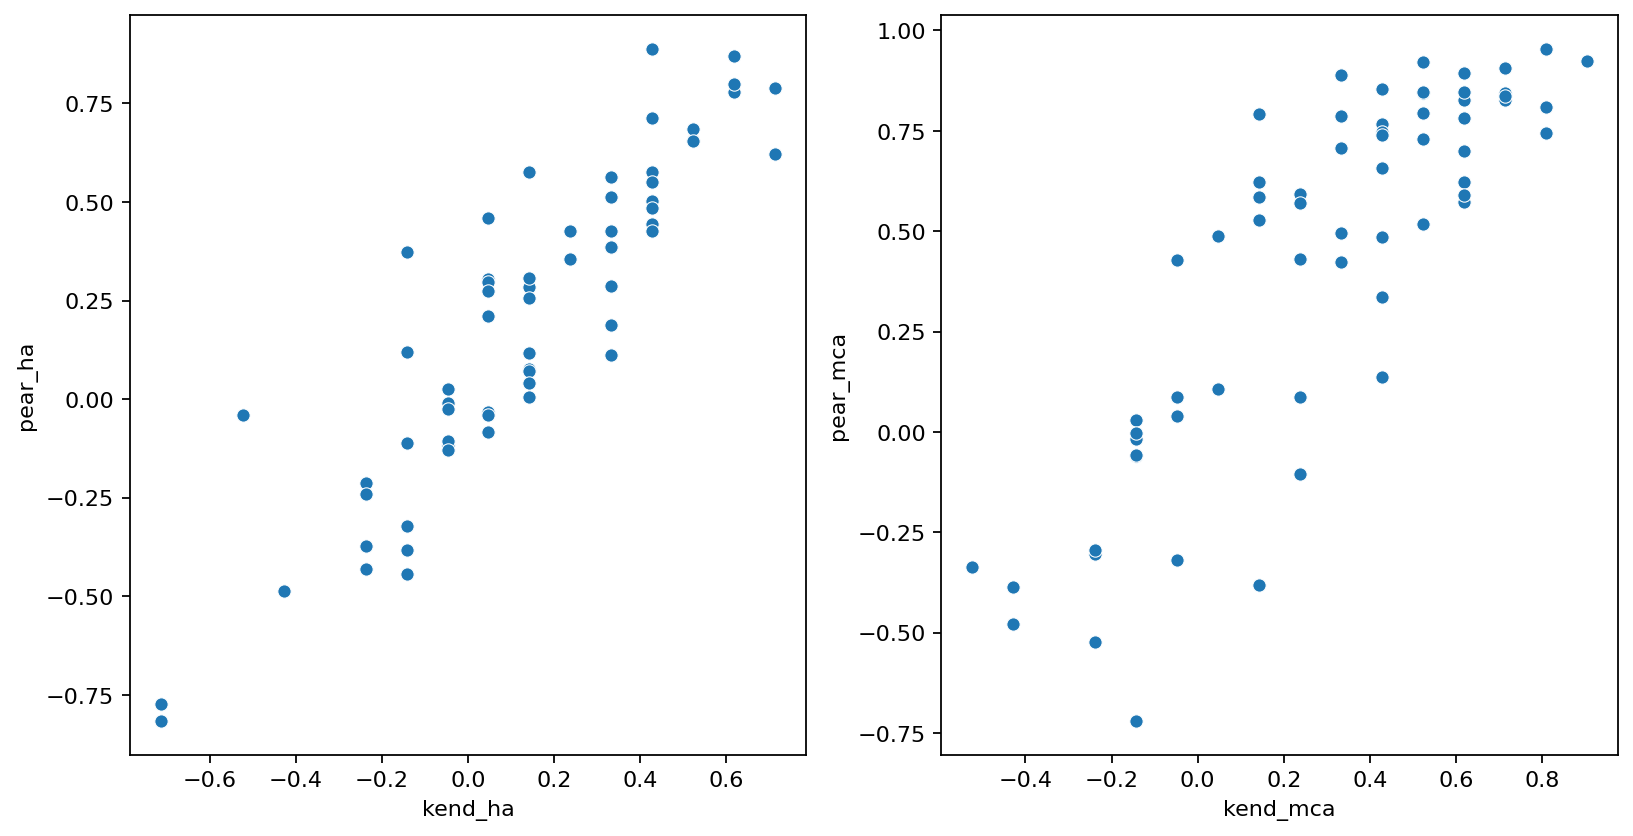

In [630]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
sns.scatterplot(x=corr_df_real['kend_ha'], y=corr_df_real['pear_ha'], ax=ax[0])
ax[0].grid(False)

sns.scatterplot(corr_df_real, x=corr_df_real['kend_mca'], y=corr_df_real['pear_mca'], ax=ax[1])
ax[1].grid(False)

In [631]:
corr_df_real['label'] = 'Zero'
tr = 0.4
corr_name = 'sp_diff'

corr_df_real.loc[corr_df_real[corr_name] > tr, 'label'] = 'human-specific'
corr_df_real.loc[(corr_df_real[corr_name] >= 0) & (corr_df_real[corr_name] <= tr), 'label'] = 'maybe human-specific'
corr_df_real.loc[(corr_df_real[corr_name] < 0) & (corr_df_real[corr_name] >= -tr), 'label'] = 'maybe age-specific'
corr_df_real.loc[corr_df_real[corr_name] < -tr, 'label'] = 'age-specific'
corr_df_real.label.value_counts()

label
age-specific            23
maybe age-specific      18
maybe human-specific    13
human-specific           9
Name: count, dtype: int64

In [632]:
gene_sets = dict()
for label in corr_df_real.label.unique():
  gene_sets[label] = corr_df_real[corr_df_real.label == label].index.to_list()

for group, genes in gene_sets.items():
  print(f'{group}: {genes}')

maybe age-specific: ['ALCAM', 'CAMLG', 'CD47', 'CHST10', 'DLGAP4', 'EIF3L', 'ETFB', 'GPX4', 'ID2', 'IGSF21', 'LHX2', 'MACF1', 'MAP1LC3B', 'NDUFB7', 'NUAK1', 'PDE1A', 'SULF2', 'ZBTB46']
human-specific: ['AMZ2', 'ASAH1', 'IGFBP2', 'IGFBP6', 'KLHL2', 'MRPL51', 'RGS2', 'TCEAL4', 'TMED3']
age-specific: ['ASAP2', 'ATP1A3', 'CLSTN1', 'COTL1', 'CX3CL1', 'EIF1B', 'ERC1', 'FBXO9', 'GAD1', 'GNAI1', 'LDHB', 'LPL', 'NDUFB10', 'NRXN1', 'NRXN2', 'PCP4', 'PPP1CC', 'PSMB7', 'SCN3B', 'ST3GAL5', 'SYNGAP1', 'ZBTB18', 'ZNF706']
maybe human-specific: ['CALR', 'ECSIT', 'EEF1G', 'GDE1', 'KIF21B', 'MAZ', 'OLA1', 'PES1', 'PPA1', 'PTPRK', 'TRIR', 'UBE2V1', 'VAT1L']


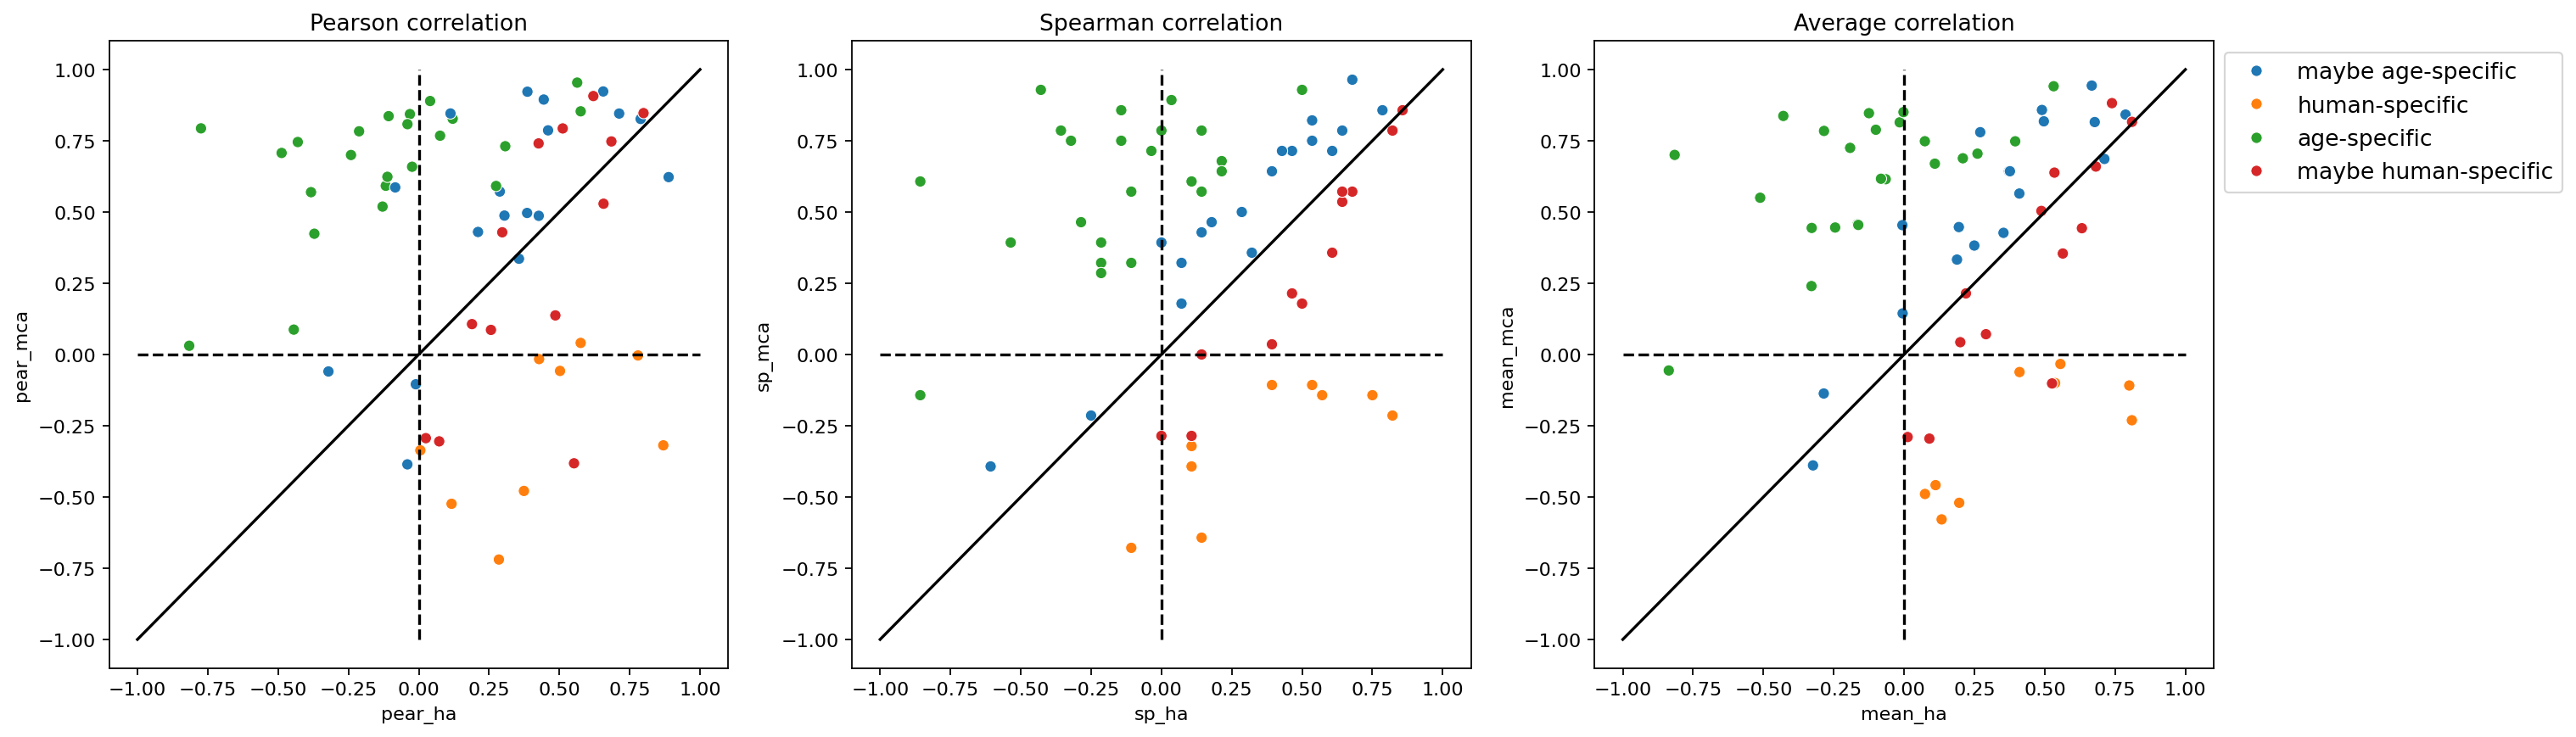

In [633]:
mpl.rcdefaults()

fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=80)

sns.scatterplot(corr_df_real, x='pear_ha', y='pear_mca', ax=ax[0], hue='label')
ax[0].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[0].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[0].plot([-1, 1], [-1, 1], '-', color='black')
ax[0].set_title('Pearson correlation')
ax[0].grid(False)
ax[0].get_legend().remove()

sns.scatterplot(corr_df_real, x='sp_ha', y='sp_mca', ax=ax[1], hue='label')
ax[1].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[1].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[1].plot([-1, 1], [-1, 1], '-', color='black')
ax[1].set_title('Spearman correlation')
ax[1].grid(False)
ax[1].get_legend().remove()

sns.scatterplot(corr_df_real, x='mean_ha', y='mean_mca', ax=ax[2], hue='label')
ax[2].hlines(y=0, xmin=-1, xmax=1, colors='black', linestyles='dashed')
ax[2].vlines(x=0, ymin=-1, ymax=1, colors='black', linestyles='dashed')
ax[2].plot([-1, 1], [-1, 1], '-', color='black')
ax[2].set_title('Average correlation')
ax[2].grid(False)
ax[2].legend(fontsize=8, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})

Text(0, 0.5, 'corr(adult vs newborn human) - corr(adult vs newborn macaque)')

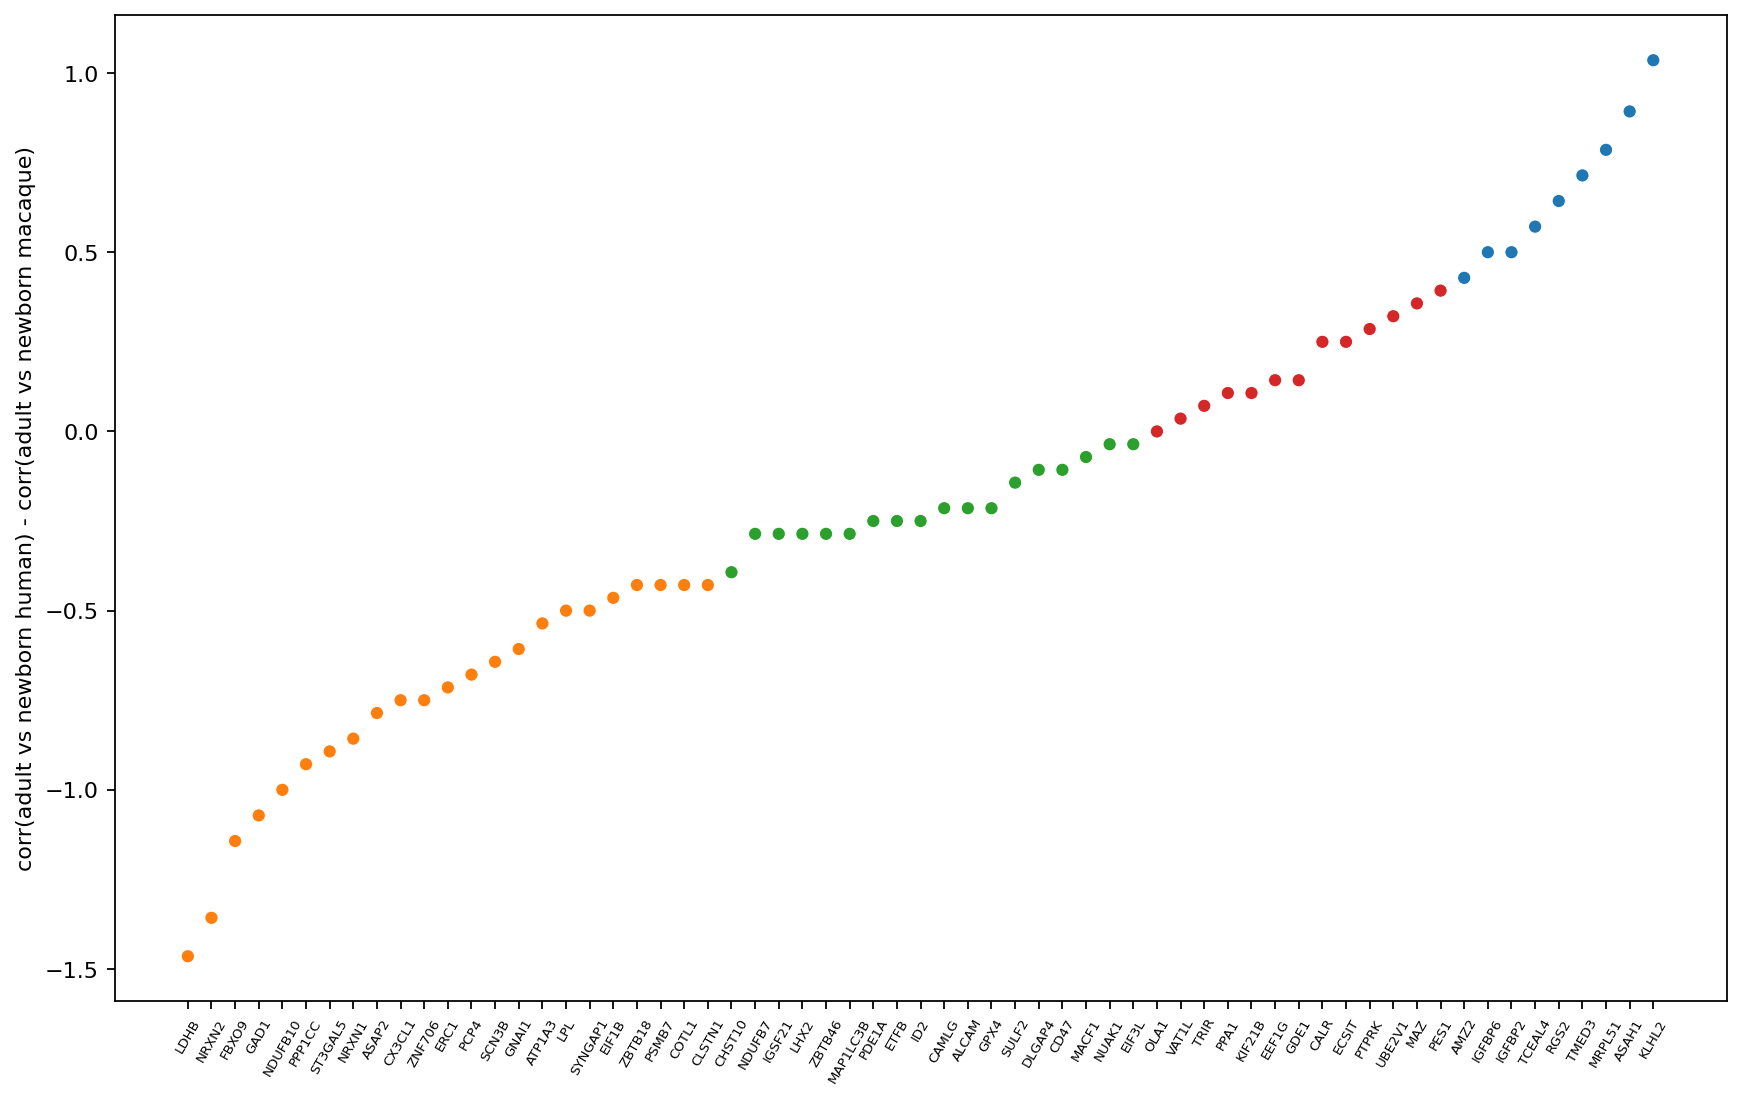

In [634]:
fig = plt.figure(figsize=(13, 8), dpi=80)
corr_df_real = corr_df_real.sort_values(by=corr_name)
color_dict_labels = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}
sns.scatterplot(corr_df_real[corr_name], color=corr_df_real.label.map(color_dict_labels))
plt.xticks(rotation=60, fontsize=6);
plt.ylabel("corr(adult vs newborn human) - corr(adult vs newborn macaque)", fontsize=10)

In [718]:
clust_labels = pd.read_csv('results/human_clusters_edgeR_4.csv', index_col=0)['0']
clust_labels.head()

ERC1      0
EIF3L     0
ID2       0
EEF1G     0
IGFBP6    0
Name: 0, dtype: int64

In [719]:
import plotly
merge_df = corr_df.label.to_frame().merge(clust_labels, left_index=True, right_index=True)
merge_df.columns = ['age_hs', 'cluster']
merge_df.head()

age_hs  cluster
LDHB     age-specific        2
ZBTB46   age-specific        1
FBXO9    age-specific        3
NDUFB10  age-specific        2
NRXN2    age-specific        1

In [720]:
sankey_df = merge_df.groupby('cluster').value_counts()
sankey_df.head(5)

cluster  age_hs              
0        age-specific            6
         maybe age-specific      5
         human-specific          1
         maybe human-specific    1
1        age-specific            6
Name: count, dtype: int64

In [721]:
from matplotlib.colors import to_hex

source_label = list(range(len(clust_labels.unique())))
target_label = ['human-specific', 'age-specific', 'maybe human-specific', 'maybe age-specific']
sankey_label = source_label + target_label

cmap = plt.get_cmap('Set3')
hex_colors = list(map(to_hex, cmap.colors))
source_color = hex_colors[:len(source_label)]
target_color = [to_hex(color_dict_labels[key]) for key in target_label]

source_list = []
target_list = []
value_list = []
link_color_sc = []
link_color_tar = []

for sc_lab, tg_lab in sankey_df.index.to_list():
    source_list.append(sankey_label.index(sc_lab))
    target_list.append(sankey_label.index(tg_lab))
    value_list.append(sankey_df.loc[sc_lab, tg_lab])
    link_color_sc.append(hex_colors[sc_lab])
    link_color_tar.append(to_hex(color_dict_labels[tg_lab]))

source_label = list(map(lambda x: f'clust{x}', source_label))
sankey_label = source_label + target_label

In [722]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = sankey_label,
      color = source_color + target_color
    ),
    link = dict(
      source = source_list, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target_list,
      value = value_list,
      color=link_color_sc
  ))])

fig.update_layout(title_text="Sankey Diagram", font_size=10)
fig.show()

## Functional analysis

In [635]:
common_hs_genes, len(common_hs_genes)

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RGS2', 'SCN3B', 'ST3GAL5', 'SULF2',
        'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1', 'VAT1L', 'ZBTB18',
        'ZBTB46', 'ZNF706'],
       dtype='object'),
 63)

In [636]:
gene_clust = list()
enrich_results = list()

for group in ['age-specific', 'maybe age-specific', 'maybe human-specific', 'human-specific']:
    gene_set = corr_df_real[corr_df_real.label == group].index.to_list()
    gene_clust.append(GeneCluster(gene_set, group, group, background_genes))
    time.sleep(1)

In [637]:
corr_df_real

pear_ha  pear_mca     sp_ha    sp_mca   kend_ha  kend_mca   mean_ha  \
LDHB    -0.774097  0.793505 -0.857143  0.607143 -0.714286  0.523810 -0.815620   
NRXN2   -0.429993  0.745498 -0.428571  0.928571 -0.238095  0.809524 -0.429282   
FBXO9   -0.212075  0.783183 -0.357143  0.785714 -0.238095  0.619048 -0.284609   
GAD1     0.120602  0.827264 -0.321429  0.750000 -0.142857  0.619048 -0.100413   
NDUFB10 -0.107048  0.836322 -0.142857  0.857143 -0.047619  0.714286 -0.124953   
...           ...       ...       ...       ...       ...       ...       ...   
RGS2     0.575585  0.040537  0.535714 -0.107143  0.428571 -0.047619  0.555649   
TMED3    0.502161 -0.057731  0.571429 -0.142857  0.428571 -0.142857  0.536795   
MRPL51   0.005668 -0.336321  0.142857 -0.642857  0.142857 -0.523810  0.074262   
ASAH1    0.869352 -0.318858  0.750000 -0.142857  0.619048 -0.047619  0.809676   
KLHL2    0.779317 -0.003453  0.821429 -0.214286  0.619048 -0.142857  0.800373   

         mean_mca  corr_diff  pear_diff   sp_diff  kend_diff           label  
LDHB     0.700324  -1.515944  -1.567602 -1.464286  -1.238095    age-specific  
NRXN2    0.837035  -1.266317  -1.175492 -1.357143  -1.047619    age-specific  
FBXO9    0.784449  -1.069057  -0.995258 -1.142857  -0.857143    age-specific  
GAD1     0.788632  -0.889045  -0.706662 -1.071429  -0.761905    age-specific  
NDUFB10  0.846733  -0.971685  -0.943370 -1.000000  -0.761905    age-specific  
...           ...        ...        ...       ...        ...             ...  
RGS2    -0.033303   0.588952   0.535047  0.642857   0.476190  human-specific  
TMED3   -0.100294   0.637089   0.559892  0.714286   0.571429  human-specific  
MRPL51  -0.489589   0.563852   0.341989  0.785714   0.666667  human-specific  
ASAH1   -0.230858   1.040534   1.188210  0.892857   0.666667  human-specific  
KLHL2   -0.108869   0.909242   0.782769  1.035714   0.761905  human-specific  

[63 rows x 13 columns]

## GO_Biological_Process_2023

In [638]:
db_name = 'GO_Biological_Process_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [639]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank    p-val     Z-score  \
Term                                                                            
Vocal Learning (GO:0042297)                            1  0.00005  369.761905   
Imitative Learning (GO:0098596)                        2  0.00005  369.761905   
Auditory Behavior (GO:0031223)                         3  0.00005  369.761905   
Learned Vocalization Behavior Or Vocal Learning...     4  0.00005  369.761905   
Postsynaptic Density Assembly (GO:0097107)             5  0.00005  369.761905   

                                                    Combined score  \
Term                                                                 
Vocal Learning (GO:0042297)                            3663.014138   
Imitative Learning (GO:0098596)                        3663.014138   
Auditory Behavior (GO:0031223)                         3663.014138   
Learned Vocalization Behavior Or Vocal Learning...     3663.014138   
Postsynaptic Density Assembly (GO:0097107)             3663.014138   

                                                   Overlapping genes  \
Term                                                                   
Vocal Learning (GO:0042297)                           [NRXN1, NRXN2]   
Imitative Learning (GO:0098596)                       [NRXN1, NRXN2]   
Auditory Behavior (GO:0031223)                        [NRXN1, NRXN2]   
Learned Vocalization Behavior Or Vocal Learning...    [NRXN1, NRXN2]   
Postsynaptic Density Assembly (GO:0097107)            [NRXN1, NRXN2]   

                                                    Adjusted P-value  \
Term                                                                   
Vocal Learning (GO:0042297)                                 0.003071   
Imitative Learning (GO:0098596)                             0.003071   
Auditory Behavior (GO:0031223)                              0.003071   
Learned Vocalization Behavior Or Vocal Learning...          0.003071   
Postsynaptic Density Assembly (GO:0097107)                  0.003071   

                                                    Old p-value  \
Term                                                              
Vocal Learning (GO:0042297)                                   0   
Imitative Learning (GO:0098596)                               0   
Auditory Behavior (GO:0031223)                                0   
Learned Vocalization Behavior Or Vocal Learning...            0   
Postsynaptic Density Assembly (GO:0097107)                    0   

                                                    Old adjusted p-value  \
Term                                                                       
Vocal Learning (GO:0042297)                                            0   
Imitative Learning (GO:0098596)                                        0   
Auditory Behavior (GO:0031223)                                         0   
Learned Vocalization Behavior Or Vocal Learning...                     0   
Postsynaptic Density Assembly (GO:0097107)                             0   

                                                    num_overlap_genes  \
Term                                                                    
Vocal Learning (GO:0042297)                                         2   
Imitative Learning (GO:0098596)                                     2   
Auditory Behavior (GO:0031223)                                      2   
Learned Vocalization Behavior Or Vocal Learning...                  2   
Postsynaptic Density Assembly (GO:0097107)                          2   

                                                    neg_log10(p_adj)  \
Term                                                                   
Vocal Learning (GO:0042297)                                  2.51272   
Imitative Learning (GO:0098596)                              2.51272   
Auditory Behavior (GO:0031223)                               2.51272   
Learned Vocalization Behavior Or Vocal Learning...           2.51272   
Postsynaptic Density Assembly (GO:00

In [640]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

36

In [641]:
enrich_res[enrich_res.cluster_label == 5]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [642]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

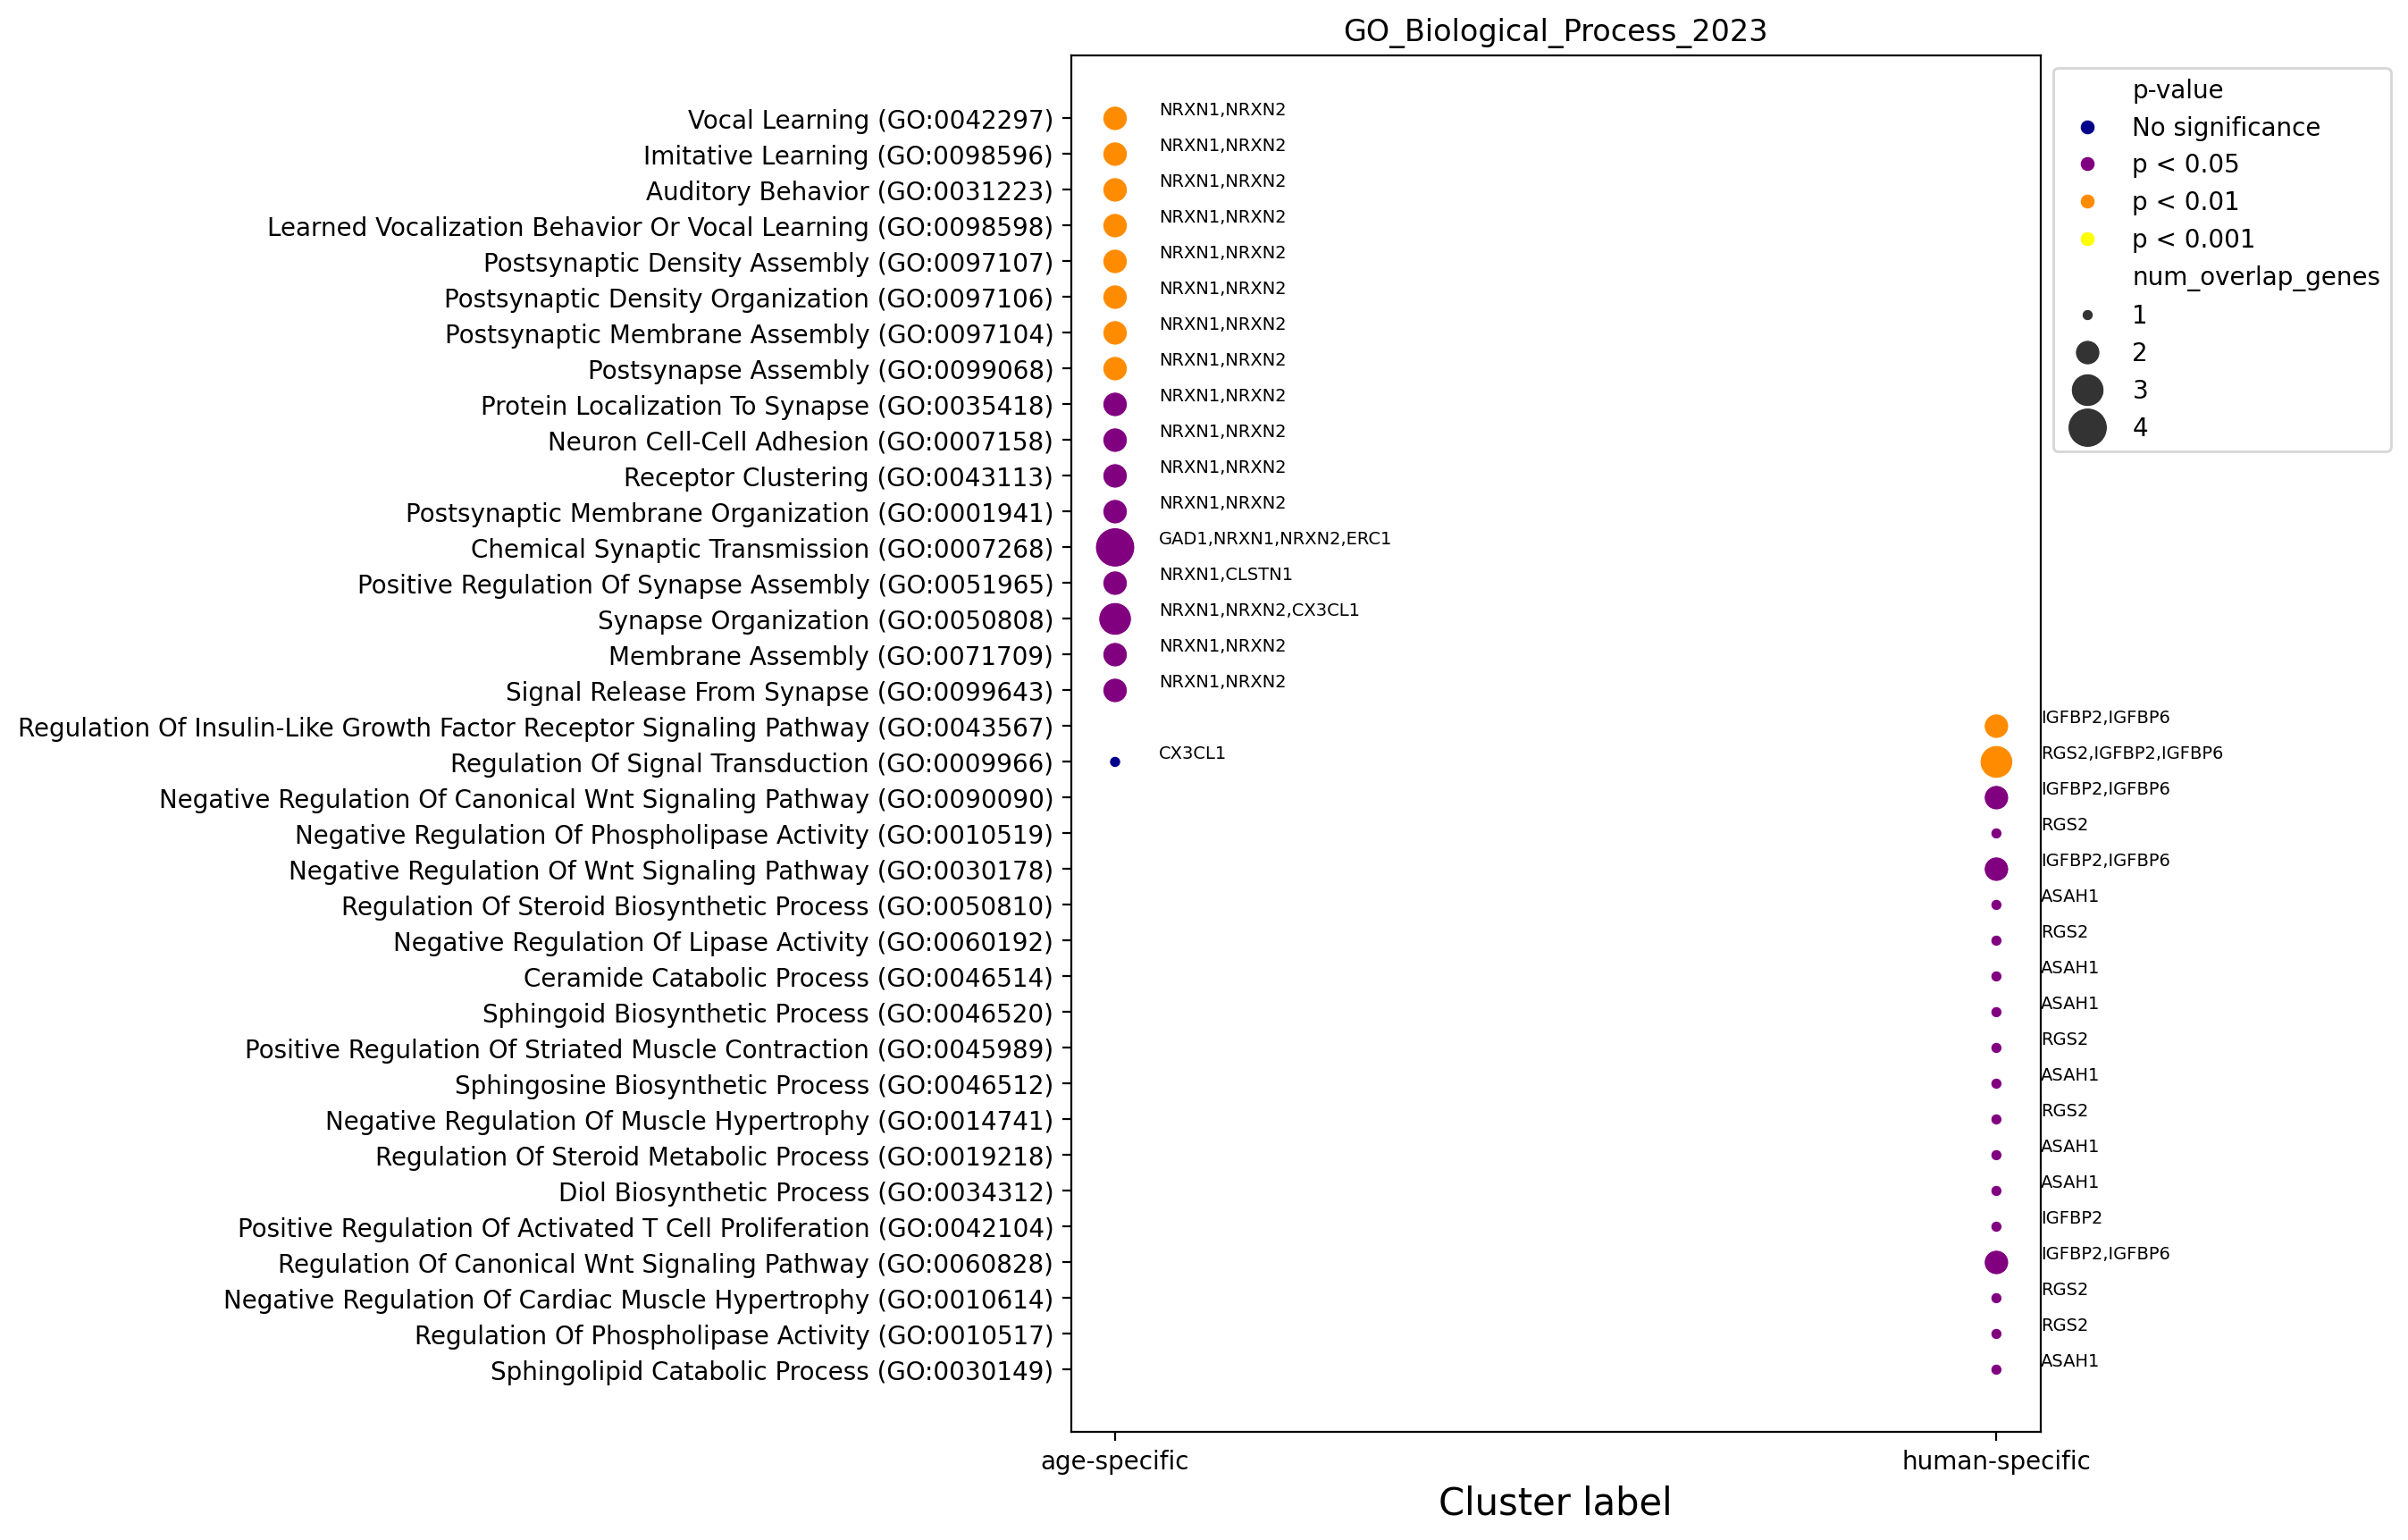

In [643]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

x_ticks = ax.get_xticklabels()
x_ticks_pos = {text_obj.get_text():text_obj.get_position()[0] for text_obj in x_ticks}

y_ticks = ax.get_yticklabels()
y_ticks_pos = {text_obj.get_text():text_obj.get_position()[1] for text_obj in y_ticks}

text_df = enrich_res_plot.reset_index().copy()
for i in range(text_df.shape[0]):
    text_df_sub = text_df.iloc[i, :].to_dict()
    x=x_ticks_pos[text_df_sub['cluster_label']]
    y=y_ticks_pos[text_df_sub['Term']]
    text = ','.join(text_df_sub['Overlapping genes'])
    #ax.annotate(text, (x, y), xycoords='data', xytext=(x + 0.1, y - 0.1), textcoords='data', arrowprops={'arrowstyle': '-'})
    ax.text(x + 0.05, y - 0.1, text, fontsize=7)

## GO_Molecular_Function_2023

In [644]:
db_name = 'GO_Molecular_Function_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [645]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Calcium Channel Regulator Activity (GO:0005246)        1  0.001240   
Lactate Dehydrogenase Activity (GO:0004457)            2  0.002952   
Amyloid-Beta Binding (GO:0001540)                      3  0.007316   
Chemokine Activity (GO:0008009)                        4  0.008832   
P-type Potassium Transmembrane Transporter Acti...     5  0.008832   

                                                       Z-score  \
Term                                                             
Calcium Channel Regulator Activity (GO:0005246)      46.136905   
Lactate Dehydrogenase Activity (GO:0004457)                inf   
Amyloid-Beta Binding (GO:0001540)                    17.517007   
Chemokine Activity (GO:0008009)                     176.477273   
P-type Potassium Transmembrane Transporter Acti...  176.477273   

                                                    Combined score  \
Term                                                                 
Calcium Channel Regulator Activity (GO:0005246)         308.788368   
Lactate Dehydrogenase Activity (GO:0004457)                    inf   
Amyloid-Beta Binding (GO:0001540)                        86.142730   
Chemokine Activity (GO:0008009)                         834.618621   
P-type Potassium Transmembrane Transporter Acti...      834.618621   

                                                   Overlapping genes  \
Term                                                                   
Calcium Channel Regulator Activity (GO:0005246)       [NRXN1, NRXN2]   
Lactate Dehydrogenase Activity (GO:0004457)                   [LDHB]   
Amyloid-Beta Binding (GO:0001540)                   [CLSTN1, ATP1A3]   
Chemokine Activity (GO:0008009)                             [CX3CL1]   
P-type Potassium Transmembrane Transporter Acti...          [ATP1A3]   

                                                    Adjusted P-value  \
Term                                                                   
Calcium Channel Regulator Activity (GO:0005246)             0.068451   
Lactate Dehydrogenase Activity (GO:0004457)                 0.068451   
Amyloid-Beta Binding (GO:0001540)                           0.068451   
Chemokine Activity (GO:0008009)                             0.068451   
P-type Potassium Transmembrane Transporter Acti...          0.068451   

                                                    Old p-value  \
Term                                                              
Calcium Channel Regulator Activity (GO:0005246)               0   
Lactate Dehydrogenase Activity (GO:0004457)                   0   
Amyloid-Beta Binding (GO:0001540)                             0   
Chemokine Activity (GO:0008009)                               0   
P-type Potassium Transmembrane Transporter Acti...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Calcium Channel Regulator Activity (GO:0005246)                        0   
Lactate Dehydrogenase Activity (GO:0004457)                            0   
Amyloid-Beta Binding (GO:0001540)                                      0   
Chemokine Activity (GO:0008009)                                        0   
P-type Potassium Transmembrane Transporter Acti...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Calcium Channel Regulator Activity (GO:0005246)                     2   
Lactate Dehydrogenase Activity (GO:0004457)                         1   
Amyloid-Beta Binding (GO:0001540)                                   2   
Chemokine Activity (GO:0008009)                                     1   
P-type Potassium Transmembrane Transporter Acti...                  1   

                                                    neg_log10(p_adj)  \
Term      

In [646]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

4

In [647]:
enrich_res[enrich_res.cluster_label == 5]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [648]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

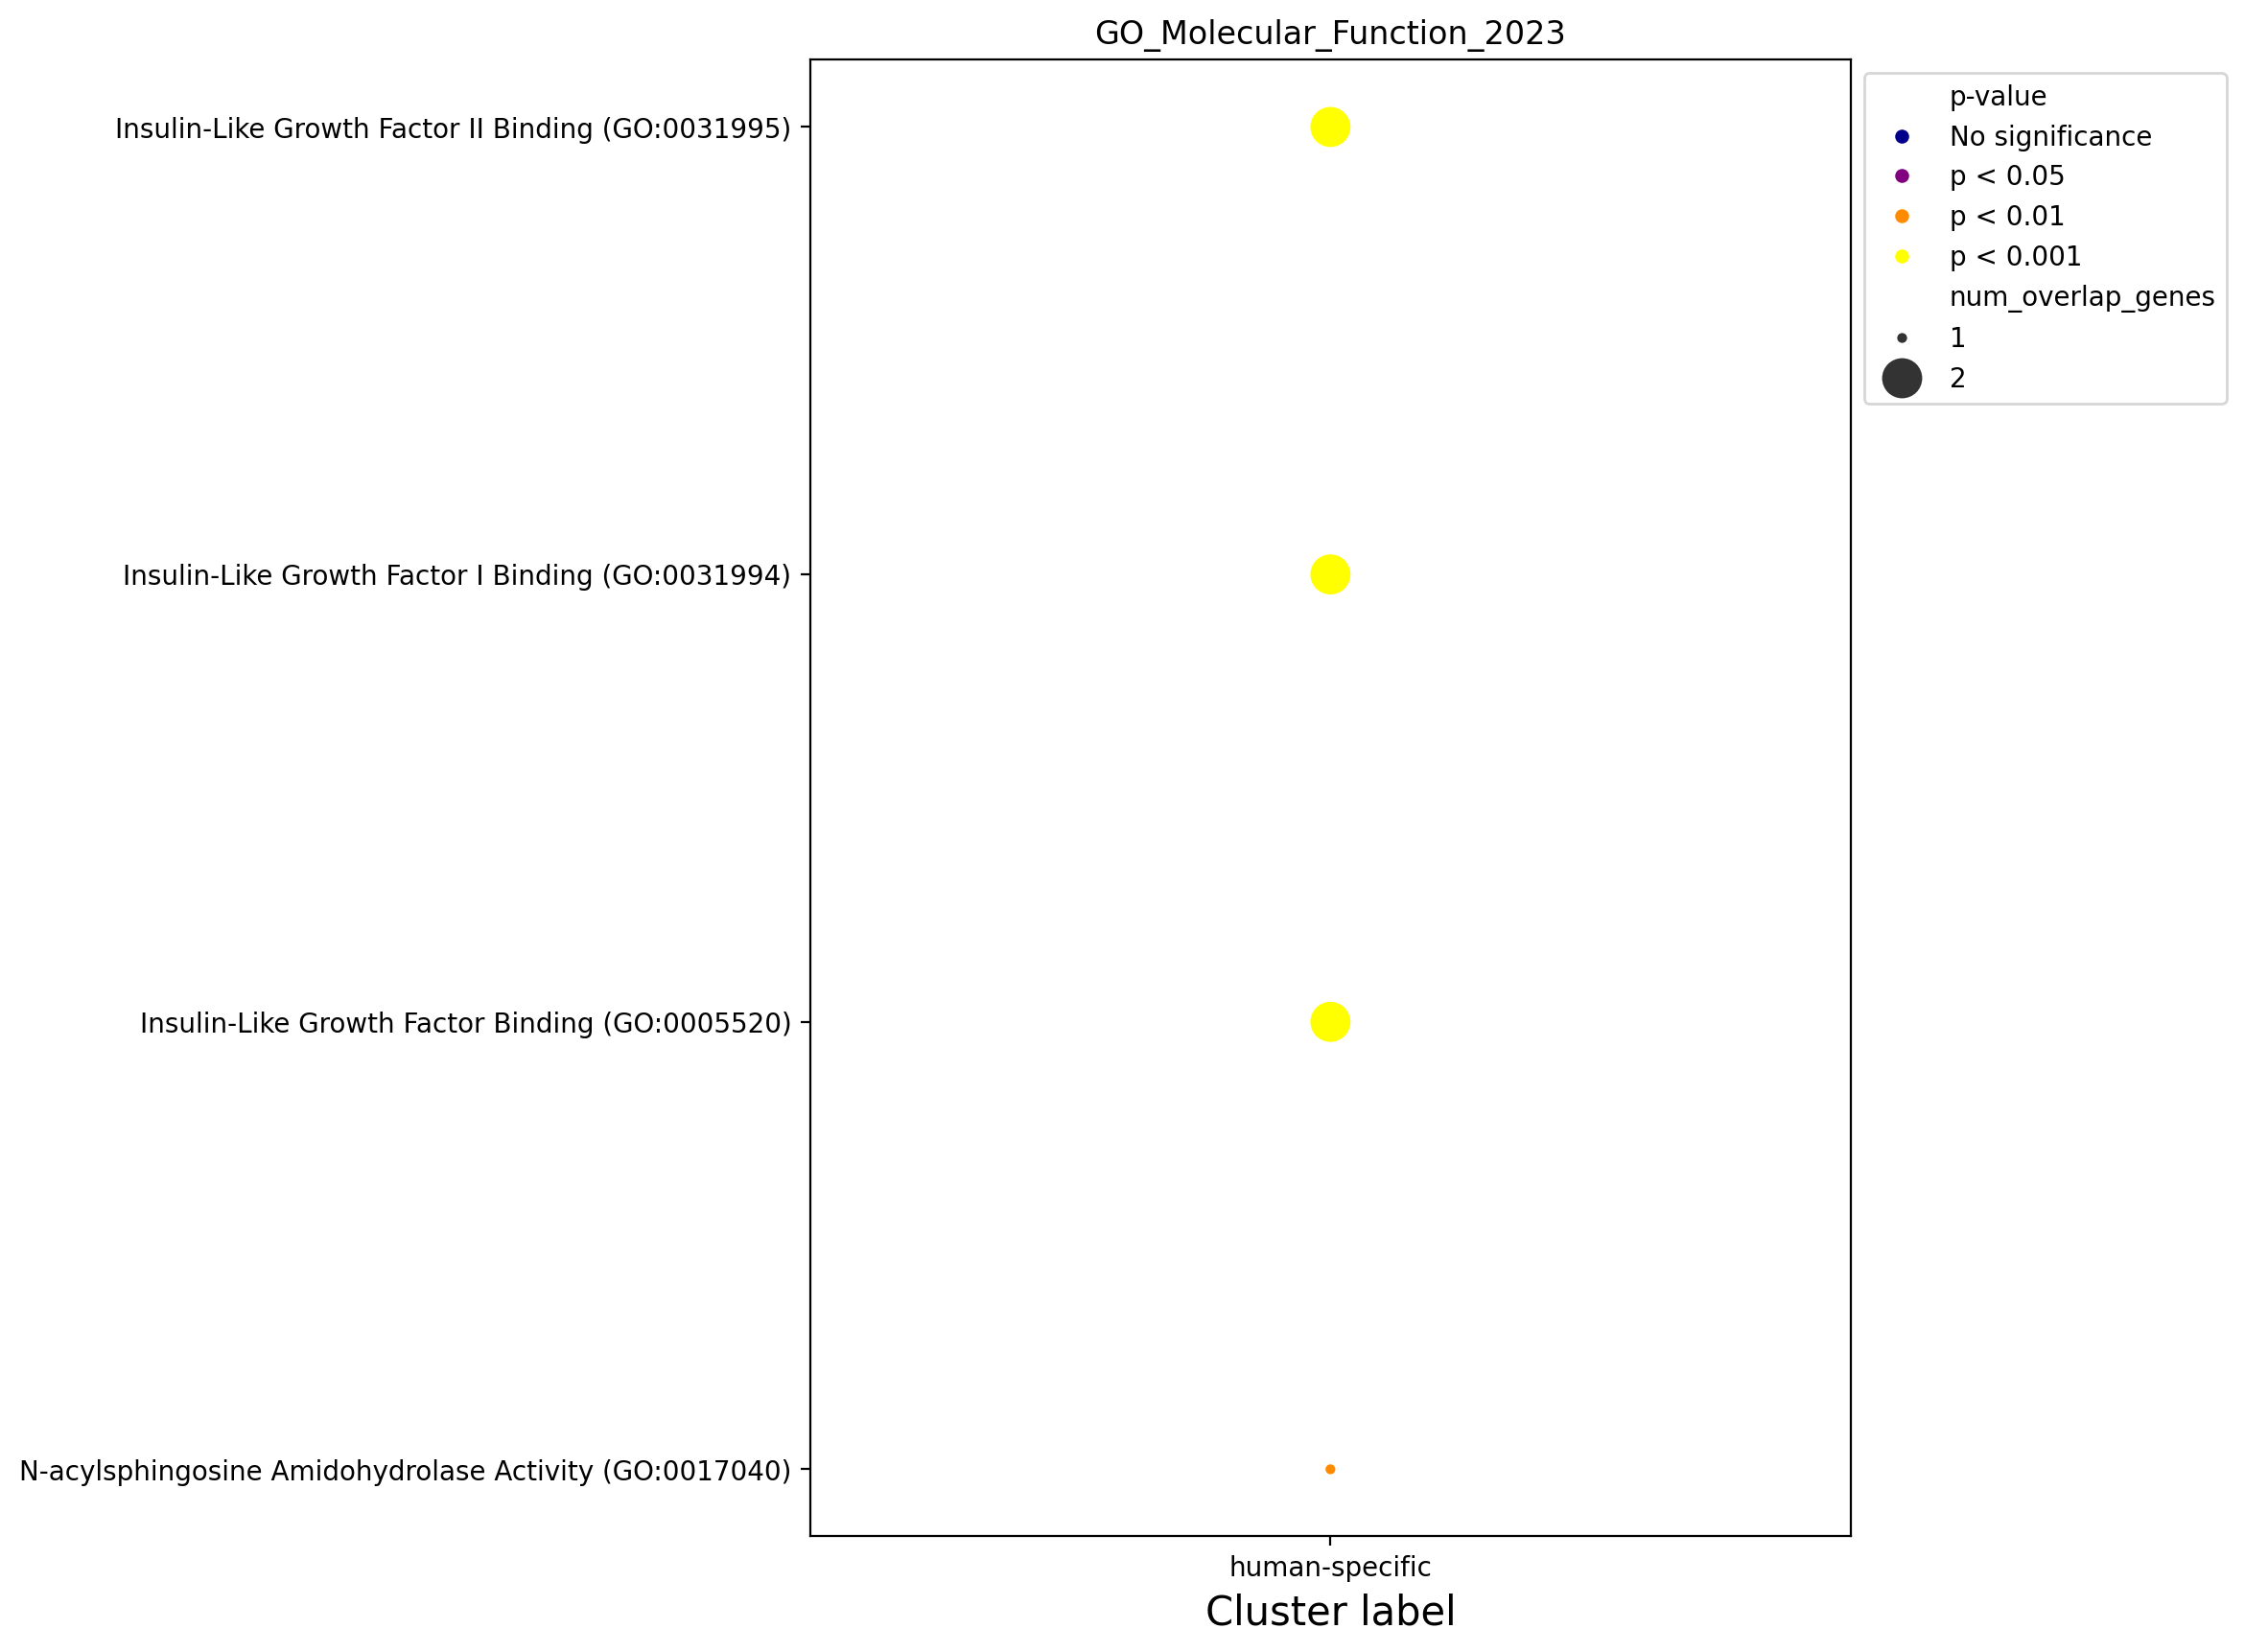

In [649]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## GO_Cellular_Component_2023

In [650]:
db_name = 'GO_Cellular_Component_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [651]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Vesicle (GO:0031982)                                   1  0.005042   9.807692   
Cortical Cytoskeleton (GO:0030863)                     2  0.005496  20.452381   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...     3  0.014679  88.215909   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...     4  0.014679  88.215909   
Voltage-Gated Sodium Channel Complex (GO:0001518)      5  0.014679  88.215909   

                                                    Combined score  \
Term                                                                 
Vesicle (GO:0031982)                                     51.882894   
Cortical Cytoskeleton (GO:0030863)                      106.430284   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...      372.387796   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...      372.387796   
Voltage-Gated Sodium Channel Complex (GO:0001518)       372.387796   

                                                        Overlapping genes  \
Term                                                                        
Vesicle (GO:0031982)                                [GAD1, NRXN1, ATP1A3]   
Cortical Cytoskeleton (GO:0030863)                          [COTL1, ERC1]   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                 [GAD1]   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                 [GAD1]   
Voltage-Gated Sodium Channel Complex (GO:0001518)                 [SCN3B]   

                                                    Adjusted P-value  \
Term                                                                   
Vesicle (GO:0031982)                                        0.097735   
Cortical Cytoskeleton (GO:0030863)                          0.097735   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          0.097735   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          0.097735   
Voltage-Gated Sodium Channel Complex (GO:0001518)           0.097735   

                                                    Old p-value  \
Term                                                              
Vesicle (GO:0031982)                                          0   
Cortical Cytoskeleton (GO:0030863)                            0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...            0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...            0   
Voltage-Gated Sodium Channel Complex (GO:0001518)             0   

                                                    Old adjusted p-value  \
Term                                                                       
Vesicle (GO:0031982)                                                   0   
Cortical Cytoskeleton (GO:0030863)                                     0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                     0   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                     0   
Voltage-Gated Sodium Channel Complex (GO:0001518)                      0   

                                                    num_overlap_genes  \
Term                                                                    
Vesicle (GO:0031982)                                                3   
Cortical Cytoskeleton (GO:0030863)                                  2   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                  1   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...                  1   
Voltage-Gated Sodium Channel Complex (GO:0001518)                   1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Vesicle (GO:0031982)                                        1.009949   
Cortical Cytoskeleton (GO:0030863)                          1.009949   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          1.009949   
Clathrin-Sculpted Gamma-Aminobutyric Acid Trans...          1.009949   
V

In [652]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

0

In [653]:
enrich_res[enrich_res.cluster_label == 5]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [654]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_28700\1472615517.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


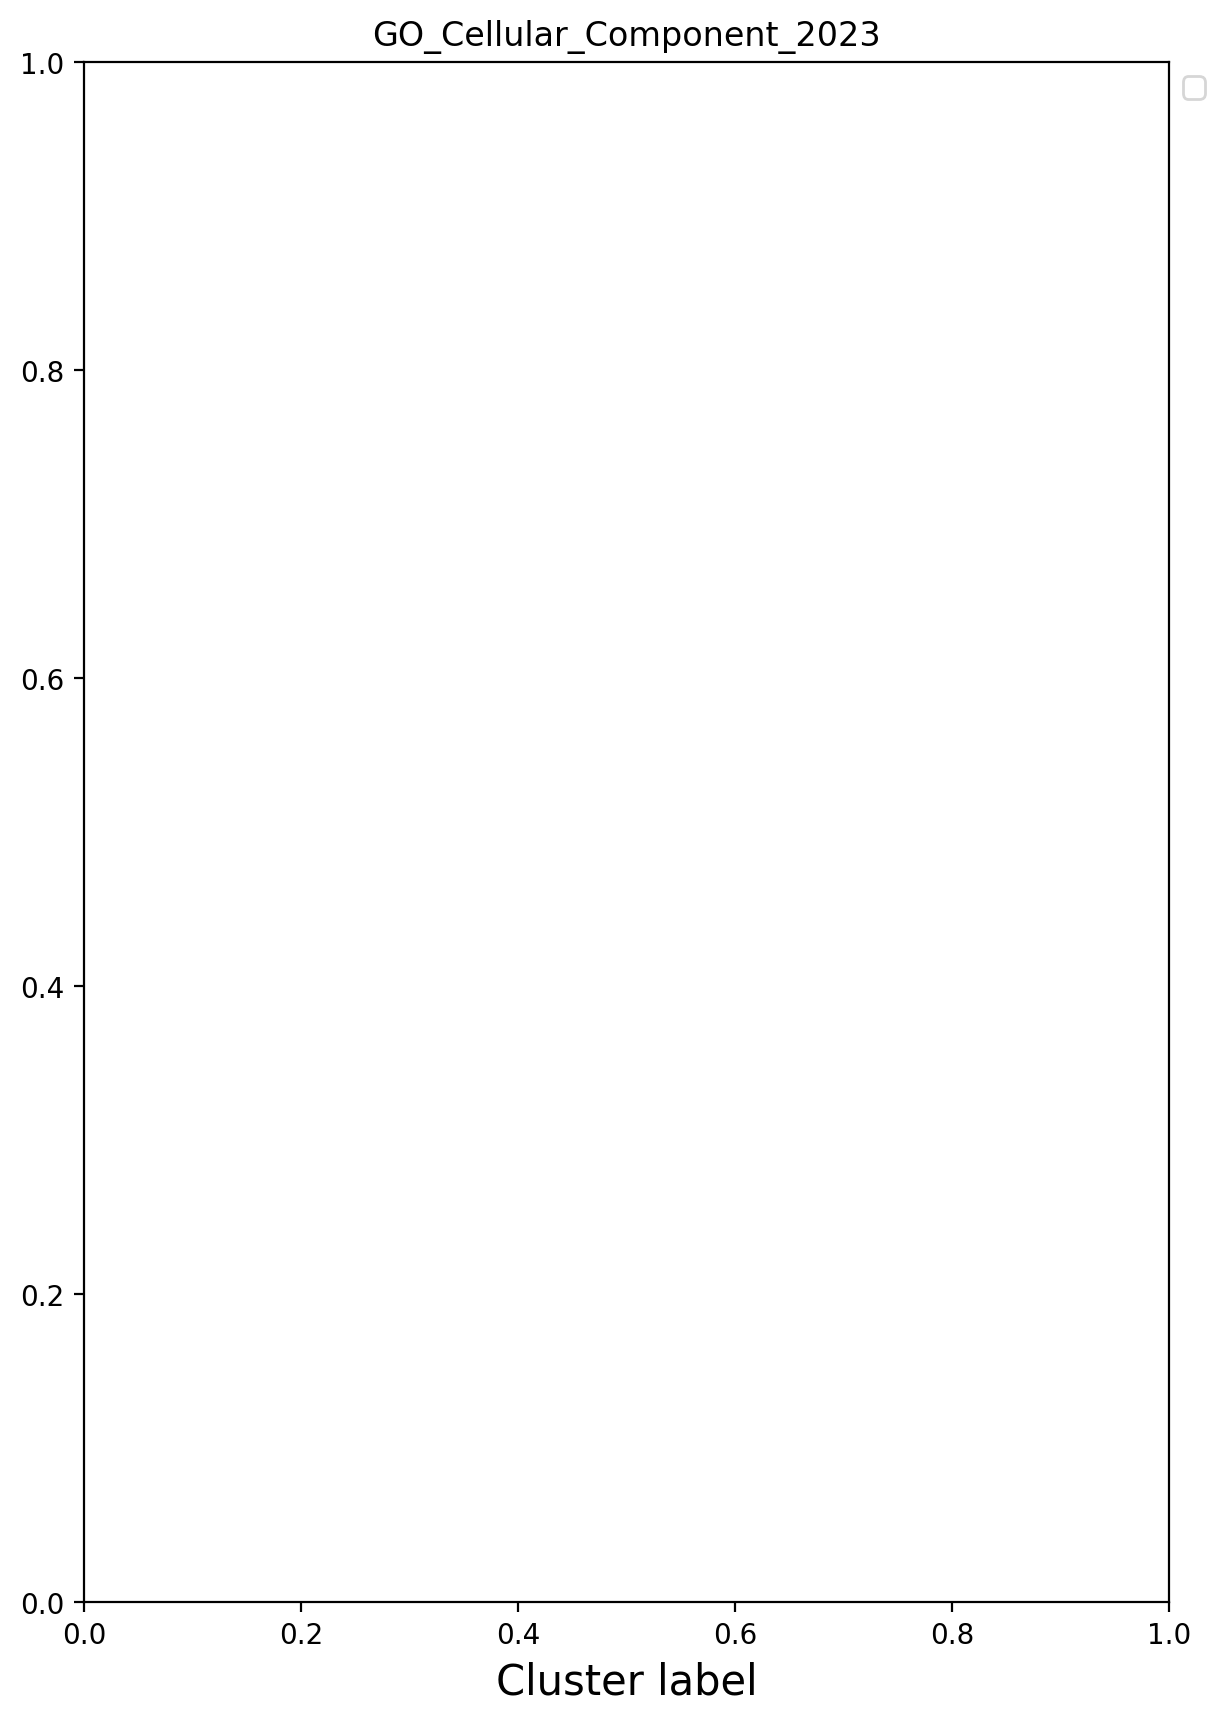

In [655]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## WikiPathway_2023_Human

In [656]:
db_name = 'WikiPathway_2023_Human'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [657]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Disruption Of Postsynaptic Signaling By CNV WP4875     1  0.000070   
Common Pathways Underlying Drug Addiction WP2636       2  0.003919   
Lipid Particles Composition WP3601                     3  0.005897   
Familial Hyperlipidemia Type 2 WP5109                  4  0.008832   
Metabolic Pathway Of LDL HDL And TG Including D...     5  0.011760   

                                                       Z-score  \
Term                                                             
Disruption Of Postsynaptic Signaling By CNV WP4875   46.452000   
Common Pathways Underlying Drug Addiction WP2636     24.561905   
Lipid Particles Composition WP3601                  353.000000   
Familial Hyperlipidemia Type 2 WP5109               176.477273   
Metabolic Pathway Of LDL HDL And TG Including D...  117.636364   

                                                    Combined score  \
Term                                                                 
Disruption Of Postsynaptic Signaling By CNV WP4875      444.276143   
Common Pathways Underlying Drug Addiction WP2636        136.118202   
Lipid Particles Composition WP3601                     1812.083364   
Familial Hyperlipidemia Type 2 WP5109                   834.618621   
Metabolic Pathway Of LDL HDL And TG Including D...      522.664863   

                                                          Overlapping genes  \
Term                                                                          
Disruption Of Postsynaptic Signaling By CNV WP4875  [SYNGAP1, NRXN1, NRXN2]   
Common Pathways Underlying Drug Addiction WP2636            [PPP1CC, GNAI1]   
Lipid Particles Composition WP3601                                    [LPL]   
Familial Hyperlipidemia Type 2 WP5109                                 [LPL]   
Metabolic Pathway Of LDL HDL And TG Including D...                    [LPL]   

                                                    Adjusted P-value  \
Term                                                                   
Disruption Of Postsynaptic Signaling By CNV WP4875          0.005546   
Common Pathways Underlying Drug Addiction WP2636            0.094348   
Lipid Particles Composition WP3601                          0.094348   
Familial Hyperlipidemia Type 2 WP5109                       0.094348   
Metabolic Pathway Of LDL HDL And TG Including D...          0.094348   

                                                    Old p-value  \
Term                                                              
Disruption Of Postsynaptic Signaling By CNV WP4875            0   
Common Pathways Underlying Drug Addiction WP2636              0   
Lipid Particles Composition WP3601                            0   
Familial Hyperlipidemia Type 2 WP5109                         0   
Metabolic Pathway Of LDL HDL And TG Including D...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Disruption Of Postsynaptic Signaling By CNV WP4875                     0   
Common Pathways Underlying Drug Addiction WP2636                       0   
Lipid Particles Composition WP3601                                     0   
Familial Hyperlipidemia Type 2 WP5109                                  0   
Metabolic Pathway Of LDL HDL And TG Including D...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Disruption Of Postsynaptic Signaling By CNV WP4875                  3   
Common Pathways Underlying Drug Addiction WP2636                    2   
Lipid Particles Composition WP3601                                  1   
Familial Hyperlipidemia Type 2 WP5109                               1   
Metabolic Pathway Of LDL HDL And TG Including D...                  1   

                                 

In [658]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

16

In [659]:
enrich_res[enrich_res.cluster_label == 5]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [660]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

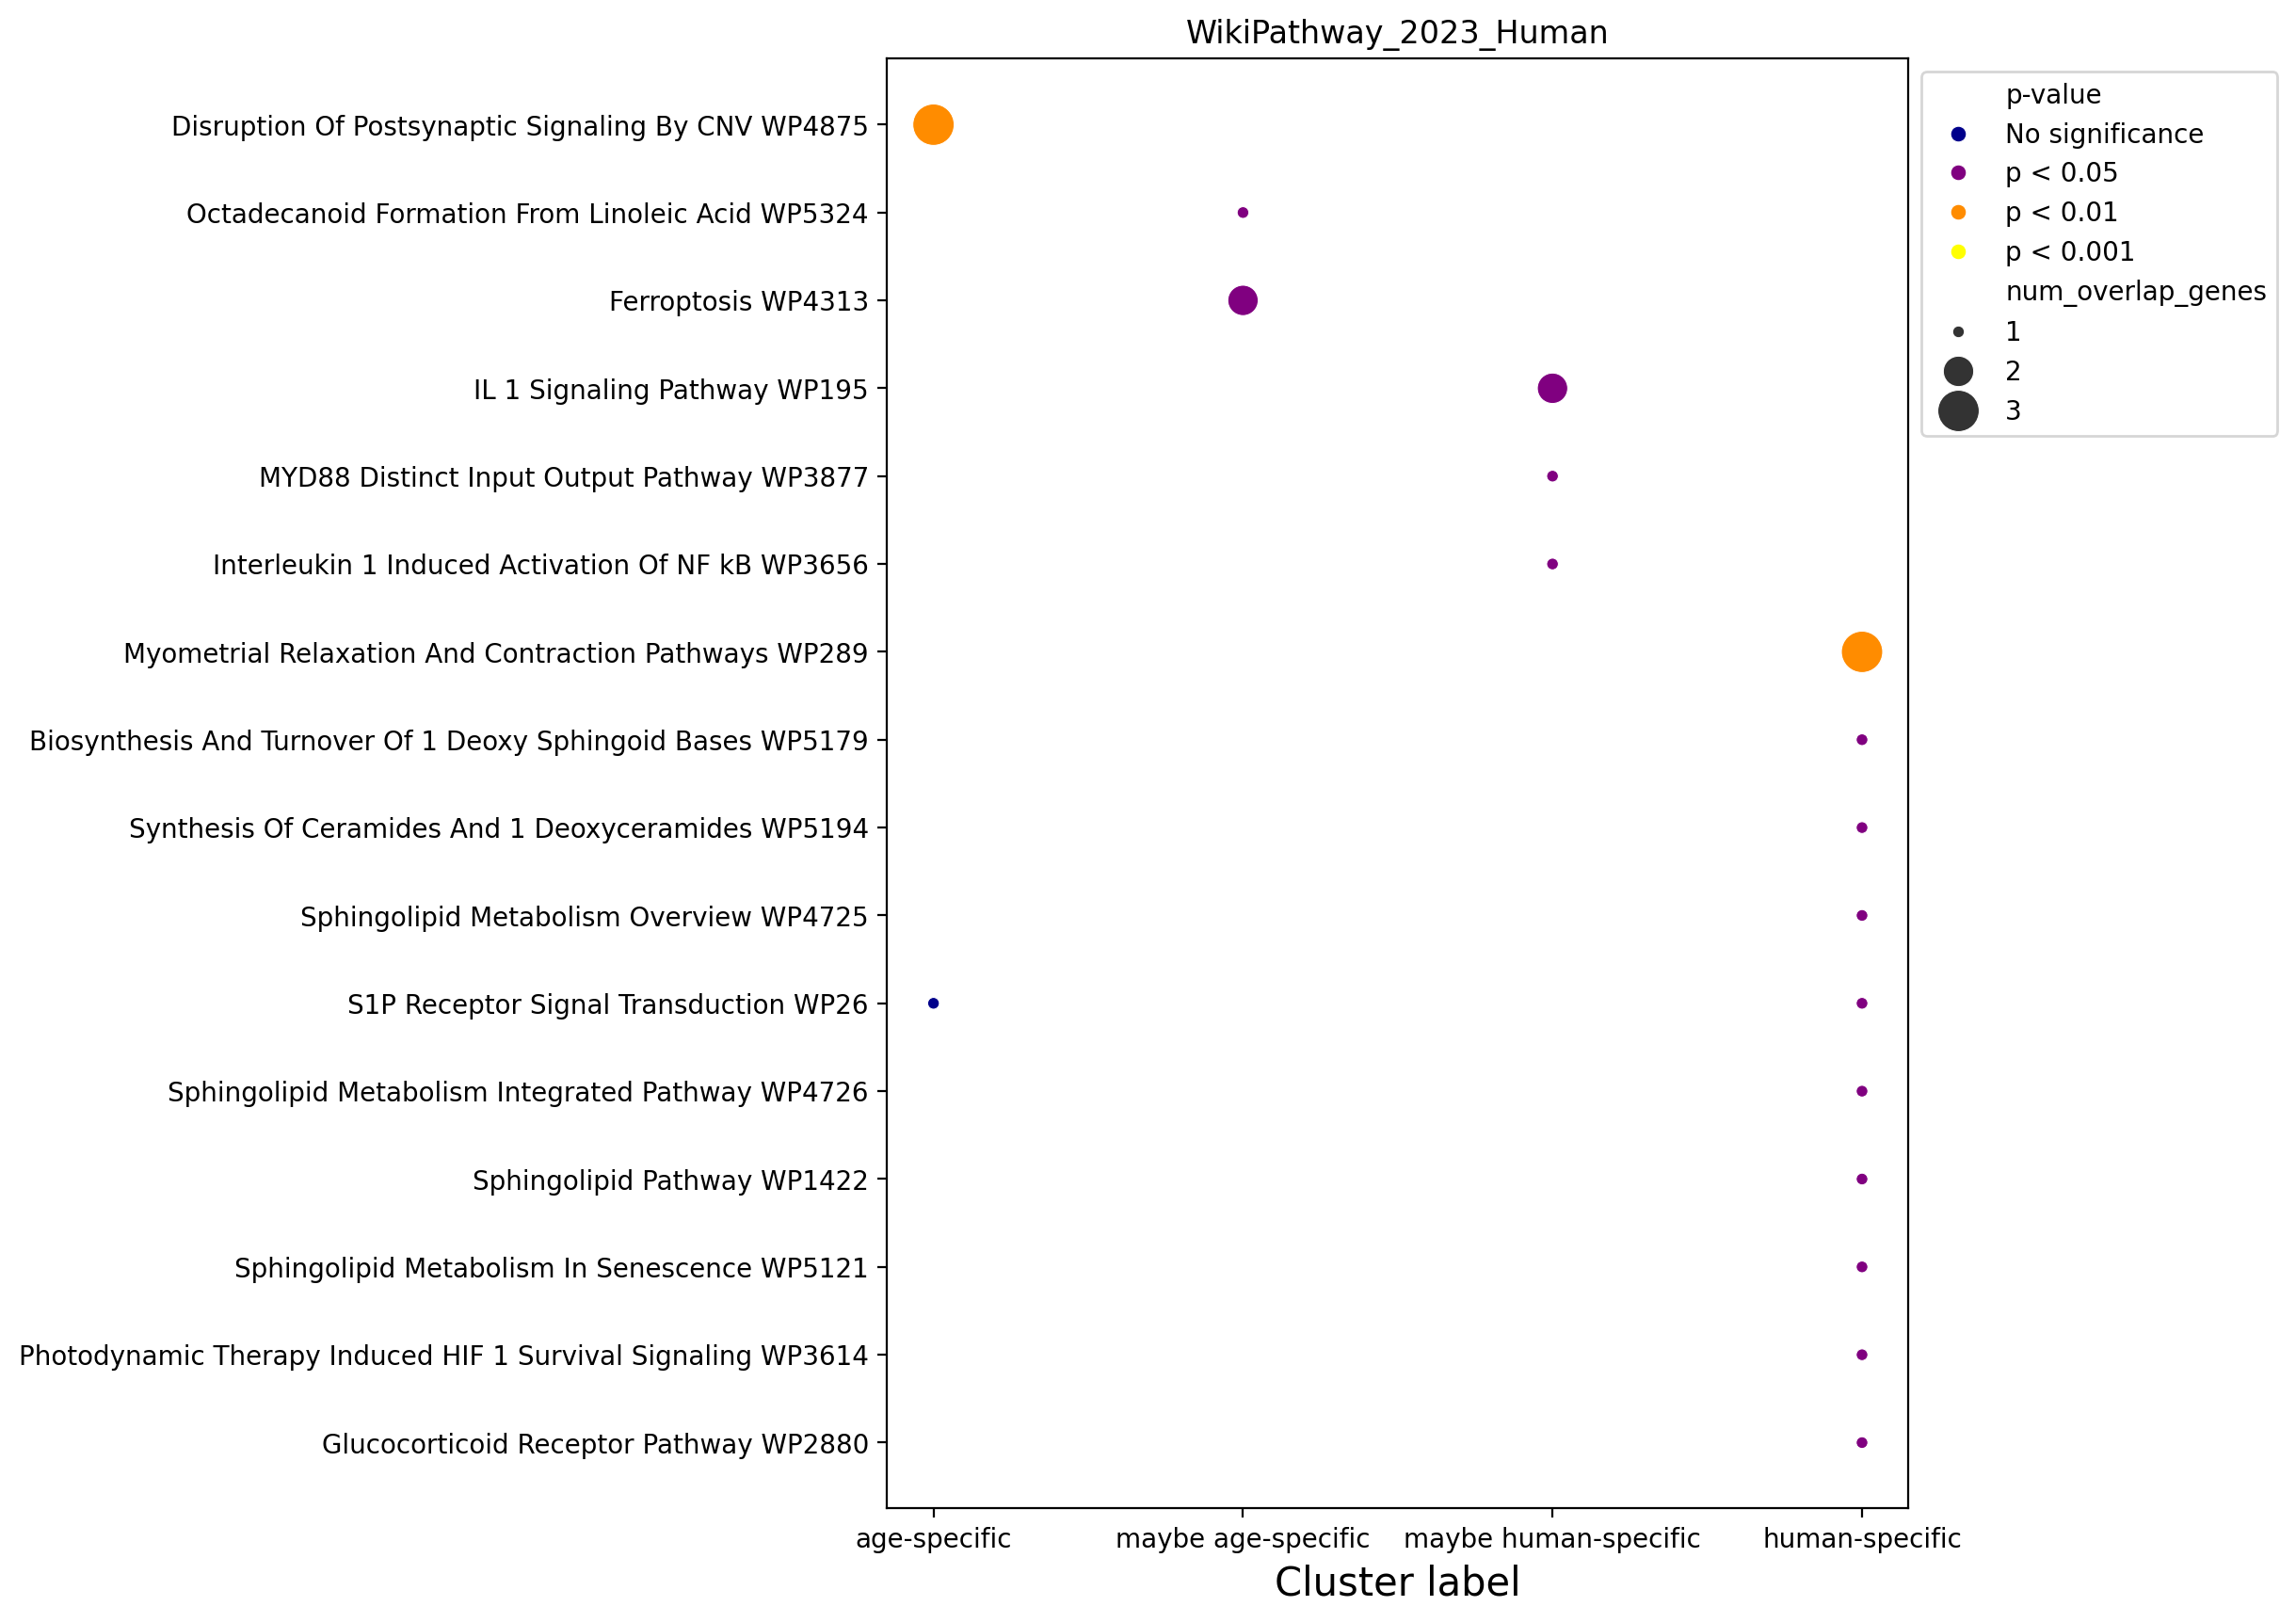

In [661]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth_2023


In [662]:
db_name = 'Azimuth_2023'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [663]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  Z-score  \
Term                                                             
Tonsil-L2-aDC2                            1  0.002952      inf   
Adipose-L1-Monocyte                       2  0.002952      inf   
Lung V2 (HLCA)-ann Level 4-Suprabasal     3  0.005897    353.0   
PBMC-L3-Double-negative T 1               4  0.005897    353.0   
PBMC-L2-CD8+ Central Memory T             5  0.005897    353.0   

                                       Combined score Overlapping genes  \
Term                                                                      
Tonsil-L2-aDC2                                    inf           [NRXN2]   
Adipose-L1-Monocyte                               inf           [COTL1]   
Lung V2 (HLCA)-ann Level 4-Suprabasal     1812.083364            [LDHB]   
PBMC-L3-Double-negative T 1               1812.083364            [LDHB]   
PBMC-L2-CD8+ Central Memory T             1812.083364            [LDHB]   

                                       Adjusted P-value  Old p-value  \
Term                                                                   
Tonsil-L2-aDC2                                  0.01986            0   
Adipose-L1-Monocyte                             0.01986            0   
Lung V2 (HLCA)-ann Level 4-Suprabasal           0.01986            0   
PBMC-L3-Double-negative T 1                     0.01986            0   
PBMC-L2-CD8+ Central Memory T                   0.01986            0   

                                       Old adjusted p-value  \
Term                                                          
Tonsil-L2-aDC2                                            0   
Adipose-L1-Monocyte                                       0   
Lung V2 (HLCA)-ann Level 4-Suprabasal                     0   
PBMC-L3-Double-negative T 1                               0   
PBMC-L2-CD8+ Central Memory T                             0   

                                       num_overlap_genes  neg_log10(p_adj)  \
Term                                                                         
Tonsil-L2-aDC2                                         1          1.702018   
Adipose-L1-Monocyte                                    1          1.702018   
Lung V2 (HLCA)-ann Level 4-Suprabasal                  1          1.702018   
PBMC-L3-Double-negative T 1                            1          1.702018   
PBMC-L2-CD8+ Central Memory T                          1          1.702018   

                                      cluster_label  
Term                                                 
Tonsil-L2-aDC2                         age-specific  
Adipose-L1-Monocyte                    age-specific  
Lung V2 (HLCA)-ann Level 4-Suprabasal  age-specific  
PBMC-L3-Double-negative T 1            age-specific  
PBMC-L2-CD8+ Central Memory T          age-specific

In [664]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

35

In [665]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

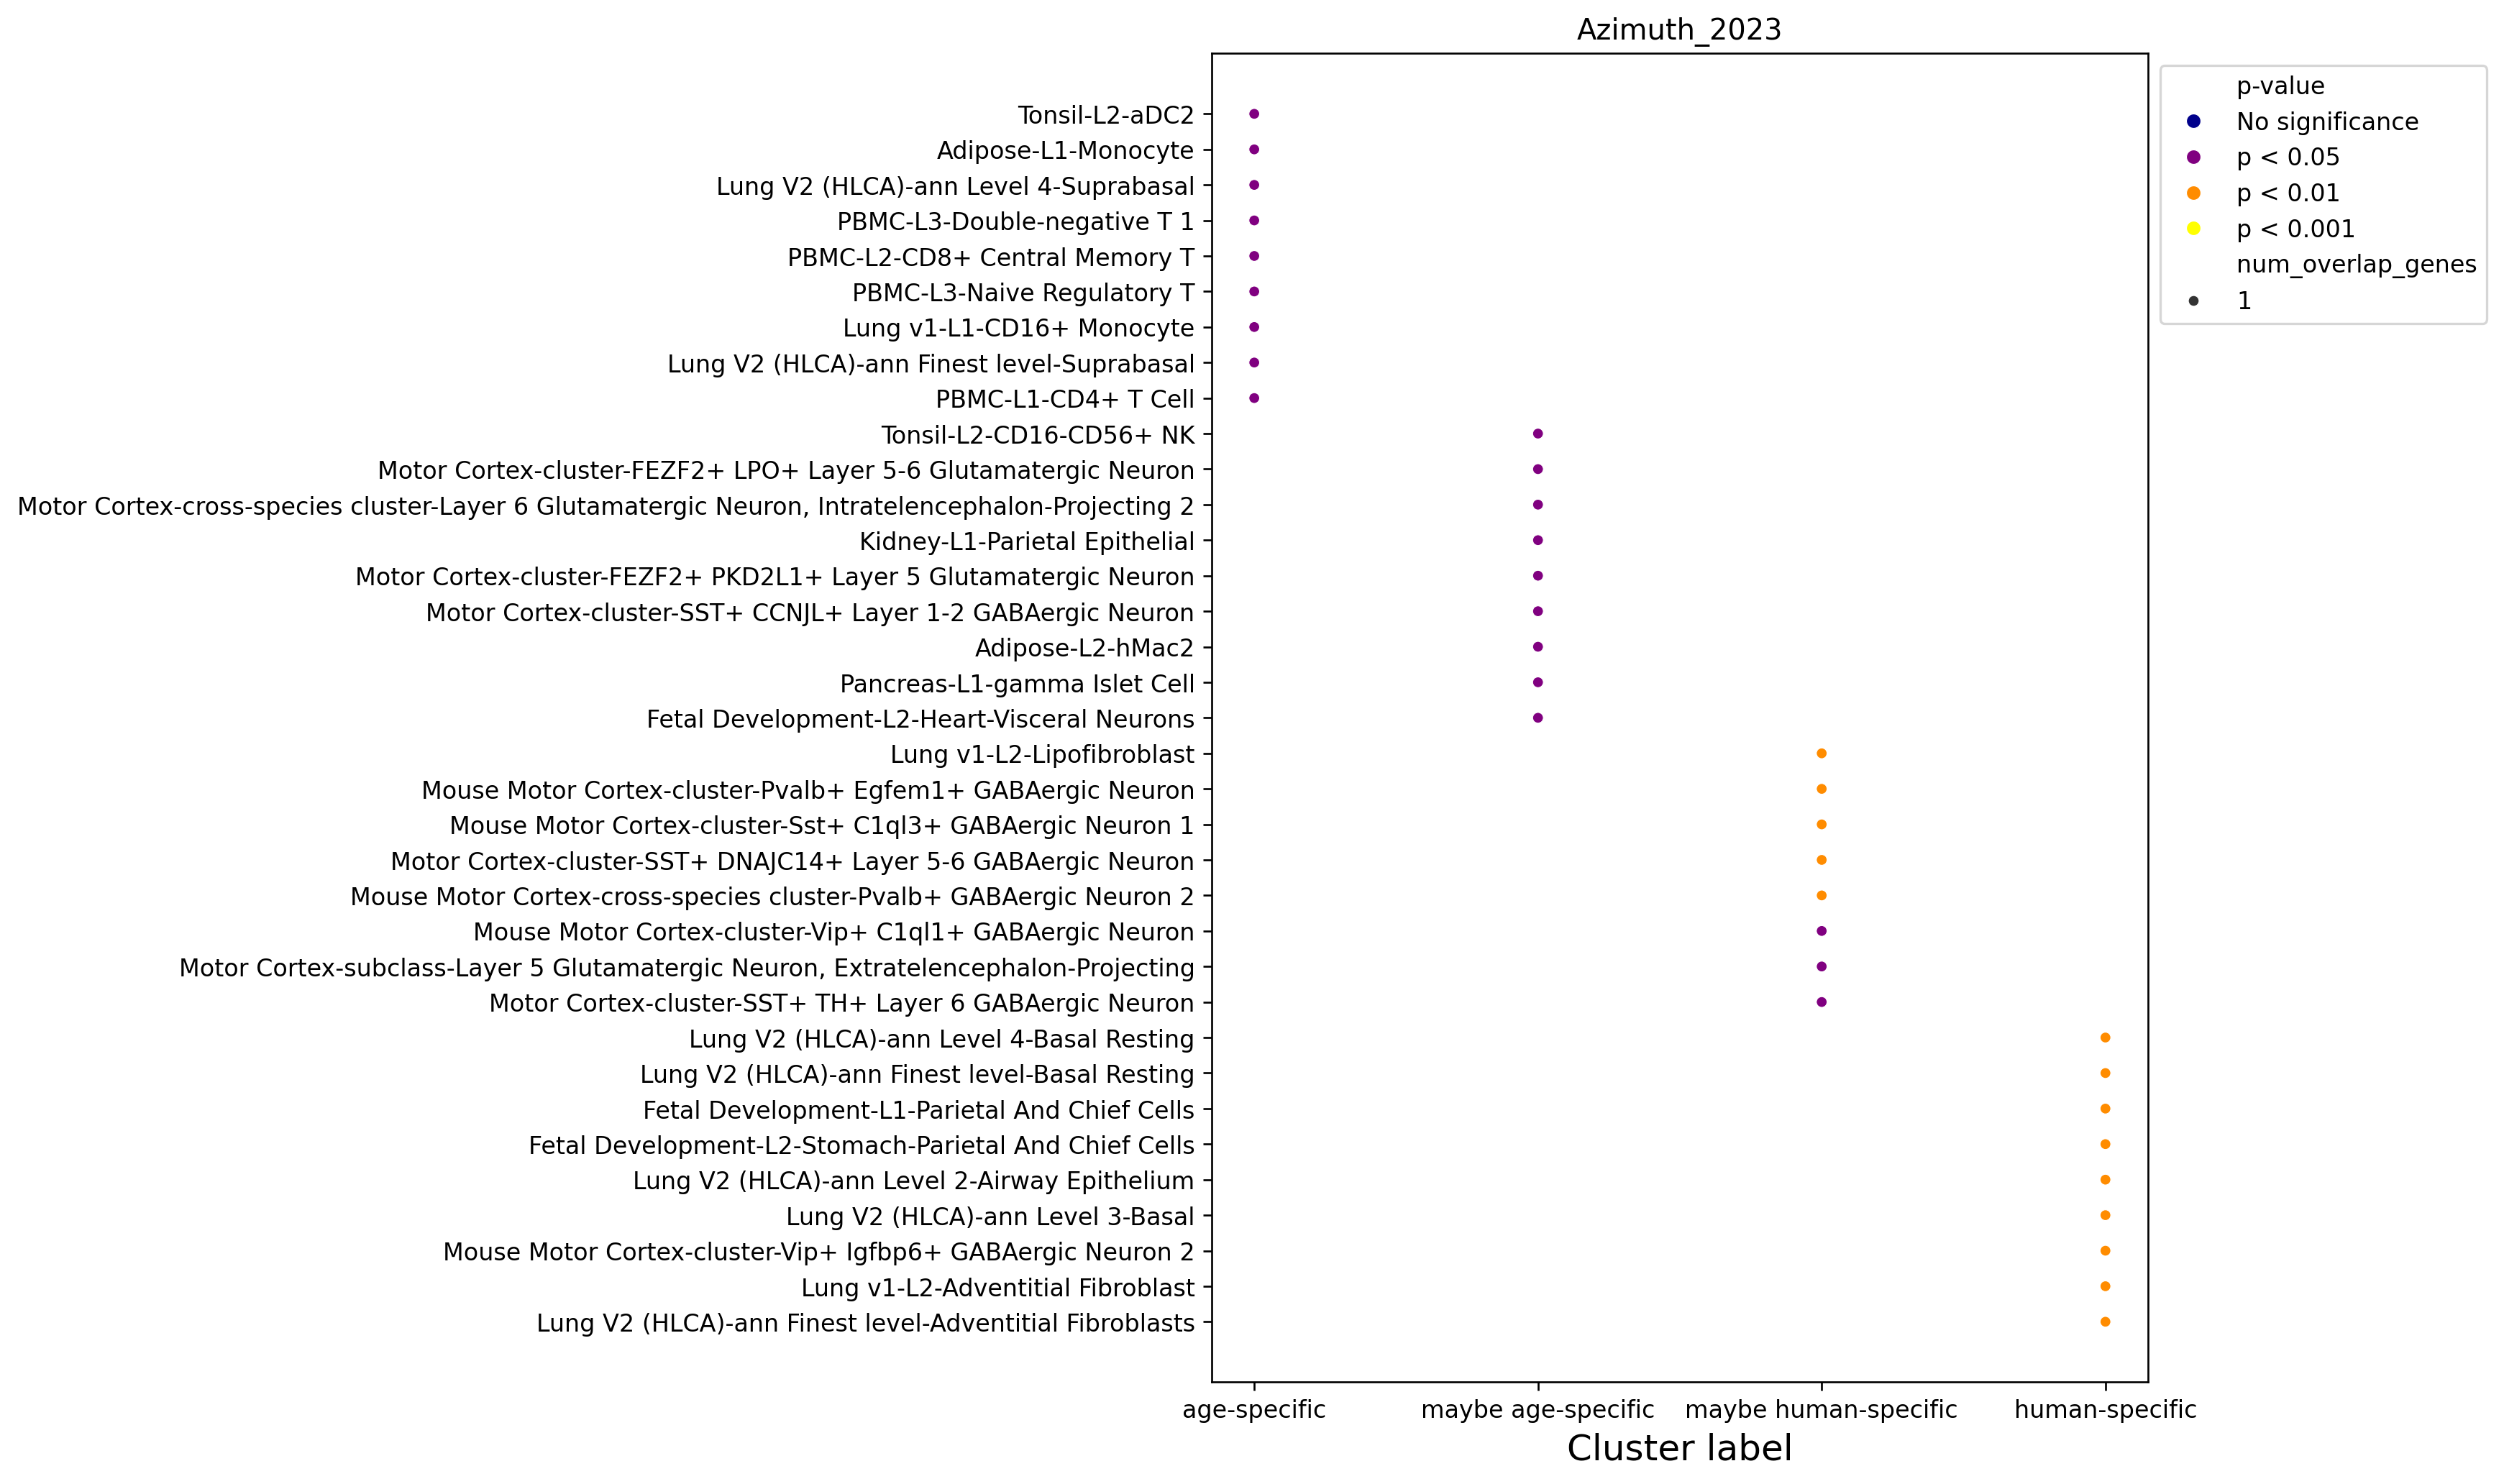

In [666]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Allen_Brain_Atlas_10x_scRNA_2021


In [667]:
db_name = 'Allen_Brain_Atlas_10x_scRNA_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [668]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  Combined score  \
Term                                                                         
Mouse 125 DG down                   1  0.000038   9.766892       99.421744   
Mouse 116 Pvalb up                  2  0.001104  49.219048      335.125573   
Mouse 121 DG down                   3  0.001379   7.239644       47.682259   
Mouse 115 Pvalb up                  4  0.001858  36.890476      231.969887   
Human Inh L5-6 PVALB FAM150B up     5  0.002032  35.129252      217.762437   

                                                                 Overlapping genes  \
Term                                                                                 
Mouse 125 DG down                [GAD1, CLSTN1, NRXN2, EIF1B, CX3CL1, GNAI1, FB...   
Mouse 116 Pvalb up                                                  [LDHB, PPP1CC]   
Mouse 121 DG down                              [GAD1, CLSTN1, EIF1B, GNAI1, FBXO9]   
Mouse 115 Pvalb up                                                  [LDHB, PPP1CC]   
Human Inh L5-6 PVALB FAM150B up                                    [LDHB, ST3GAL5]   

                                 Adjusted P-value  Old p-value  \
Term                                                             
Mouse 125 DG down                        0.005957            0   
Mouse 116 Pvalb up                       0.060360            0   
Mouse 121 DG down                        0.060360            0   
Mouse 115 Pvalb up                       0.060360            0   
Human Inh L5-6 PVALB FAM150B up          0.060360            0   

                                 Old adjusted p-value  num_overlap_genes  \
Term                                                                       
Mouse 125 DG down                                   0                  7   
Mouse 116 Pvalb up                                  0                  2   
Mouse 121 DG down                                   0                  5   
Mouse 115 Pvalb up                                  0                  2   
Human Inh L5-6 PVALB FAM150B up                     0                  2   

                                 neg_log10(p_adj) cluster_label  
Term                                                             
Mouse 125 DG down                        2.224986  age-specific  
Mouse 116 Pvalb up                       1.219247  age-specific  
Mouse 121 DG down                        1.219247  age-specific  
Mouse 115 Pvalb up                       1.219247  age-specific  
Human Inh L5-6 PVALB FAM150B up          1.219247  age-specific

In [669]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

1

In [670]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

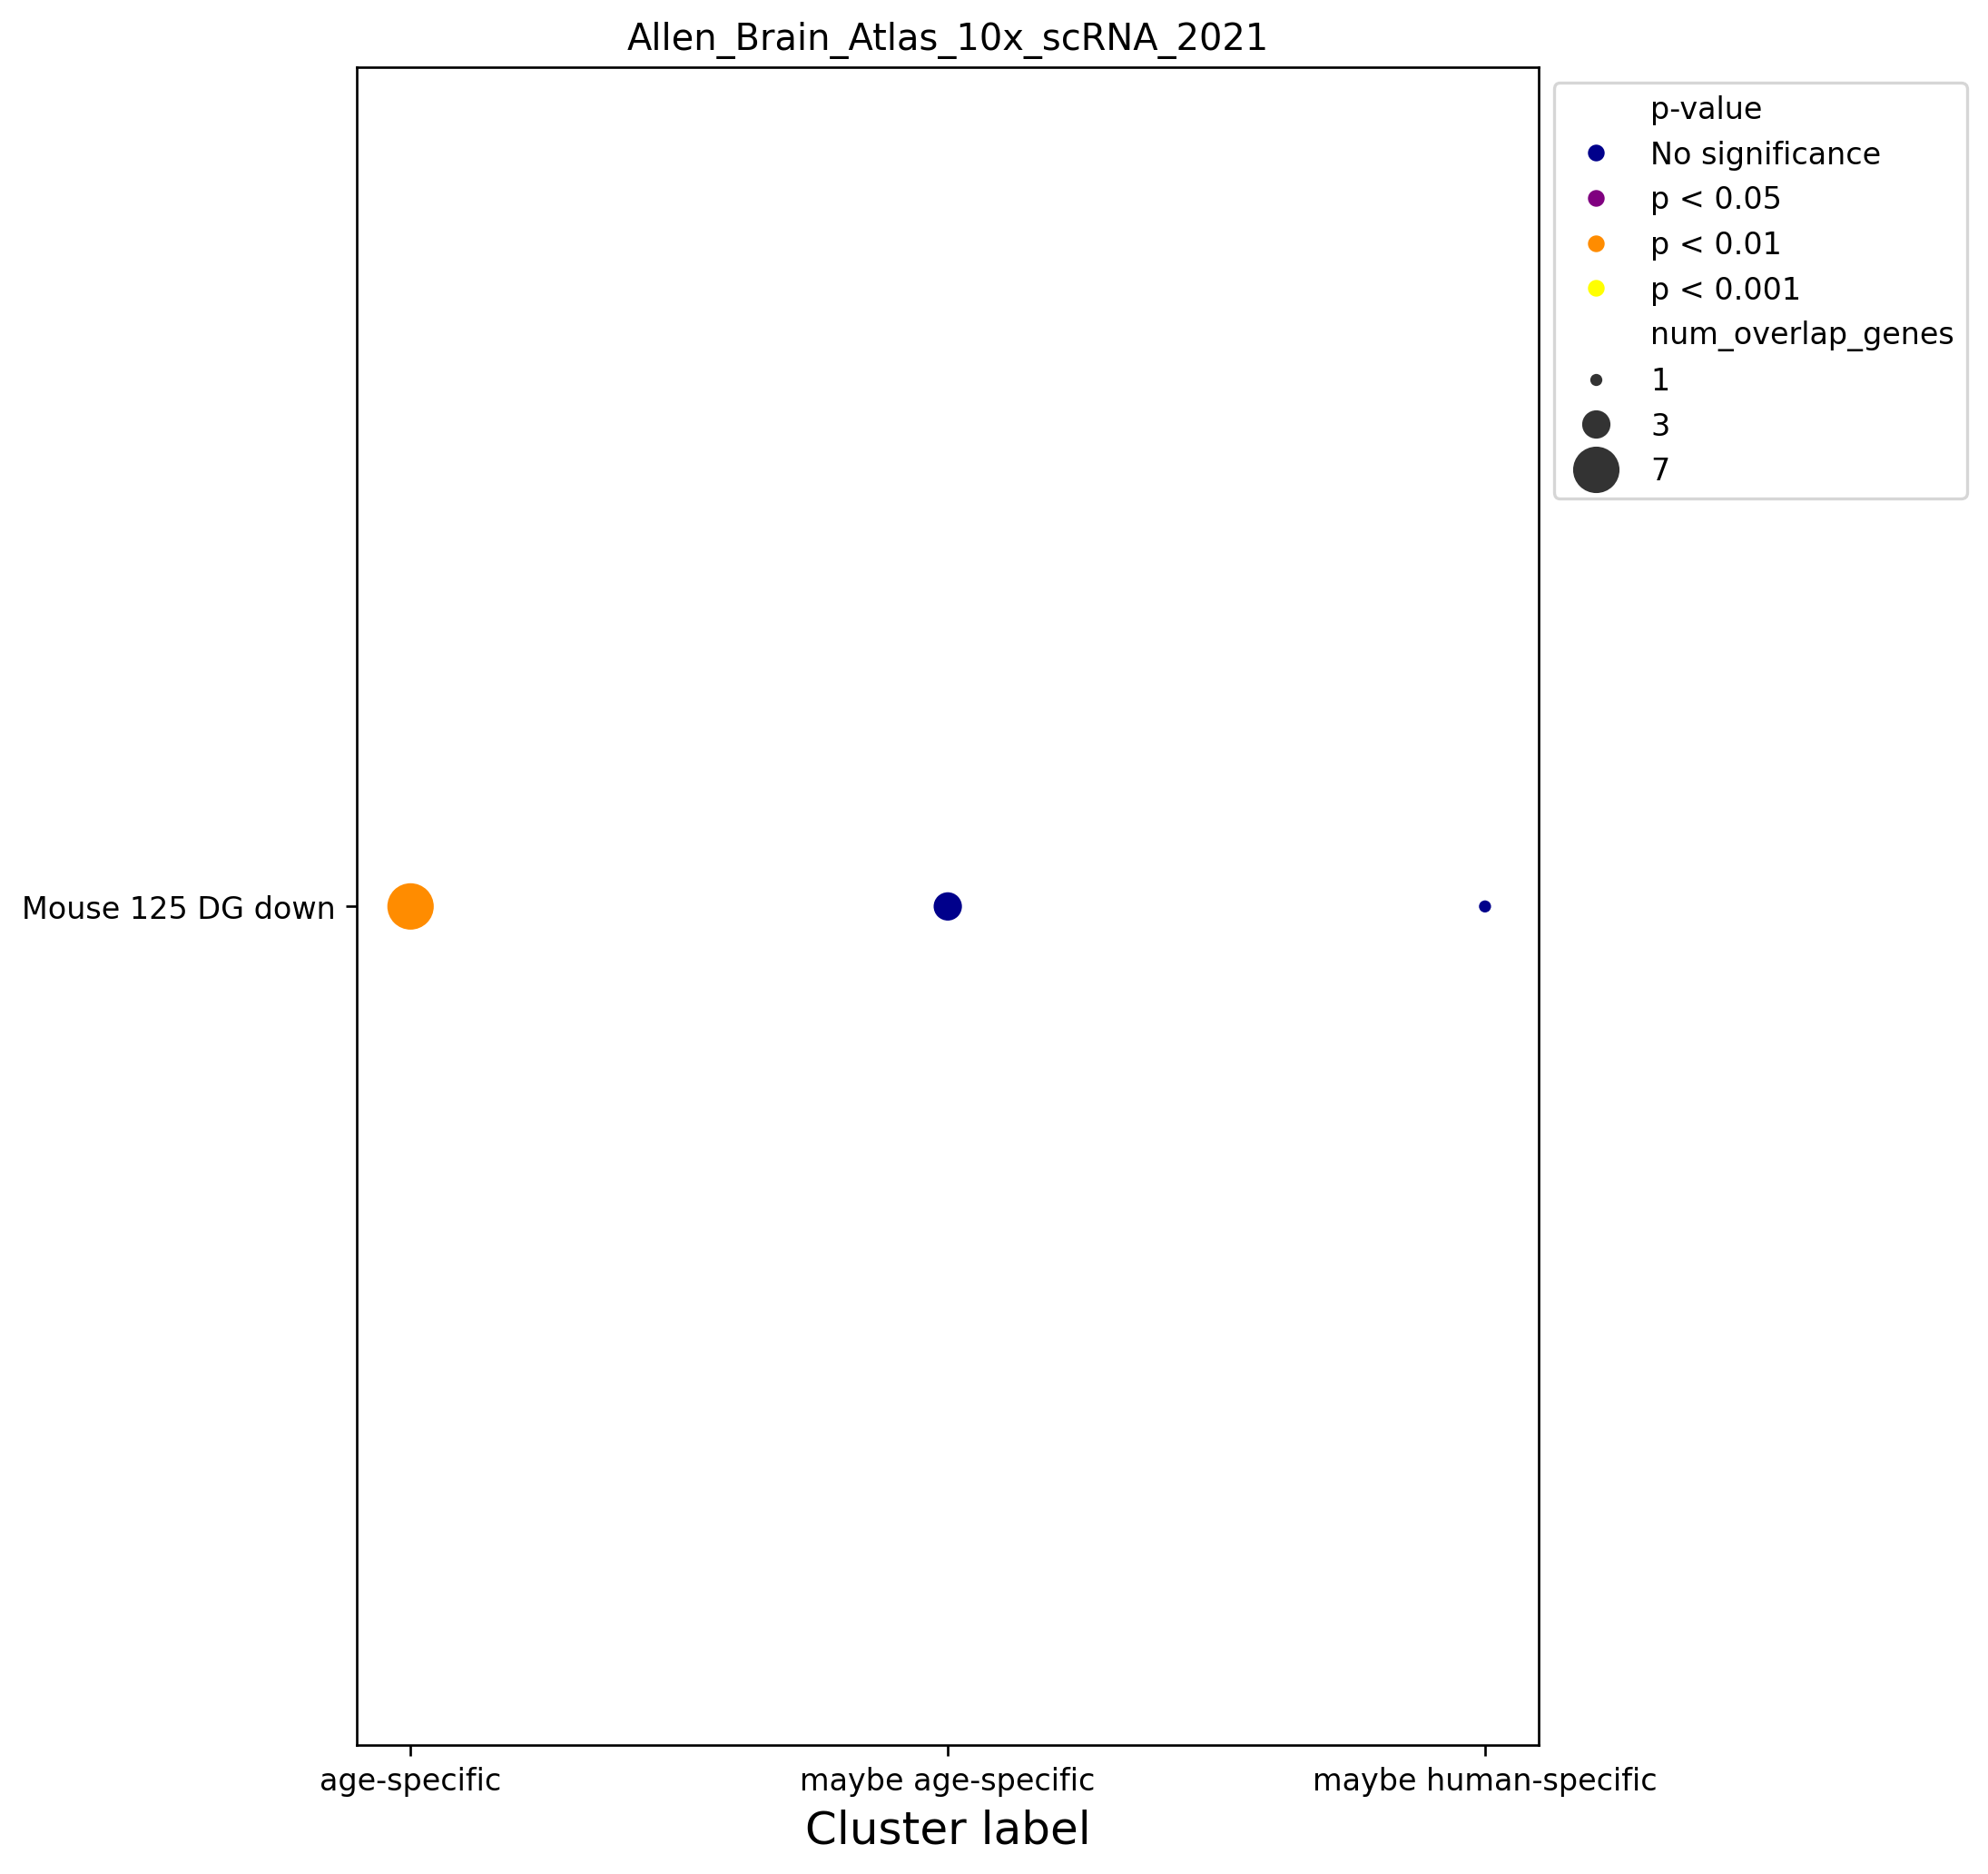

In [671]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [672]:
db_name = 'Azimuth_Cell_Types_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [673]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  Combined score  \
Term                                                                          
Double-negative T 1 CL0000935       1  0.005897  353.000000     1812.083364   
CD8+ Central Memory T CL0000909     2  0.005897  353.000000     1812.083364   
Naive Regulatory T CL0000815        3  0.005897  353.000000     1812.083364   
CD4+ Central Memory T CL0000897     4  0.008832  176.477273      834.618621   
Nonclassical Monocyte CL0000875     5  0.008832  176.477273      834.618621   

                                Overlapping genes  Adjusted P-value  \
Term                                                                  
Double-negative T 1 CL0000935              [LDHB]          0.017665   
CD8+ Central Memory T CL0000909            [LDHB]          0.017665   
Naive Regulatory T CL0000815               [LDHB]          0.017665   
CD4+ Central Memory T CL0000897            [LDHB]          0.017665   
Nonclassical Monocyte CL0000875           [COTL1]          0.017665   

                                 Old p-value  Old adjusted p-value  \
Term                                                                 
Double-negative T 1 CL0000935              0                     0   
CD8+ Central Memory T CL0000909            0                     0   
Naive Regulatory T CL0000815               0                     0   
CD4+ Central Memory T CL0000897            0                     0   
Nonclassical Monocyte CL0000875            0                     0   

                                 num_overlap_genes  neg_log10(p_adj)  \
Term                                                                   
Double-negative T 1 CL0000935                    1           1.75289   
CD8+ Central Memory T CL0000909                  1           1.75289   
Naive Regulatory T CL0000815                     1           1.75289   
CD4+ Central Memory T CL0000897                  1           1.75289   
Nonclassical Monocyte CL0000875                  1           1.75289   

                                cluster_label  
Term                                           
Double-negative T 1 CL0000935    age-specific  
CD8+ Central Memory T CL0000909  age-specific  
Naive Regulatory T CL0000815     age-specific  
CD4+ Central Memory T CL0000897  age-specific  
Nonclassical Monocyte CL0000875  age-specific

In [674]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

25

In [675]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

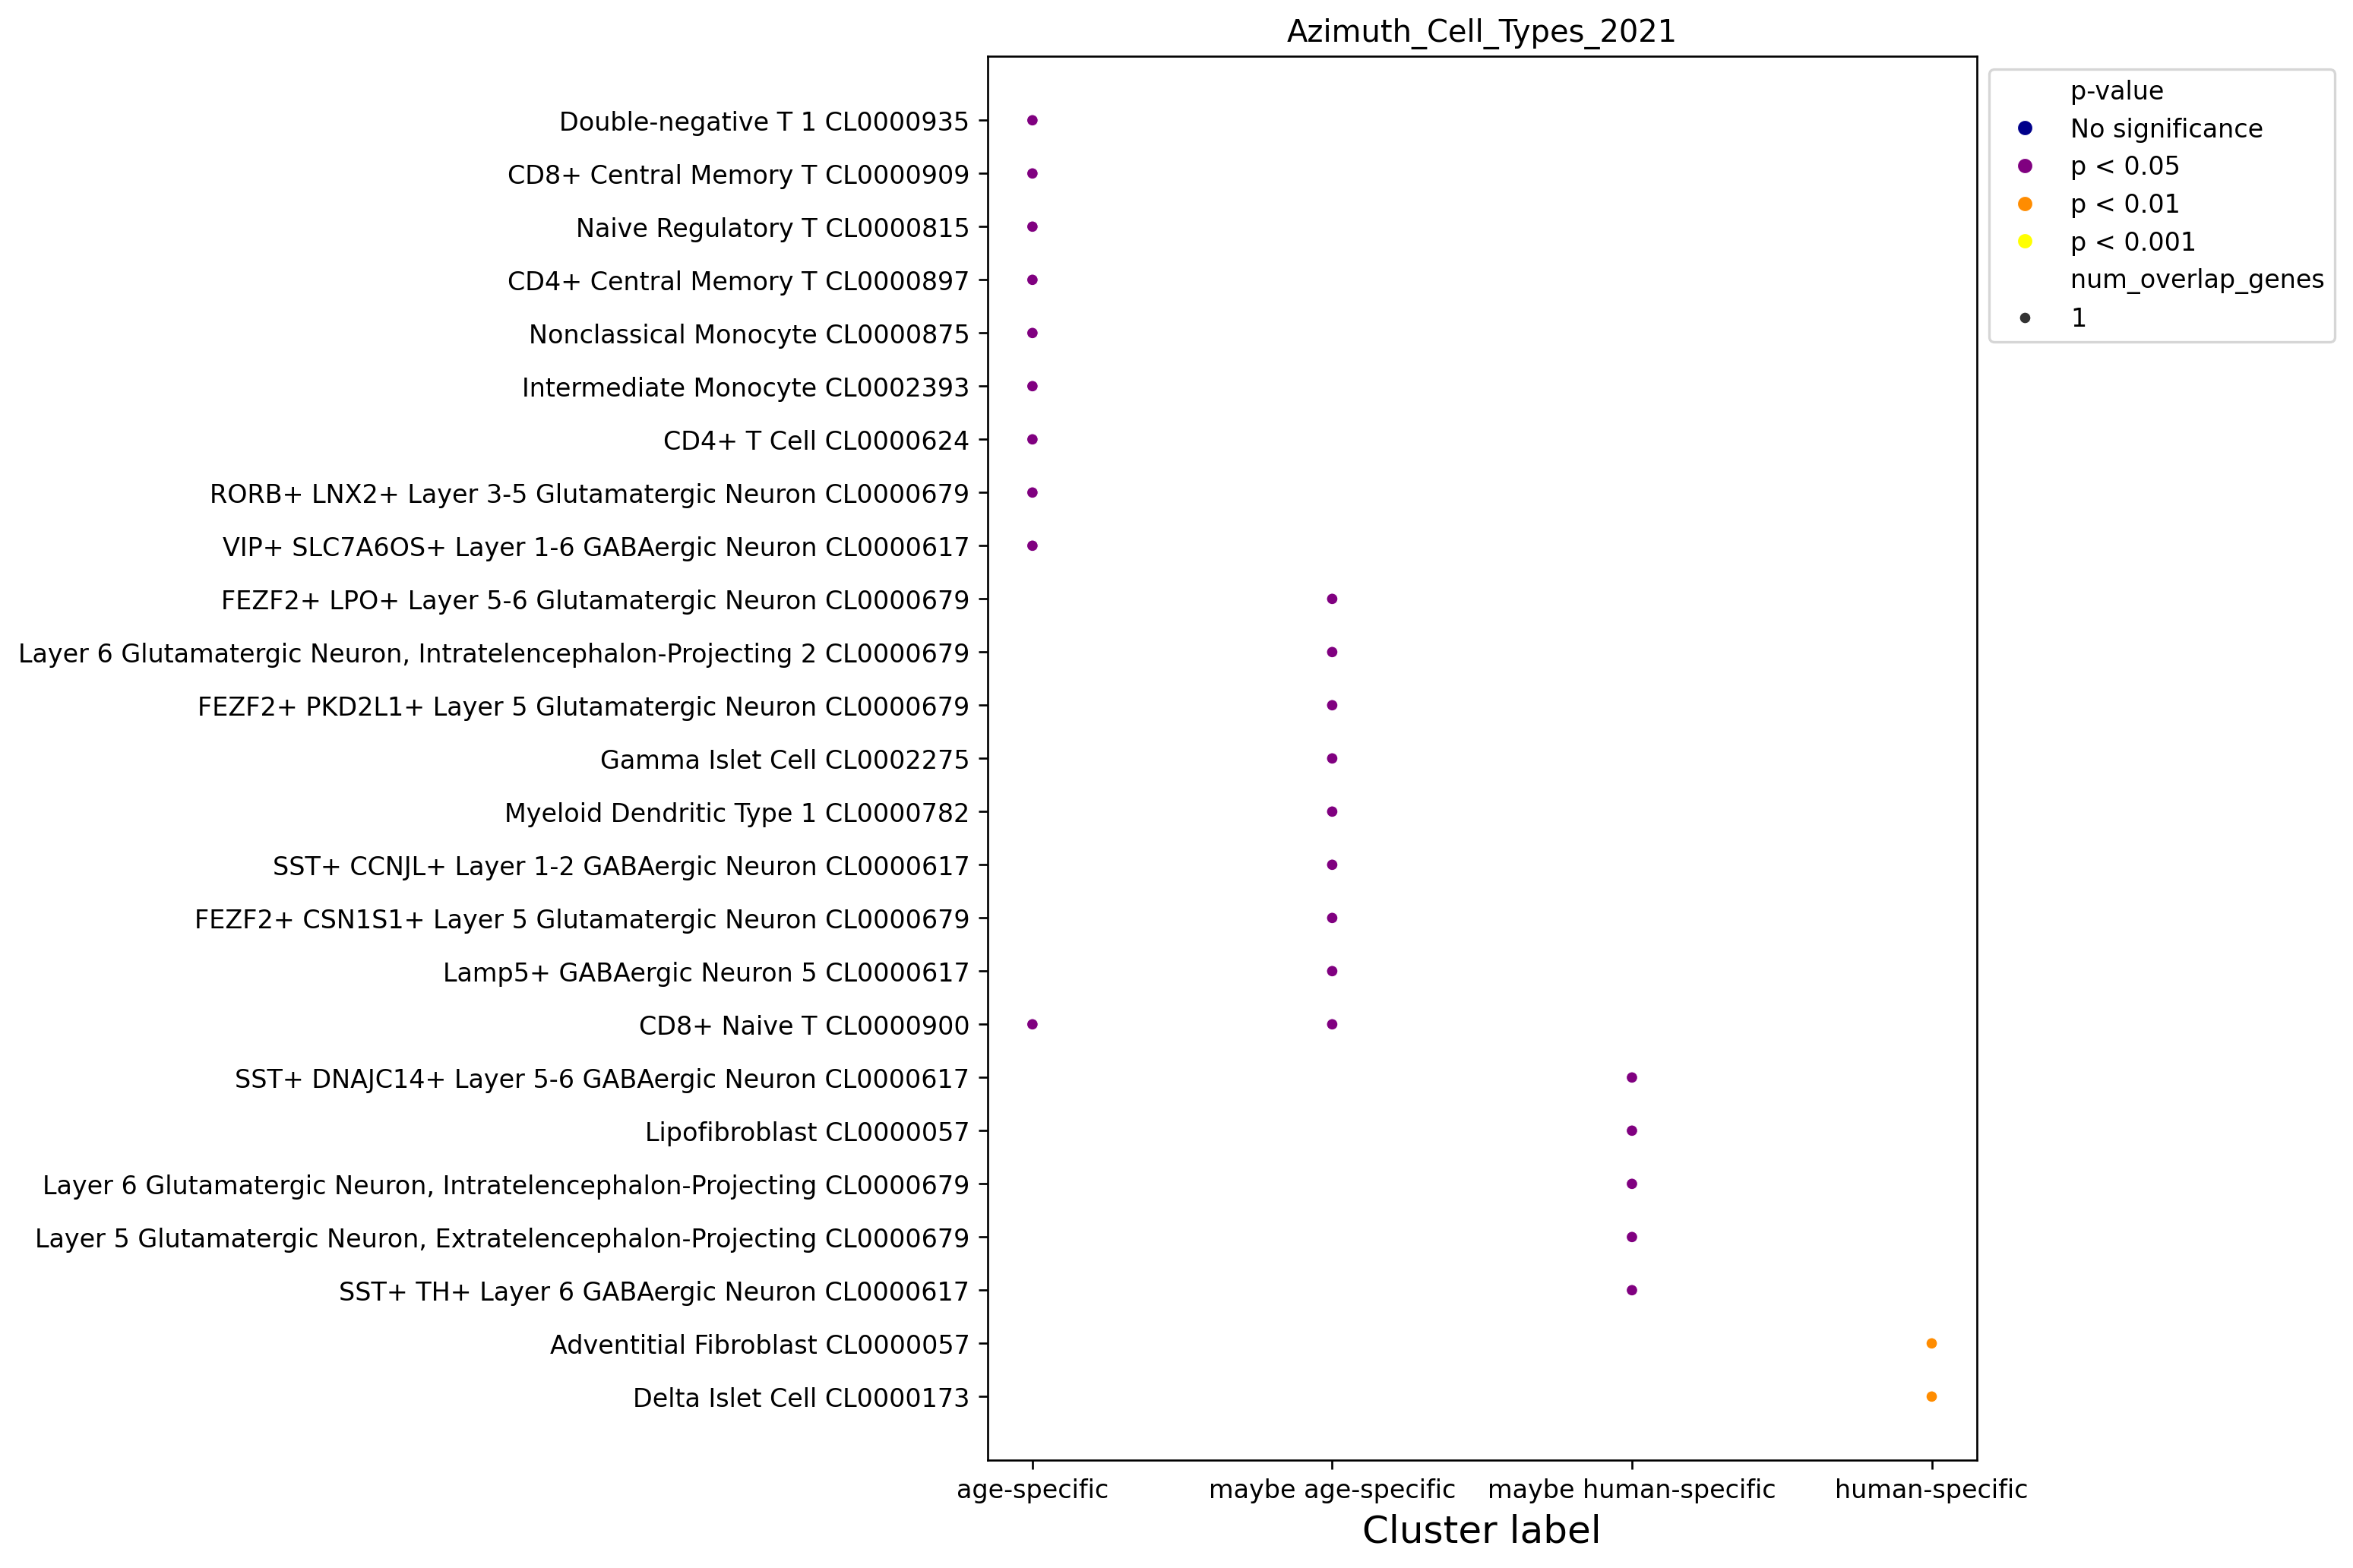

In [676]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## SynGO_2022

In [677]:
db_name = 'SynGO_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [678]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                            
Regulation Of Synaptic Vesicle Fusion To Presyn...    1  0.011760  117.636364   
Maintenance Of Postsynaptic Specialization Stru...    2  0.014679   88.215909   
Integral Component Of Presynaptic Membrane (GO:...    3  0.017351   10.945274   
Regulation Of Postsynaptic Specialization Assem...    4  0.017590   70.563636   
Regulation Of Calcium-Dependent Activation Of S...    5  0.020493   58.795455   

                                                    Combined score  \
Term                                                                 
Regulation Of Synaptic Vesicle Fusion To Presyn...      522.664863   
Maintenance Of Postsynaptic Specialization Stru...      372.387796   
Integral Component Of Presynaptic Membrane (GO:...       44.373145   
Regulation Of Postsynaptic Specialization Assem...      285.106111   
Regulation Of Calcium-Dependent Activation Of S...      228.577357   

                                                   Overlapping genes  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...            [ERC1]   
Maintenance Of Postsynaptic Specialization Stru...         [SYNGAP1]   
Integral Component Of Presynaptic Membrane (GO:...   [NRXN1, ATP1A3]   
Regulation Of Postsynaptic Specialization Assem...           [NRXN1]   
Regulation Of Calcium-Dependent Activation Of S...            [ERC1]   

                                                    Adjusted P-value  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...          0.060247   
Maintenance Of Postsynaptic Specialization Stru...          0.060247   
Integral Component Of Presynaptic Membrane (GO:...          0.060247   
Regulation Of Postsynaptic Specialization Assem...          0.060247   
Regulation Of Calcium-Dependent Activation Of S...          0.060247   

                                                   Old p-value  \
Term                                                             
Regulation Of Synaptic Vesicle Fusion To Presyn...           0   
Maintenance Of Postsynaptic Specialization Stru...           0   
Integral Component Of Presynaptic Membrane (GO:...           0   
Regulation Of Postsynaptic Specialization Assem...           0   
Regulation Of Calcium-Dependent Activation Of S...           0   

                                                   Old adjusted p-value  \
Term                                                                      
Regulation Of Synaptic Vesicle Fusion To Presyn...                    0   
Maintenance Of Postsynaptic Specialization Stru...                    0   
Integral Component Of Presynaptic Membrane (GO:...                    0   
Regulation Of Postsynaptic Specialization Assem...                    0   
Regulation Of Calcium-Dependent Activation Of S...                    0   

                                                   num_overlap_genes  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...                 1   
Maintenance Of Postsynaptic Specialization Stru...                 1   
Integral Component Of Presynaptic Membrane (GO:...                 2   
Regulation Of Postsynaptic Specialization Assem...                 1   
Regulation Of Calcium-Dependent Activation Of S...                 1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Regulation Of Synaptic Vesicle Fusion To Presyn...          1.220062   
Maintenance Of Postsynaptic Specialization Stru...          1.220062   
Integral Component Of Presynaptic Membrane (GO:...          1.220062   
Regulation Of Postsynaptic Specialization Assem...          1.220062   
Regulation Of Calcium-Dependent Activation Of S...      

In [679]:
enrich_res[enrich_res['Adjusted P-value'] < 0.05].head()

Rank     p-val    Z-score  \
Term                                                                    
Postsynaptic Specialization (GO:0099572) CC    1  0.022881  50.738562   

                                             Combined score Overlapping genes  \
Term                                                                            
Postsynaptic Specialization (GO:0099572) CC      191.663007          [DLGAP4]   

                                             Adjusted P-value Old p-value  \
Term                                                                        
Postsynaptic Specialization (GO:0099572) CC          0.045761           0   

                                            Old adjusted p-value  \
Term                                                               
Postsynaptic Specialization (GO:0099572) CC                    0   

                                            num_overlap_genes  \
Term                                                            
Postsynaptic Specialization (GO:0099572) CC                 1   

                                             neg_log10(p_adj)  \
Term                                                            
Postsynaptic Specialization (GO:0099572) CC          1.339501   

                                                  cluster_label  
Term                                                             
Postsynaptic Specialization (GO:0099572) CC  maybe age-specific

In [680]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

1

In [681]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

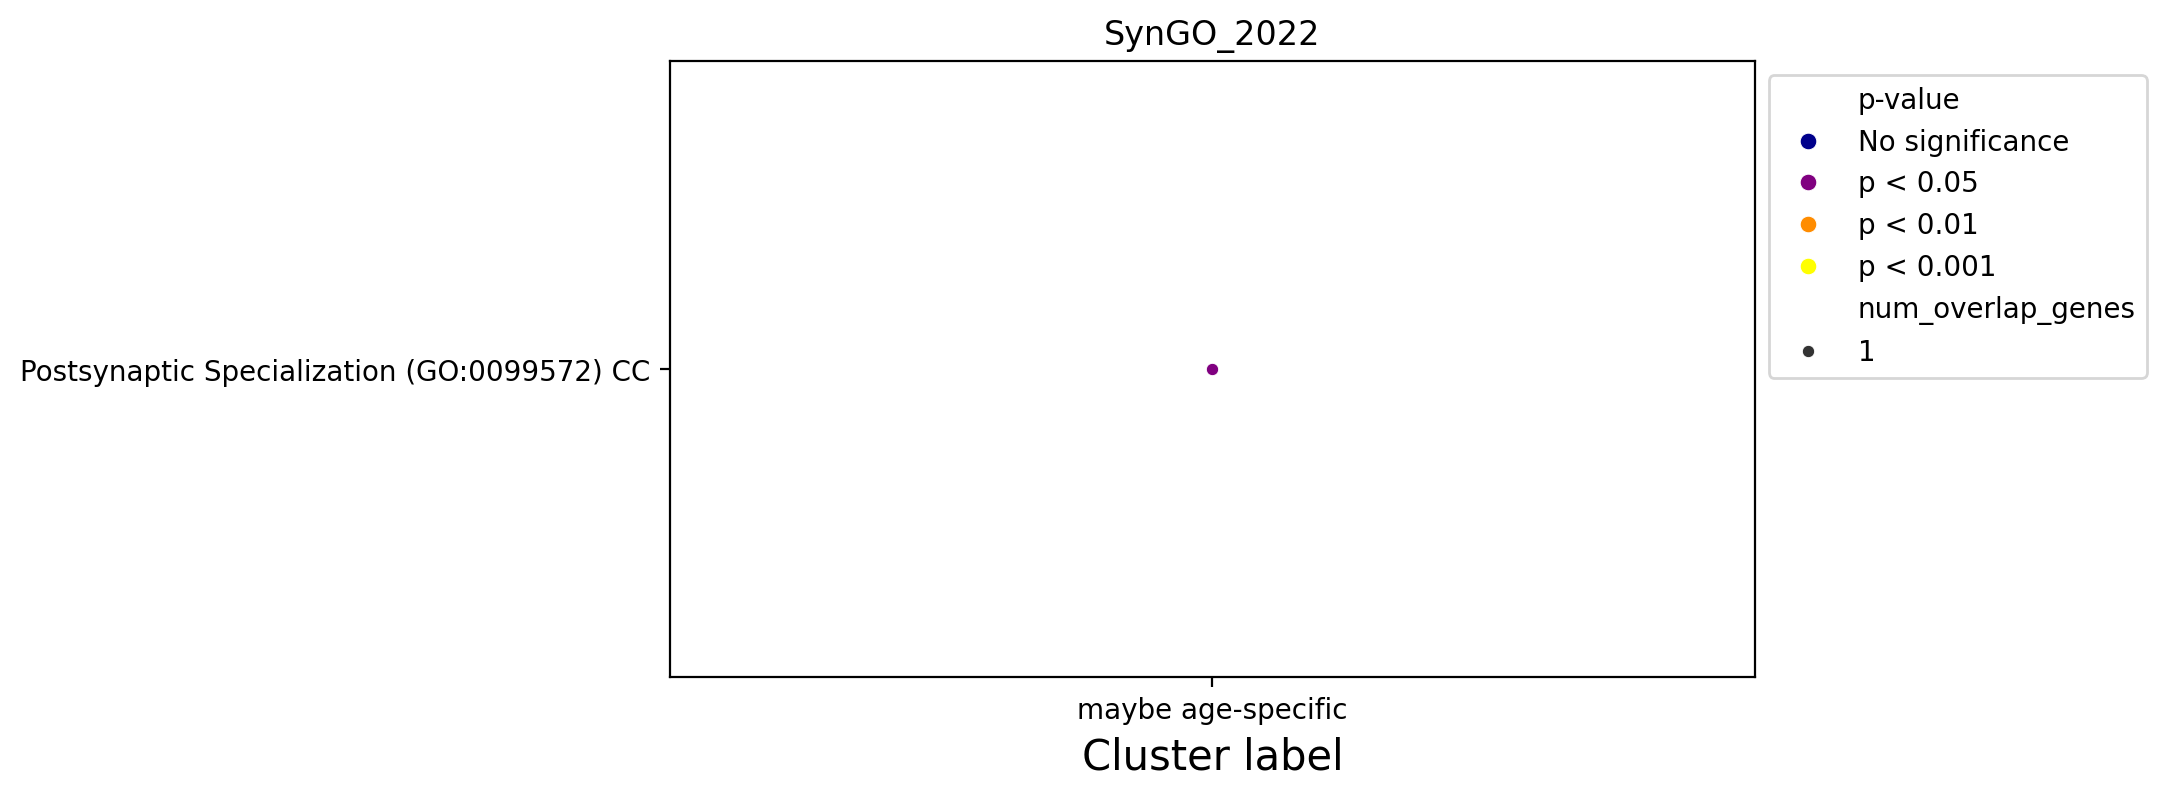

In [682]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 4), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [683]:
db_name = 'MGI_Mammalian_Phenotype_Level_4_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [684]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
decreased circulating HDL cholesterol level MP:...     1  0.001710  14.597468   
abnormal long term object recognition memory MP...     2  0.002400  32.066253   
abnormal motor learning MP:0002804                     3  0.004417  23.020833   
atelectasis MP:0001177                                 4  0.004417  23.020833   
neonatal lethality, complete penetrance MP:0011087     5  0.004831   6.747592   

                                                    Combined score  \
Term                                                                 
decreased circulating HDL cholesterol level MP:...       93.001683   
abnormal long term object recognition memory MP...      193.426408   
abnormal motor learning MP:0002804                      124.825422   
atelectasis MP:0001177                                  124.825422   
neonatal lethality, complete penetrance MP:0011087       35.982289   

                                                              Overlapping genes  \
Term                                                                              
decreased circulating HDL cholesterol level MP:...           [LDHB, NRXN1, LPL]   
abnormal long term object recognition memory MP...              [ATP1A3, GNAI1]   
abnormal motor learning MP:0002804                                [PCP4, NRXN1]   
atelectasis MP:0001177                                              [GAD1, LPL]   
neonatal lethality, complete penetrance MP:0011087  [ZBTB18, GAD1, ATP1A3, LPL]   

                                                    Adjusted P-value  \
Term                                                                   
decreased circulating HDL cholesterol level MP:...          0.117357   
abnormal long term object recognition memory MP...          0.117357   
abnormal motor learning MP:0002804                          0.117357   
atelectasis MP:0001177                                      0.117357   
neonatal lethality, complete penetrance MP:0011087          0.117357   

                                                    Old p-value  \
Term                                                              
decreased circulating HDL cholesterol level MP:...            0   
abnormal long term object recognition memory MP...            0   
abnormal motor learning MP:0002804                            0   
atelectasis MP:0001177                                        0   
neonatal lethality, complete penetrance MP:0011087            0   

                                                    Old adjusted p-value  \
Term                                                                       
decreased circulating HDL cholesterol level MP:...                     0   
abnormal long term object recognition memory MP...                     0   
abnormal motor learning MP:0002804                                     0   
atelectasis MP:0001177                                                 0   
neonatal lethality, complete penetrance MP:0011087                     0   

                                                    num_overlap_genes  \
Term                                                                    
decreased circulating HDL cholesterol level MP:...                  3   
abnormal long term object recognition memory MP...                  2   
abnormal motor learning MP:0002804                                  2   
atelectasis MP:0001177                                              2   
neonatal lethality, complete penetrance MP:0011087                  4   

                                                    neg_log10(p_adj)  \
Term                                                                   
decreased circulating HDL cholesterol level MP:...           0.93049   
abnormal long term object recognition memory MP...           0.93049   
abnormal motor learning MP:0002804                           0.93049   
atelectasis MP:0001177         

In [685]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

0

In [686]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_28700\916715644.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


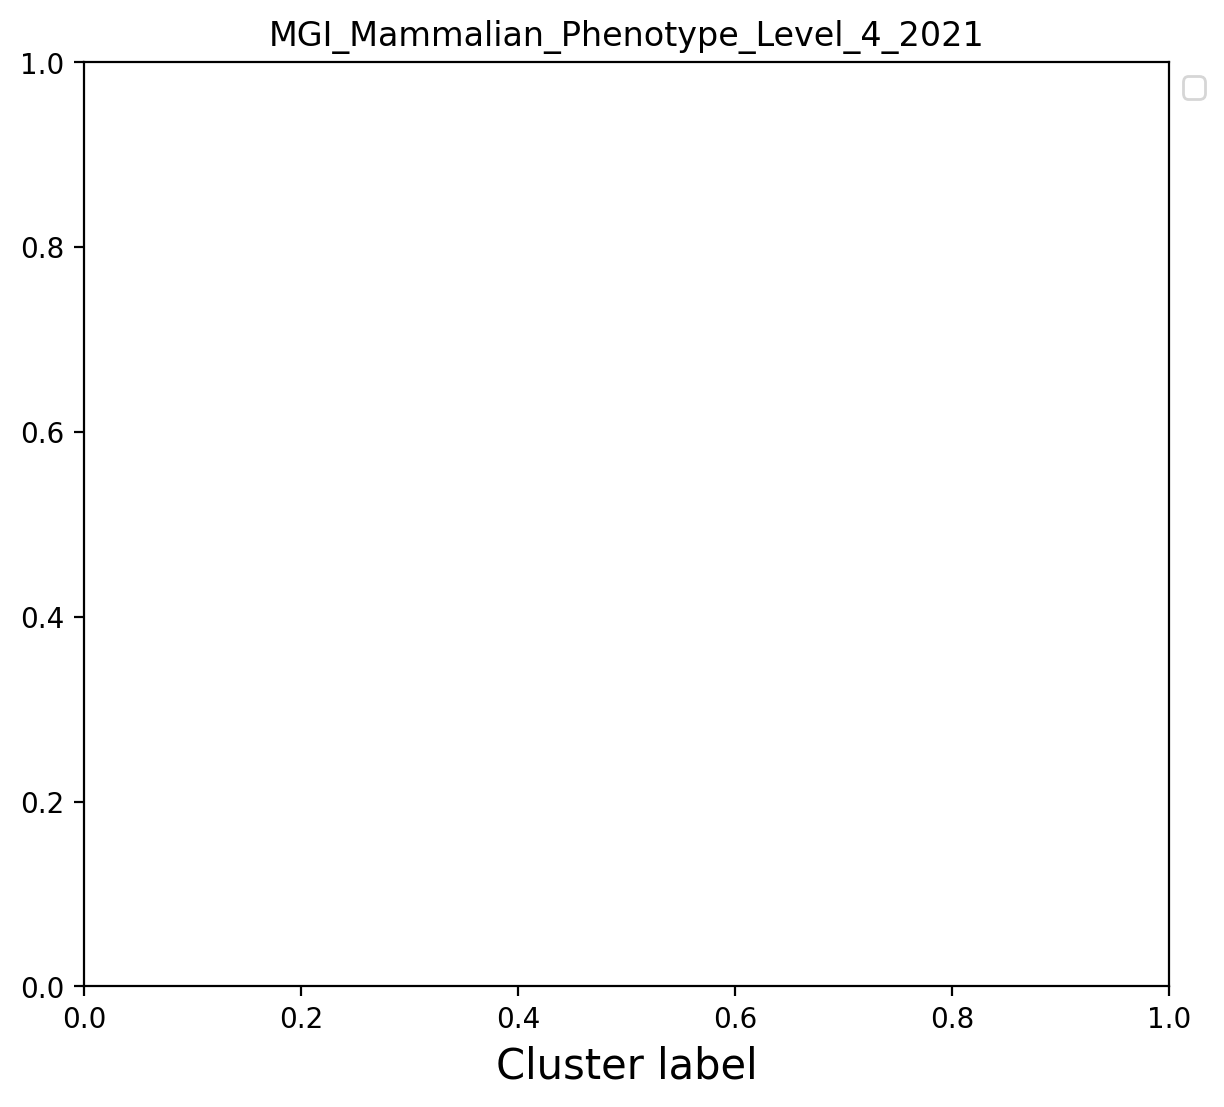

In [687]:
fig = plt.figure(figsize=(7, 6), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [688]:
db_name = 'Reactome_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [689]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                           
Neuronal System R-HSA-112316                         1  0.004619    6.837568   
Chylomicron Remodeling R-HSA-8963901                 2  0.005897  353.000000   
Neurexins And Neuroligins R-HSA-6794361              3  0.007316   17.517007   
Regulation Of RAS By GAPs R-HSA-5658442              4  0.010871   14.130037   
Chemokine Receptors Bind Chemokines R-HSA-380108     5  0.011760  117.636364   

                                                  Combined score  \
Term                                                               
Neuronal System R-HSA-112316                           36.769524   
Chylomicron Remodeling R-HSA-8963901                 1812.083364   
Neurexins And Neuroligins R-HSA-6794361                86.142730   
Regulation Of RAS By GAPs R-HSA-5658442                63.891168   
Chemokine Receptors Bind Chemokines R-HSA-380108      522.664863   

                                                            Overlapping genes  \
Term                                                                            
Neuronal System R-HSA-112316                      [GAD1, NRXN1, NRXN2, GNAI1]   
Chylomicron Remodeling R-HSA-8963901                                    [LPL]   
Neurexins And Neuroligins R-HSA-6794361                        [NRXN1, NRXN2]   
Regulation Of RAS By GAPs R-HSA-5658442                      [PSMB7, SYNGAP1]   
Chemokine Receptors Bind Chemokines R-HSA-380108                     [CX3CL1]   

                                                  Adjusted P-value  \
Term                                                                 
Neuronal System R-HSA-112316                               0.25057   
Chylomicron Remodeling R-HSA-8963901                       0.25057   
Neurexins And Neuroligins R-HSA-6794361                    0.25057   
Regulation Of RAS By GAPs R-HSA-5658442                    0.25057   
Chemokine Receptors Bind Chemokines R-HSA-380108           0.25057   

                                                  Old p-value  \
Term                                                            
Neuronal System R-HSA-112316                                0   
Chylomicron Remodeling R-HSA-8963901                        0   
Neurexins And Neuroligins R-HSA-6794361                     0   
Regulation Of RAS By GAPs R-HSA-5658442                     0   
Chemokine Receptors Bind Chemokines R-HSA-380108            0   

                                                  Old adjusted p-value  \
Term                                                                     
Neuronal System R-HSA-112316                                         0   
Chylomicron Remodeling R-HSA-8963901                                 0   
Neurexins And Neuroligins R-HSA-6794361                              0   
Regulation Of RAS By GAPs R-HSA-5658442                              0   
Chemokine Receptors Bind Chemokines R-HSA-380108                     0   

                                                  num_overlap_genes  \
Term                                                                  
Neuronal System R-HSA-112316                                      4   
Chylomicron Remodeling R-HSA-8963901                              1   
Neurexins And Neuroligins R-HSA-6794361                           2   
Regulation Of RAS By GAPs R-HSA-5658442                           2   
Chemokine Receptors Bind Chemokines R-HSA-380108                  1   

                                                  neg_log10(p_adj)  \
Term                                                                 
Neuronal System R-HSA-112316                              0.601072   
Chylomicron Remodeling R-HSA-8963901                      0.601072   
Neurexins And Neuroligins R-HSA-6794361                   0.601072   
Regulation Of RAS By GAPs R-HSA-5658442                   0.601072   
Chemokine Receptors Bind Chemokines R-HSA-380108          0.

In [690]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

0

In [691]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\claptar\AppData\Local\Temp\ipykernel_28700\2723481187.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


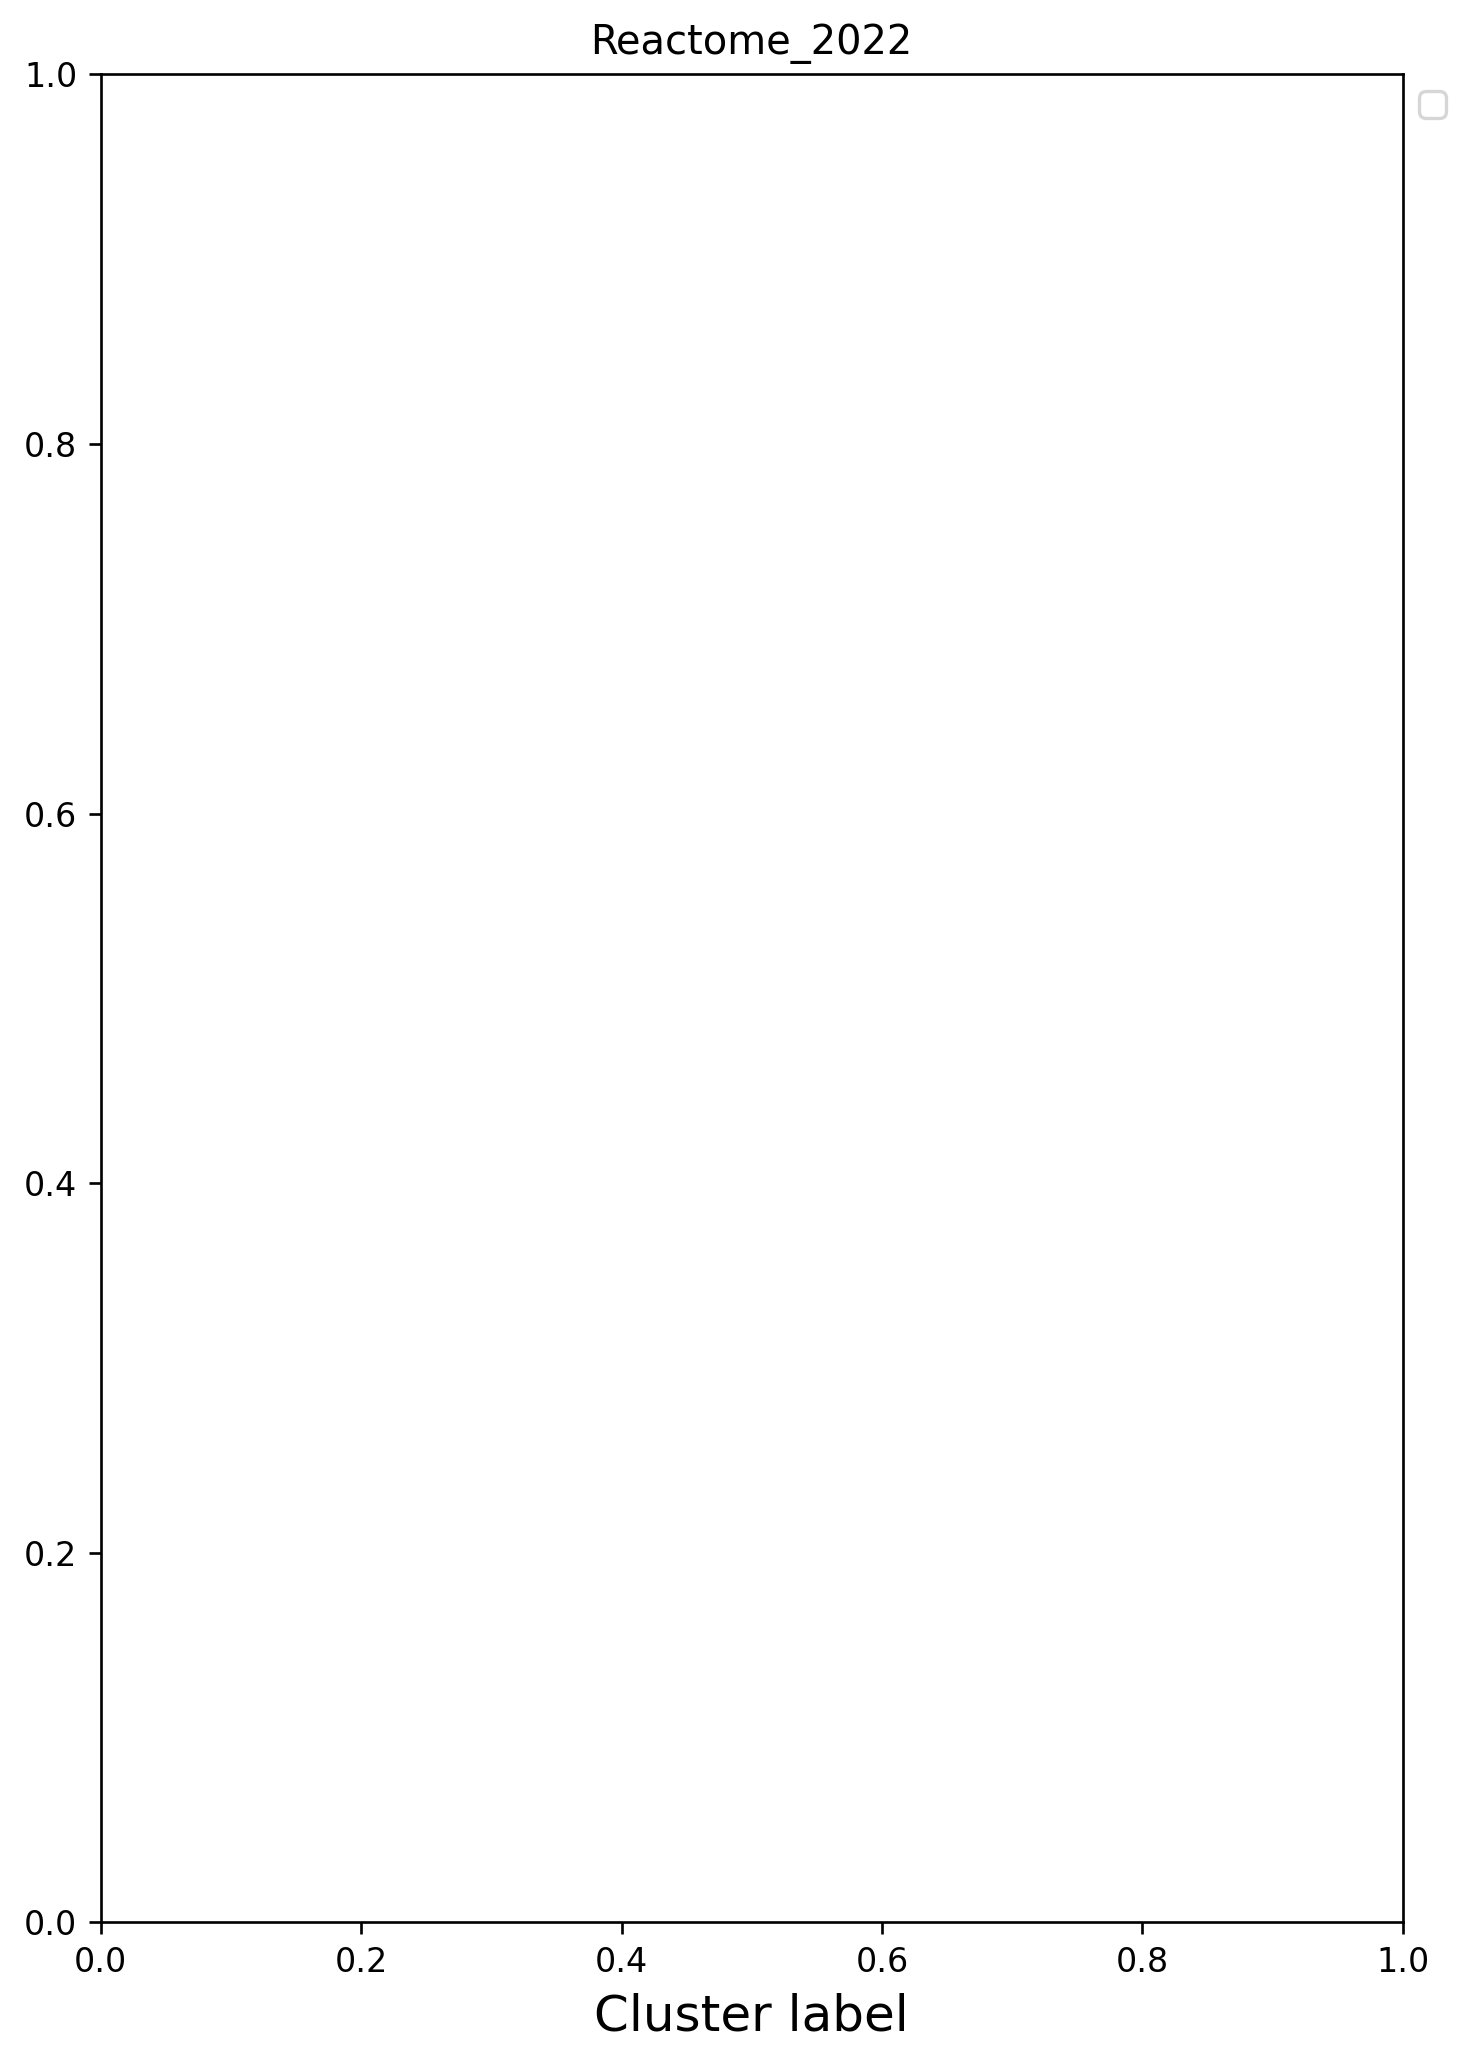

In [692]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [693]:
db_name = 'KEGG_2021_Human'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [694]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                
cGMP-PKG signaling pathway                 1  0.001961  13.886747   
Adrenergic signaling in cardiomyocytes     2  0.002164  13.397093   
cAMP signaling pathway                     3  0.003653  11.052404   
Gastric acid secretion                     4  0.005782  19.897040   
Cell adhesion molecules                    5  0.010487  14.408964   

                                        Combined score  \
Term                                                     
cGMP-PKG signaling pathway                   86.572145   
Adrenergic signaling in cardiomyocytes       82.202675   
cAMP signaling pathway                       62.027361   
Gastric acid secretion                      102.528566   
Cell adhesion molecules                      65.670431   

                                              Overlapping genes  \
Term                                                              
cGMP-PKG signaling pathway              [PPP1CC, ATP1A3, GNAI1]   
Adrenergic signaling in cardiomyocytes  [PPP1CC, ATP1A3, GNAI1]   
cAMP signaling pathway                  [PPP1CC, ATP1A3, GNAI1]   
Gastric acid secretion                          [ATP1A3, GNAI1]   
Cell adhesion molecules                          [NRXN1, NRXN2]   

                                        Adjusted P-value  Old p-value  \
Term                                                                    
cGMP-PKG signaling pathway                      0.113603            0   
Adrenergic signaling in cardiomyocytes          0.113603            0   
cAMP signaling pathway                          0.127867            0   
Gastric acid secretion                          0.151785            0   
Cell adhesion molecules                         0.167907            0   

                                        Old adjusted p-value  \
Term                                                           
cGMP-PKG signaling pathway                                 0   
Adrenergic signaling in cardiomyocytes                     0   
cAMP signaling pathway                                     0   
Gastric acid secretion                                     0   
Cell adhesion molecules                                    0   

                                        num_overlap_genes  neg_log10(p_adj)  \
Term                                                                          
cGMP-PKG signaling pathway                              3          0.944610   
Adrenergic signaling in cardiomyocytes                  3          0.944610   
cAMP signaling pathway                                  3          0.893243   
Gastric acid secretion                                  2          0.818771   
Cell adhesion molecules                                 2          0.774932   

                                       cluster_label  
Term                                                  
cGMP-PKG signaling pathway              age-specific  
Adrenergic signaling in cardiomyocytes  age-specific  
cAMP signaling pathway                  age-specific  
Gastric acid secretion                  age-specific  
Cell adhesion molecules                 age-specific

In [695]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

1

In [696]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

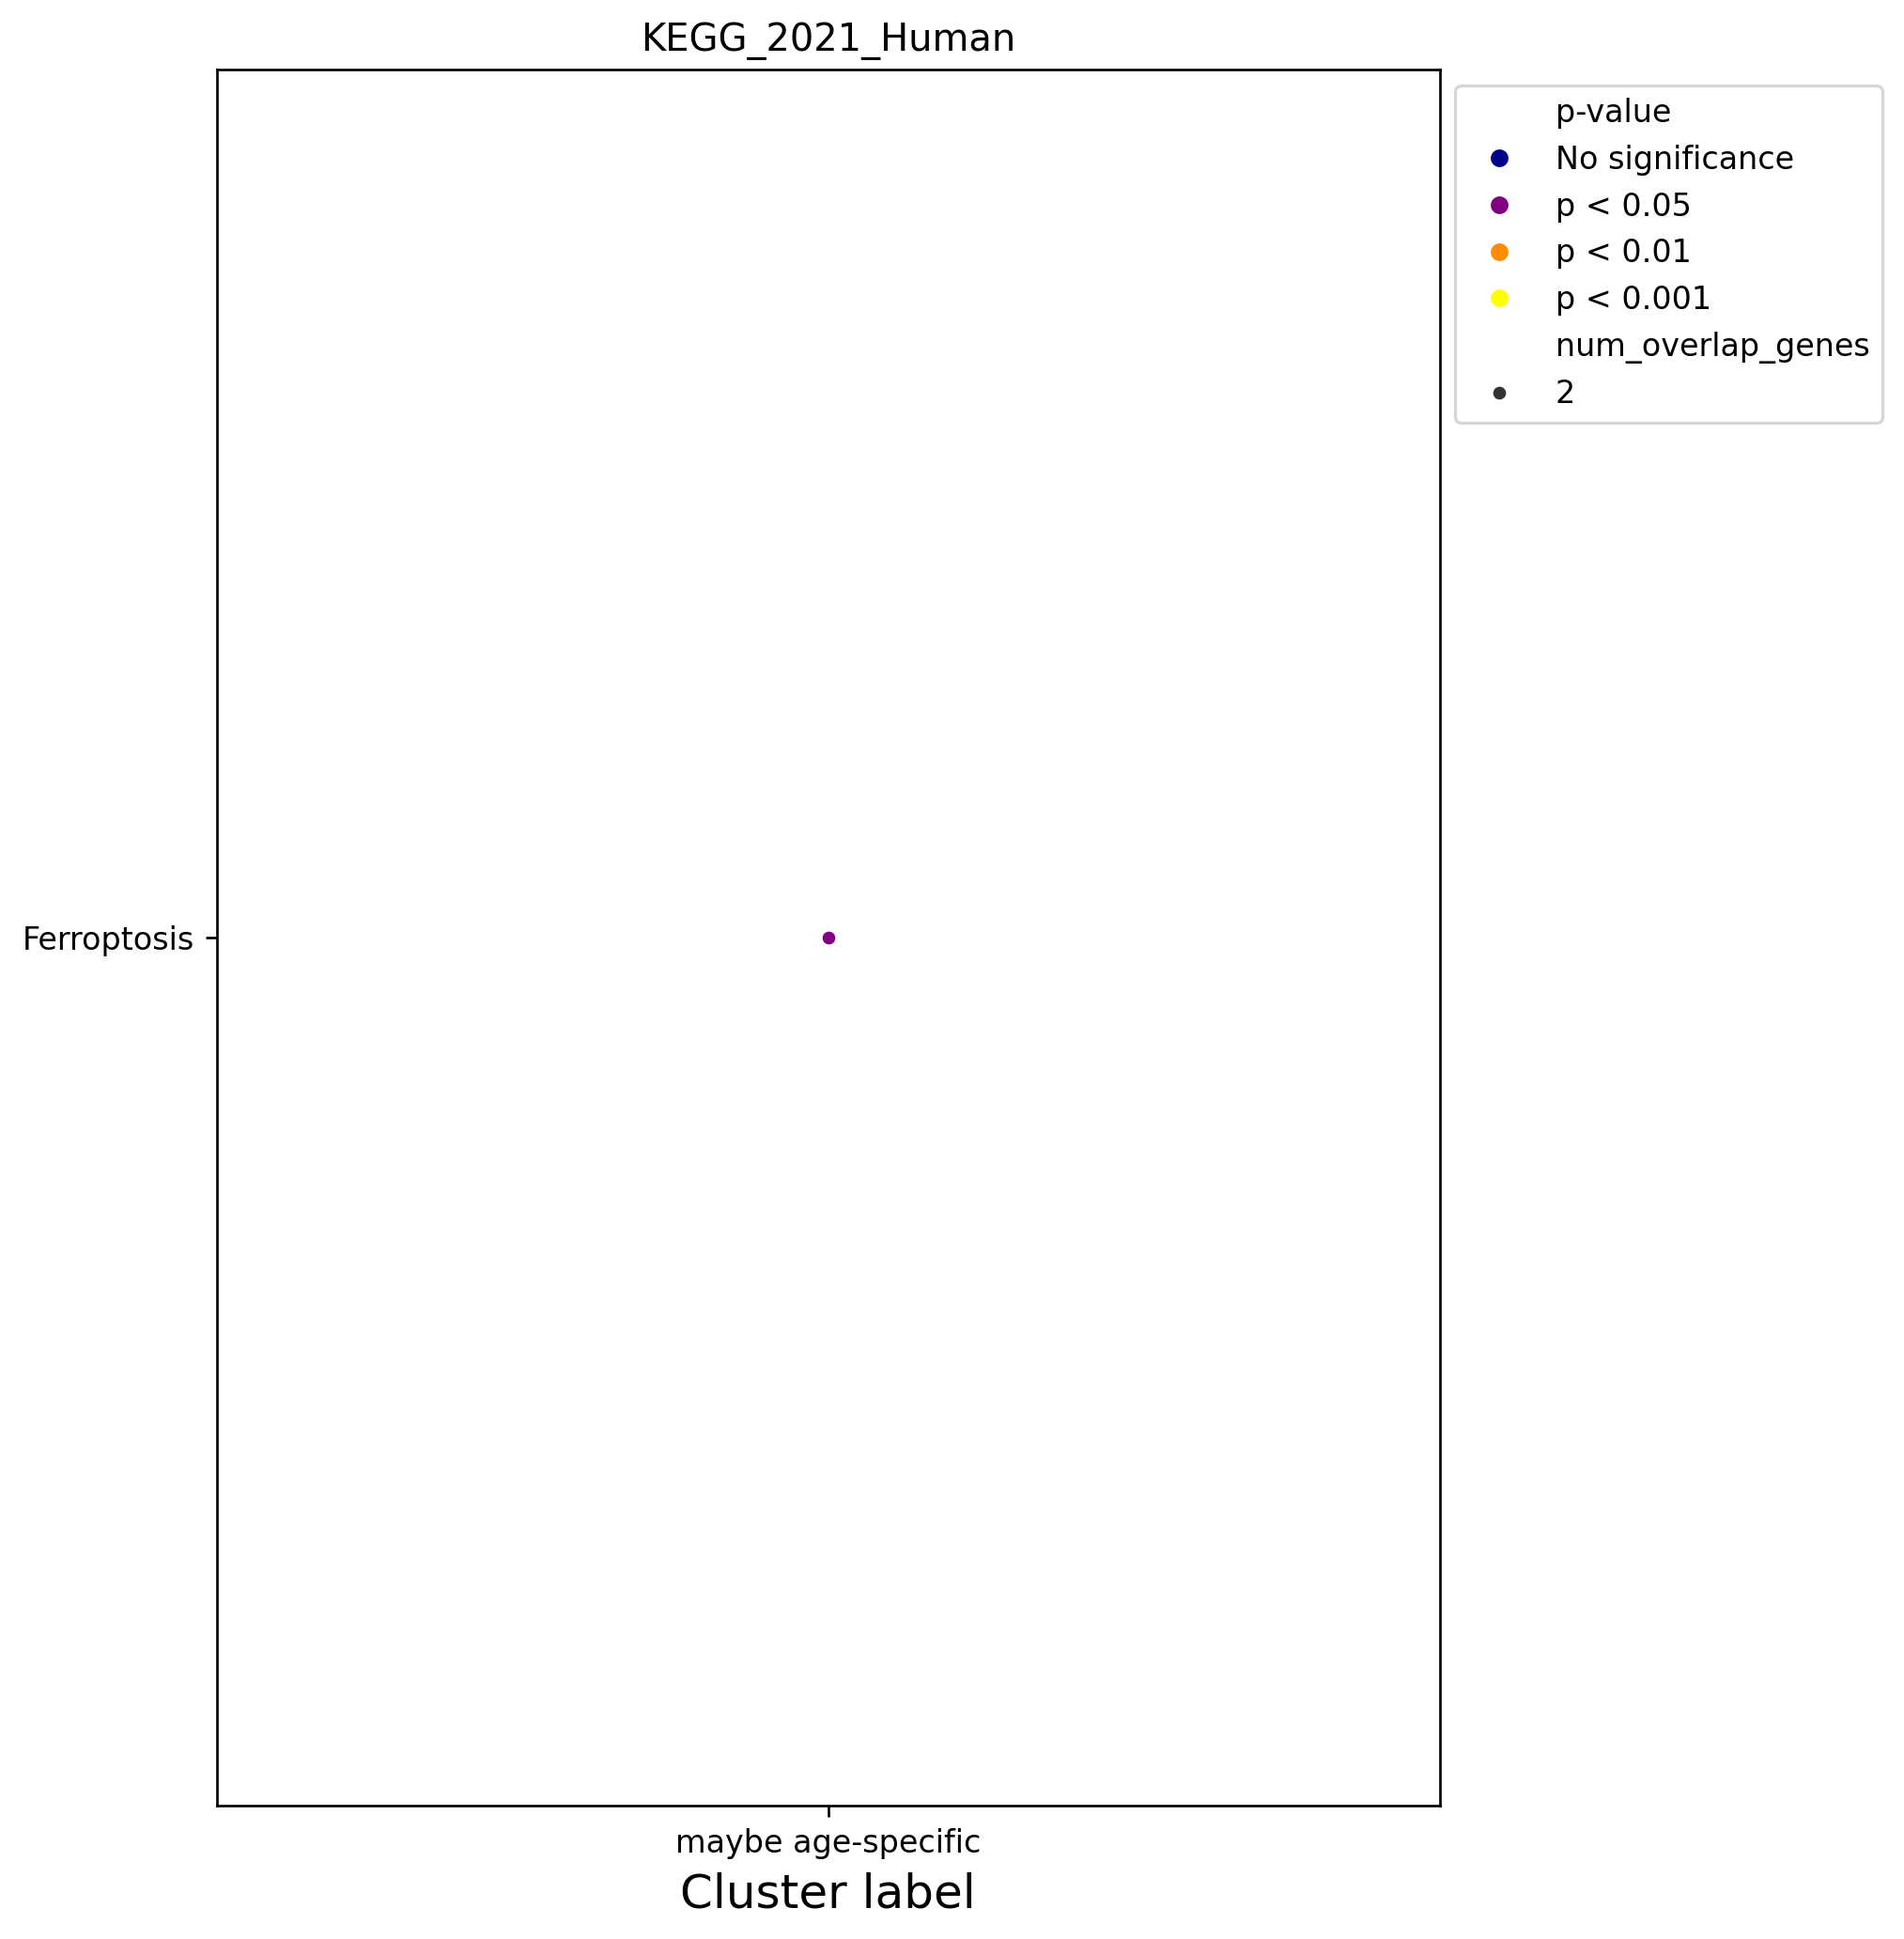

In [697]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))